Calculating LF with Denali Dataset

In [1]:
'''
To Do:

Remove edges
Check why no N=1 objects.
Re-add errorbars
Try some kind of equal object binning

Check adding of LFs to get original results
Re-write Sigmoid function for z-success
Switch from Mike's catalogue
SV3 matching
Try to add kernel to find density (Tempel et al. 2009)
Implement Jackknife errorbars
g-r V/Vmax
weight - m_r graph comparison
'''

"\nTo Do:\n\nRemove edges\nCheck why no N=1 objects.\nRe-add errorbars\nTry some kind of equal object binning\n\nCheck adding of LFs to get original results\nRe-write Sigmoid function for z-success\nSwitch from Mike's catalogue\nSV3 matching\nTry to add kernel to find density (Tempel et al. 2009)\nImplement Jackknife errorbars\ng-r V/Vmax\nweight - m_r graph comparison\n"

In [2]:
%matplotlib inline

In [3]:
import  os
import  sys
import  glob
import  fitsio
import  redrock
import  datetime
import  redrock.templates
import  astropy
import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  scipy

from    scipy                   import  optimize
from    scipy.integrate         import  quad
from    scipy.optimize          import  curve_fit
from    scipy.interpolate       import  interp1d, RegularGridInterpolator
from    scipy                   import  stats

from    astropy.table           import  Table, join, vstack, unique, setdiff
from    astropy.coordinates     import  SkyCoord, match_coordinates_sky
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget.cmx          import  cmx_targetmask
from    desitarget.cmx          import  cmx_targetmask
from    desitarget.targets      import  desi_mask, bgs_mask, mws_mask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import  make_axes_locatable
from    itertools               import  combinations
from    desisurvey.utils        import  get_date
from    desitarget.sv1          import  sv1_cuts 
from    desitarget.sv3          import  sv3_cuts 
from    astropy.cosmology       import  FlatLambdaCDM
from    astropy.io              import  ascii
from    desitarget.io           import  read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir

#from    desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask
from    desitarget.sv1.sv1_targetmask import desi_mask as sv1_desi_mask
from    desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask

from    desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask
from    desitarget.sv3.sv3_targetmask import desi_mask as sv3_desi_mask
from    desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

from    timeit                        import default_timer as timer
from    pkg_resources                 import resource_filename
from    tqdm                          import tqdm

#sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py') # remove this
#from cuts import getGeoCuts, getPhotCuts

import warnings
warnings.filterwarnings('ignore')

In [4]:
# setting cosmological parameters
h = 1
cosmo = FlatLambdaCDM(H0=100*h * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

In [5]:
%set_env DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
%set_env SPECPROD=daily

env: DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
env: SPECPROD=daily


In [6]:
# read in all sv1 exposures
filename = '/global/homes/m/mjwilson/desi/SV1/bgs-cmxsv/py/bgs-cmxsv/dat/sv1-exposures.fits'
exp = Table.read(filename)

# ensure that only 'BGS+MWS' tiles are targeted
exps = exp[exp['TARGETS'] == 'BGS+MWS']
tiles = np.unique(exps['TILEID'].data)

# ensure that only dark tiles/exposures are selected
exps = exps[exps['GFA_SKY_MAG_AB_MED'] > 21.07]

In [7]:
conds = exps['TILEID', 'NIGHT', 'GFA_TRANSPARENCY_MED', 'GFA_FWHM_ASEC_MED', 'GFA_SKY_MAG_AB_MED']
conds_grouped = conds.group_by(['TILEID', 'NIGHT'])
conds = conds_grouped.groups.aggregate(np.mean)

In [8]:
exps = exps['TILEID', 'NIGHT', 'TILERA', 'TILEDEC', 'EXPTIME', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH']
exps['NEXP']   = 1

In [9]:
tile_info = astropy.table.unique(exps['TILEID', 'NIGHT', 'TILERA', 'TILEDEC'], keys='TILEID')

exps_grouped = exps.group_by(['TILEID', 'NIGHT'])
exps = exps_grouped.groups.aggregate(np.sum)
exps = exps['TILEID', 'NIGHT', 'TILERA', 'TILEDEC', 'NEXP', 'EXPTIME', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH']
#exps = join(exps, tile_info, keys='TILEID', join_type='left')
exps = join(exps, conds, keys=['TILEID', 'NIGHT'], join_type='left')

exps.sort('TILEID')

date_array = np.unique(exps['NIGHT'])
tile_array = np.unique(exps['TILEID'])

In [10]:
dexps_grouped  = exps.group_by('TILEID')
dexps_binned   = dexps_grouped.groups.aggregate(np.sum)
dexps          = dexps_binned
#dexps.pprint_all()

In [11]:
dexps['MEDIAN_SKY'] = 0.0
for i in range(len(dexps['TILEID'])):
    dexps['MEDIAN_SKY'][i] = np.median(exps[exps['TILEID'] == dexps[i]['TILEID']]['GFA_SKY_MAG_AB_MED'])

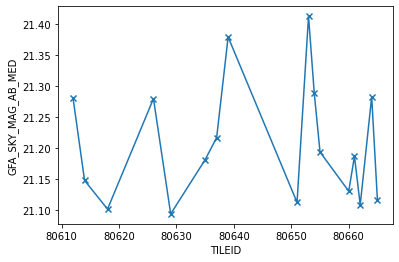

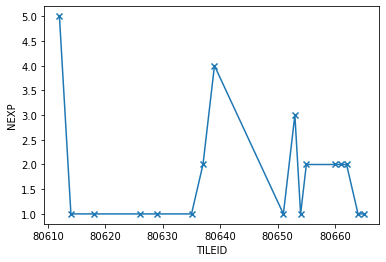

In [12]:
plt.plot(dexps['TILEID'], dexps['MEDIAN_SKY'])
plt.scatter(dexps['TILEID'], dexps['MEDIAN_SKY'], marker='x')
plt.xlabel('TILEID')
plt.ylabel('GFA_SKY_MAG_AB_MED')
plt.show()

plt.plot(dexps['TILEID'], dexps['NEXP'])
plt.scatter(dexps['TILEID'], dexps['NEXP'], marker='x')
plt.xlabel('TILEID')
plt.ylabel('NEXP')
plt.show()

In [13]:
dexps          = dexps['TILEID', 'EXPTIME', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH']
dexps          = join(dexps, tile_info, keys='TILEID', join_type='left')

dexps.sort('TILEID')

Text(0, 0.5, 'EXPTIME')

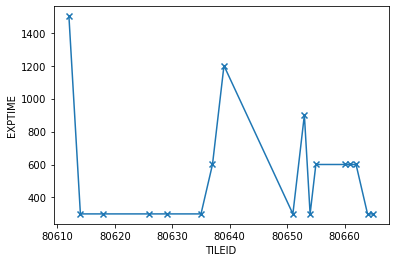

In [14]:
plt.plot(dexps['TILEID'], dexps['EXPTIME'])
plt.scatter(dexps['TILEID'], dexps['EXPTIME'], marker='x')
plt.xlabel('TILEID')
plt.ylabel('EXPTIME')

In [15]:
tile_info

TILEID,NIGHT,TILERA,TILEDEC
int64,int64,float32,float32
80612,20201218,66.68,-5.24
80614,20201218,154.1,-1.375
80618,20201221,114.221,38.469
80626,20210110,23.4,25.6
80629,20210103,29.0,-3.0
80635,20210105,36.0,-7.0
80637,20210110,38.5,0.5
80639,20210110,72.5,-1.1
80651,20210116,145.0,32.375


In [16]:
'''
flux_r = np.empty(0)
z = np.empty(0)
spectrograph_array = np.linspace(0,9,10,dtype=int)

#zs = Table()
#spec = Table()
#redrock = Table()
fm_all = Table()
zs_all = Table()

print('Files Loaded:')

for i in range(len(tile_info)):
    for j in range(len(spectrograph_array)):
        try:
            tile, date, spectrograph = str(tile_info['TILEID'][i]), str(tile_info['NIGHT'][i]), str(spectrograph_array[j])
            dirname = os.path.join(os.getenv("DESI_SPECTRO_REDUX"), "denali", "tiles", "pernight", tile, date)
            filename = "coadd-{}-{}-{}.fits".format(spectrograph, tile, date)
            specfilename = os.path.join(dirname, filename)
            DM = fitsio.FITS(specfilename)
            fm = Table.read(specfilename, 'FIBERMAP')
            fm_all = vstack([fm_all, fm])

            filename = specfilename.replace('coadd', 'zbest')
            zs = Table.read(filename)
            zs_all = vstack([zs_all, zs])
            
            # Not used
            filename = specfilename.replace('zbest', 'spectra')
            spec = Table.read(filename)

            filename = specfilename.replace('spectra', 'redrock')
            redrock = Table.read(filename)
            
            print(filename)

            gfa = Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_all_guide_ccds_SV1-thru_{}.fits'.format(date))
            #flux_r.extend(fm['FLUX_R'])
            #flux_r = np.concatenate((flux_r, fm["FLUX_R"]), axis=None)
           # z = np.concatenate((z, zs["Z"]), axis=None)
        
            #print(str(tile_info['TILEID'][i]), str(tile_info['NIGHT'][i]))
        except:
            print('pass:', str(tile_info['TILEID'][i]), str(tile_info['NIGHT'][i]))

            pass
    
'''

'\nflux_r = np.empty(0)\nz = np.empty(0)\nspectrograph_array = np.linspace(0,9,10,dtype=int)\n\n#zs = Table()\n#spec = Table()\n#redrock = Table()\nfm_all = Table()\nzs_all = Table()\n\nprint(\'Files Loaded:\')\n\nfor i in range(len(tile_info)):\n    for j in range(len(spectrograph_array)):\n        try:\n            tile, date, spectrograph = str(tile_info[\'TILEID\'][i]), str(tile_info[\'NIGHT\'][i]), str(spectrograph_array[j])\n            dirname = os.path.join(os.getenv("DESI_SPECTRO_REDUX"), "denali", "tiles", "pernight", tile, date)\n            filename = "coadd-{}-{}-{}.fits".format(spectrograph, tile, date)\n            specfilename = os.path.join(dirname, filename)\n            DM = fitsio.FITS(specfilename)\n            fm = Table.read(specfilename, \'FIBERMAP\')\n            fm_all = vstack([fm_all, fm])\n\n            filename = specfilename.replace(\'coadd\', \'zbest\')\n            zs = Table.read(filename)\n            zs_all = vstack([zs_all, zs])\n            \n     

In [17]:
deep_bright = Table()
deep_faint = Table()
deep_faintext = Table()
deep_lowq = Table()
deep_fibmag = Table()
deep_all = Table()

tile_cache = {}

for tileid in tiles:
    nights = np.unique(exps[exps['TILEID'] == tileid]['NIGHT'])

    for night in nights:
        tile_cache[(tileid, night)] = Table()
    
        for petal in range(10):
            
            path         = '/global/cfs/cdirs/desi/spectro/redux/denali/tiles/pernight/{}/{}/zbest-{}-{}-{}.fits'.format(tileid, night, petal, tileid, night)

            if os.path.isfile(path):            

                infile = fits.open(path)

                zbest    = infile['ZBEST'].data
                fmap     = infile['FIBERMAP'].data

                zbest    = Table(zbest)
                fmap     = Table(fmap)

                tinfo    = fmap['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'MASKBITS', 'EBV', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'SERSIC', 'MORPHTYPE'] 
                tinfo    = astropy.table.unique(tinfo, keys='TARGETID')

                # fmap[TILEID, FIBERSTATUS, EXPID]                                                                                                                                                                                               
                fmap         = join(fmap['TARGETID', 'EXPID', 'FIBERSTATUS'], exp['EXPID', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH'], keys='EXPID', join_type='left')
                fmap         = fmap[fmap['FIBERSTATUS'] == 0]

                fmap_grouped = fmap.group_by('TARGETID')
                fmap         = fmap_grouped.groups.aggregate(np.sum)
                
                deep         = join(zbest, tinfo, keys='TARGETID', join_type='left')
                deep         = join(deep,   fmap, keys='TARGETID', join_type='left')
                
                deep['TILEID'] = tileid
                
                # masks
                badbgs   = (deep['SV1_DESI_TARGET'] & sv1_desi_mask['BGS_ANY']) == 0
                nbright  = (deep['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) == 0
                nfaint   = (deep['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT'])  == 0
                #nfaintext = (deep['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT_EXT'])  == 0
                #nlowq = (deep['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ'])  == 0
                #nfibmag = (deep['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FIBMAG'])  == 0
                
                # limit to BGS only
                deep_b = deep[~nbright]
                deep_f = deep[~nfaint]
                #deep_fe = deep[~nfaintext]
                #deep_lq = deep[~nlowq]
                #deep_fm = deep[~nfibmag]

                # currently both bright and faint objects 
                deep     = deep[~badbgs]
                
                #deep = deep[deep['SPECTYPE'] == 'GALAXY']

                #deep['NODATA'] = (deep['ZWARN'] & 2**9) != 0 
                # print(np.count_nonzero(badfiber), np.count_nonzero(deep['NODATA']))
                #badfiber = deep['NODATA']
                #deep     = deep[~badfiber]
 
                deep_bright = vstack([deep_bright, deep_b])
                deep_faint = vstack([deep_faint, deep_f])
                #deep_faintext = vstack([deep_faintext, deep_fe])
                #deep_lowq = vstack([deep_lowq, deep_lq])
                #deep_fibmag = vstack([deep_fibmag, deep_fm])
                deep_all = vstack([deep_all, deep])

            else:
                pass

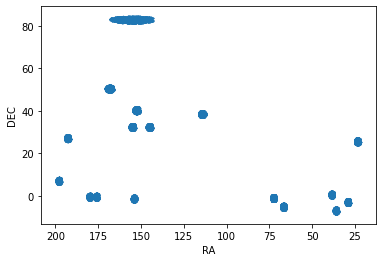

In [18]:
'''plt.scatter(fm_all['TARGET_RA'], fm_all['TARGET_DEC'], s=0.5)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.gca().invert_xaxis()
plt.show()'''

plt.scatter(deep_all['TARGET_RA'], deep_all['TARGET_DEC'], s=0.5)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.gca().invert_xaxis()
plt.show()

In [19]:
def tile_plotter(tile_array, zoom=2, z=True):
    for i in range(len(tile_array)):
        try:
            centre_ra = tile_info[tile_info['TILEID'] == tile_array[i]]['TILERA']
            centre_dec = tile_info[tile_info['TILEID'] == tile_array[i]]['TILEDEC']
            
            if z == True:
                plt.scatter(deep_all['TARGET_RA'], deep_all['TARGET_DEC'], s=0.25, label='Targets', c=deep_all['Z'])
                plt.colorbar()

            else:
                plt.scatter(deep_all['TARGET_RA'], deep_all['TARGET_DEC'], s=0.25, label='Targets')

            plt.xlim(centre_ra - zoom, centre_ra + zoom)
            plt.ylim(centre_dec - zoom, centre_dec + zoom)
            plt.gca().invert_xaxis()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.xlabel('RA')
            plt.ylabel('DEC')
            plt.title(tile_array[i])
            plt.show()
            
            plt.scatter(deep_bright['TARGET_RA'], deep_bright['TARGET_DEC'], s=0.25, label='bright')# c=deep['Z'])
            plt.scatter(deep_faint['TARGET_RA'], deep_faint['TARGET_DEC'], s=0.25, label='faint')# c=deep['Z'])
            plt.xlabel('RA')
            plt.ylabel('DEC')
            #plt.colorbar()
            plt.xlim(centre_ra - zoom, centre_ra + zoom) # change limits based on target ID.
            plt.ylim(centre_dec - zoom, centre_dec + zoom)
            plt.gca().invert_xaxis()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.legend()
            plt.show()
            
            
        except:
            print('Error with tile input for array entry', i)

In [20]:
#for i in range(len(tile_info)):
#    tile_plotter([tile_info['TILEID'][i]])

In [21]:
def mw_xtinct(ebv, band):
    '''
    A function to account for MW dust attenuation on observed fluxes. Taken from
    https://github.com/michaelJwilson/bgs-cmxsv/blob/main/py/bgs-cmxsv/mw_xtinct.py
    
    Input:
        EBV  : Extinction coefficient = (B-V)_obs - (B-V)_int     [Float]
        band : The relevant colour band (G, R, i, Z, Y)           [String] 
    '''
    
    coeffs = {'G': 3.214, 'R': 2.165, 'i': 1.592, 'Z': 1.211, 'Y': 1.064}
    Ab     = coeffs[band] * ebv
    return  10.**(-Ab / 2.5) 

In [22]:
def g_r_obs_func(data):
    '''
    Calculates observer-frame colour for a table given FLUX_R, FLUX_G and EBV.
    
    Input:
        data : the relevant dataset (such as deep_bright)         [Astropy Table]
    '''
    Fg = data['FLUX_G'] / mw_xtinct(data['EBV'], 'G')
    Fr = data['FLUX_R'] / mw_xtinct(data['EBV'], 'R')

    data['G-R_OBS'] = -2.51*np.log10(Fg/Fr)

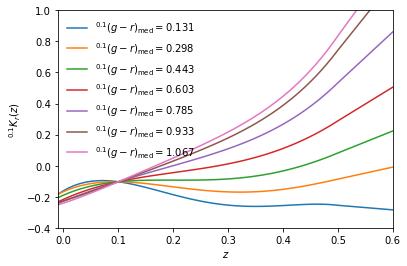

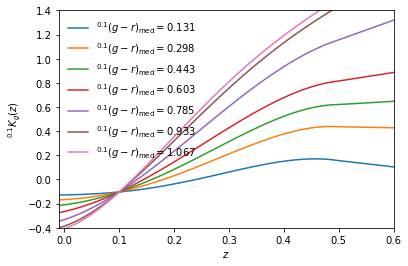

In [23]:
'''
Introduce K-correction work here.

The following cell of code is attributed to Alex Smith at Durham.
'''

class GAMA_KCorrection(object):
    
    def __init__(self, k_corr_file, z0=0.1, kind="linear"):

        """
        Colour-dependent polynomial fit to the GAMA K-correction (Fig. 13 of Smith+17), 
        used to convert between SDSS r-band Petrosian apparent magnitudes, and rest 
        frame absolute manigutues at z_ref = 0.1
        
        Args:
            k_corr_file: file of polynomial coefficients for each colour bin
            z0: reference redshift. Default value is z0=0.1
            kind: type of interpolation between colour bins,
                  e.g. "linear", "cubic". Default is "linear"
        """
        
        # read file of parameters of polynomial fit to k-correction
        # polynomial k-correction is of the form
        # A*(z-z0)^4 + B*(z-z0)^3 + C*(z-z0)^2 + D*(z-z0) + E 
        col_min, col_max, A, B, C, D, E, col_med = \
            np.loadtxt(k_corr_file, unpack=True)
    
        self.z0 = z0              # reference redshift
        self.nbins = len(col_min) # number of colour bins in file
        
        self.colour_min = np.min(col_med)
        self.colour_max = np.max(col_med)
        self.colour_med = col_med

        # functions for interpolating polynomial coefficients
        self.__A_interpolator = self.__initialize_parameter_interpolator(A, col_med, kind=kind)
        self.__B_interpolator = self.__initialize_parameter_interpolator(B, col_med, kind=kind)
        self.__C_interpolator = self.__initialize_parameter_interpolator(C, col_med, kind=kind)
        self.__D_interpolator = self.__initialize_parameter_interpolator(D, col_med, kind=kind)
        self.__E = E[0]

        # Linear extrapolation for z>0.5
        self.__X_interpolator = lambda x: None
        self.__Y_interpolator = lambda x: None
        self.__X_interpolator, self.__Y_interpolator = self.__initialize_line_interpolators() 

   
    def __initialize_parameter_interpolator(self, parameter, median_colour, kind="linear"):
        # returns function for interpolating polynomial coefficients, as a function of colour
        return interp1d(median_colour, parameter, kind=kind, fill_value="extrapolate")

    
    def __initialize_line_interpolators(self):
        # linear coefficients for z>0.5
        X = np.zeros(self.nbins)
        Y = np.zeros(self.nbins)
        
        # find X, Y at each colour
        redshift = np.array([0.48,0.5])
        arr_ones = np.ones(len(redshift))
        for i in range(self.nbins):
            k = self.k(redshift, arr_ones*self.colour_med[i])
            X[i] = (k[1]-k[0]) / (redshift[1]-redshift[0])
            Y[i] = k[0] - X[i]*redshift[0]
        
        X_interpolator = interp1d(self.colour_med, X, kind='linear', fill_value="extrapolate")
        Y_interpolator = interp1d(self.colour_med, Y, kind='linear', fill_value="extrapolate")
        
        return X_interpolator, Y_interpolator


    def __A(self, colour):
        # coefficient of the z**4 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__A_interpolator(colour_clipped)

    def __B(self, colour):
        # coefficient of the z**3 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__B_interpolator(colour_clipped)

    def __C(self, colour):
        # coefficient of the z**2 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__C_interpolator(colour_clipped)

    def __D(self, colour):
        # coefficient of the z**1 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__D_interpolator(colour_clipped)

    def __X(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__X_interpolator(colour_clipped)

    def __Y(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__Y_interpolator(colour_clipped)


    def k(self, redshift, colour):
        """
        Polynomial fit to the GAMA K-correction for z<0.5
        The K-correction is extrapolated linearly for z>0.5

        Args:
            redshift: array of redshifts
            colour:   array of ^0.1(g-r) colour
        Returns:
            array of K-corrections
        """
        K = np.zeros(len(redshift))
        idx = redshift <= 0.5
        
        K[idx] = self.__A(colour[idx])*(redshift[idx]-self.z0)**4 + \
                 self.__B(colour[idx])*(redshift[idx]-self.z0)**3 + \
                 self.__C(colour[idx])*(redshift[idx]-self.z0)**2 + \
                 self.__D(colour[idx])*(redshift[idx]-self.z0) + self.__E

        idx = redshift > 0.5
        
        K[idx] = self.__X(colour[idx])*redshift[idx] + self.__Y(colour[idx])
        
        return K
    

def test_plots():

    kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
    kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

    z = np.arange(-0.01,0.601,0.01)
    cols = 0.130634, 0.298124, 0.443336, 0.603434, 0.784644, 0.933226, 1.06731

    # make r-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_r.k(z, col)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_r(z)$")
    plt.xlim(-0.01,0.6)
    plt.ylim(-0.4,1)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

    # make g-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_g.k(z, col)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_g(z)$")
    plt.xlim(-0.01,0.6)
    plt.ylim(-0.4,1.4)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

if __name__ == "__main__":
    test_plots()

In [24]:
def colour_observer(colour_rest, z):
    '''
    Returns the observer-frame colour for some rest-frame colour and z.

    Input: colour_rest = the rest-frame g-r colour of the galaxy.  [int, float, array]
           z = the redshift of the galaxy.                         [int, float, array]
    '''
    
    if isinstance(colour_rest, int) or isinstance(colour_rest, float):
        colour_rest = np.array([colour_rest])
    else:
        colour_rest = np.array(colour_rest)
    
    if isinstance(z, int) or isinstance(z, float):
        z = np.array([z])
    else:
        z = np.array(z)
        
    if len(z) == 1 and len(colour_rest) == 1:
        k_r = gama_kcorr_r.k(z, colour_rest)
        k_g = gama_kcorr_g.k(z, colour_rest)

    else:        
        k_r = []
        k_g = []
        for i in range(len(colour_rest)):
            k_r.extend(gama_kcorr_r.k(np.array([z[i]]), np.array([colour_rest[i]])))
            k_g.extend(gama_kcorr_g.k(np.array([z[i]]), np.array([colour_rest[i]])))
        
        k_r = np.array(k_r)
        k_g = np.array(k_g)
    
    return colour_rest + k_g - k_r 

def colour_func(colour_rest, colour_obs, z):
    '''
    Returns the difference between the apparent magnitude from the function and the 
    actual observer-frame colour.
    '''
    colour_rest = np.array([colour_rest])
    colour_observer_func = colour_observer(colour_rest, z)
    return colour_observer_func - colour_obs

def colour_rest_func(colour_obs, z):
    '''
    Returns rest-frame colour values using Brent's method.
    '''
    root = optimize.brentq(colour_func, -10000, 10000, args=(colour_obs, z))
    return root

def K_corr(z, colour_obs, params):
    if params == None:
        
        z = np.array([z])
        colour_obs = np.array([colour_obs])
        colour_rest = colour_rest_func(colour_obs, z)
        colour_rest = np.array([colour_rest])
        
        k_r = gama_kcorr_r.k(z, colour_rest)
        #k_g = gama_kcorr_g.k(z, colour_rest)

        return k_r
    
    else:
        '''
        SOURCE: Table 1. and Eqn 1. in McNaught-Roberts et al. (2014)
        Values for (g-r)_0 = 0.553
        params=[-6.299, 14.76, -7.473, 1.847, -0.006801]
        '''
        return params[0]*z**4 + params[1]*z**3 + params[2]*z**2 + params[3]*z**1 + params[4]*z**0 

In [25]:
def diff_func(z, abs_mag, mag_limit, colour_rest, params=None):

    lum_dist = cosmo.luminosity_distance(z).value
    if params==None:
        if isinstance(colour_rest, int) or isinstance(colour_rest, float):
            colour_rest = np.array([colour_rest])
        else:
            colour_rest = np.array(colour_rest)

        if isinstance(z, int) or isinstance(z, float):
            z = np.array([z])
        else:
            z = np.array(z)

        app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + gama_kcorr_r.k(z, colour_rest)
        
    else:
        K_r = params[0]*z**4 + params[1]*z**3 + params[2]*z**2 + params[3]*z**1 + params[4]*z**0 
        app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + K_r
    
    return app_mag - mag_limit
    
    
def vmax_brent(data, lower_z, upper_z, mag_limit, params=None):
    abs_mag = data['R_ABSK']
    colour_rest = data['G-R_REST']

    # fix this part
    min_z = 0
    max_z = 0.6
    
    root = scipy.optimize.brentq(diff_func, min_z, max_z, args=(abs_mag, mag_limit, colour_rest))
    
    z_lim_min = np.min([root, lower_z])
    z_lim_max = np.min([root, upper_z])
    #print('z_lim_max', z_lim_max)
    vol = h**3 * (cosmo.comoving_volume(z_lim_max).value - cosmo.comoving_volume(z_lim_min).value)
    return vol #, root

In [26]:
def colour_observer_func(colour_rest, colour_obs, z):
    '''
    Returns the difference between the colour from the function and the 
    actual observer-frame colour.
    
    Input:
           colour_rest = the rest-frame g-r colour of the galaxy.    [int, float, array]
           colour_obs = the observer-frame g-r colour of the galaxy. [int, float, array]
           z = the redshift of the galaxy.                           [int, float, array]
    '''

    colour_observer_func = colour_observer(colour_rest, z)
    return colour_observer_func - colour_obs

def k_corr_data(data, params=None):
    '''
    This function finds the rest-frame colour of galaxies using Brent's method.
    From this, the K-corrections in the r and g bands are calculated.
    Input:
        data: the relevant dataset   [Astropy Table]
        params (optional): will generate an alternative 
    '''
    
    if params == None:
        data['G-R_REST'] = 0.0

        for i in range(len(data)):
            colour_obs_holder = data['G-R_OBS'][i]
            z_holder = data['Z'][i]

            try:
                root = optimize.brentq(colour_observer_func, -2, 5, args=(colour_obs_holder, z_holder))        
                data['G-R_REST'][i] = root

            except:
                pass
            
        data['K_R'] = gama_kcorr_r.k(data['Z'], data['G-R_REST'])
        data['K_G'] = gama_kcorr_g.k(data['Z'], data['G-R_REST'])
        
    else:
        '''
        SOURCE: Table 1. and Eqn 1. in McNaught-Roberts et al. (2014)
        Values for (g-r)_0 = 0.553
        params=[-6.299, 14.76, -7.473, 1.847, -0.006801]
        '''
        
        data['K_R'] = params[0]*data['Z']**4 + params[1]*data['Z']**3 + params[2]*data['Z']**2 + params[3]*data['Z']**1 + params[4]*data['Z']**0 

In [27]:
def selection_cut(data, spectype=None, z_min=None, z_max=None, zwarn=None, zerr=None, deltachi2=None):
    '''
    A selection function.
    Input:
        data: The relevant dataset  [Astropy Table]
        spectype: The spectype ('GALAXY', 'STAR', 'QSO') [String]
        z_min: The minimum z value. [Float]
        z_max: The maximum z value. [Float]
        zwarn: If True, excludes all values with a zwarn flag. [Boolean]
        zerr: If True, selects by an uncertainty measure. [Boolean]
        deltachi2: The minimum delta chi squared value. [Float]
    '''
    if spectype != None:
        data = data[data['SPECTYPE'] == spectype]
            
    if z_min != None:
        data = data[data['Z'] > z_min]
    
    if z_max != None:
        data = data[data['Z'] < z_max]
    
    if zwarn != None:
        data = data[data['ZWARN'] == 0]

    if zerr != None:
        data = data[data['ZERR'] < (0.0005 * (1. + data['Z']))]
        
    if deltachi2 != None:
        data = data[data['DELTACHI2'] > deltachi2]
        
    return data

In [28]:
def z_rmag_plot(data, mag_limit, hexbin=False):
    
    if hexbin == True:
        plt.hexbin(data['Z'], data['MODEL_MAG'])
        plt.colorbar()

    else:
        plt.scatter(data['Z'], data['MODEL_MAG'], s=2.5)
        
    plt.axhline(mag_limit, color='r', linestyle='-')    
    plt.xlabel(r'$z$', fontsize=16)
    plt.ylabel(r'$r_{mag}$', fontsize=16)
    plt.ylim(17, 20)

In [29]:
def number_counts(data, nbins, z=True, app_mag=True):
    
    if z==True:
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        ax.hist(data['Z'], bins=nbins)
        ax.set_yscale('log')
        ax.set_xlabel(r'$Z$', fontsize=16)
        ax.set_ylabel('N', fontsize=16)
        ax.minorticks_on()
        plt.show()
    
    if app_mag==True:
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        ax.hist(data['MODEL_MAG'], bins=nbins, label = 'm')
        
        r_mag_arnouts = np.arange(17.11, 24.61, 0.5)
        arnouts = np.array([1.66,1.83,2.17,2.36,2.54,2.74,2.92,3.15,3.37,3.55,3.75,3.95,4.13,4.31,4.43])
        r_mag_huang = np.arange(16, 23.5, 0.5)
        huang = np.array([0.69,1.39,1.17,1.39,1.87,2.10,2.44,2.68,2.86,3.11,3.27,3.47,3.60,3.78,4.05])
        ax.plot(r_mag_arnouts, 10**arnouts, label='Arnouts (2001)')
        ax.plot(r_mag_huang, 10**huang, label='Huang (2001)')
        ax.set_yscale('log')
        ax.set_xlabel(r'$m$', fontsize=16)
        ax.set_ylabel('N', fontsize=16)
        ax.minorticks_on()
        ax.legend()
        plt.show()

In [30]:
def app_mag_calc(data):
    data['MW_CORRECTION_R'] = mw_xtinct(data['EBV'], band='R')
    data['MODEL_MAG'] = 22.5 - 2.5*np.log10(data['FLUX_R'] / data['MW_CORRECTION_R'])
    data['MODEL_FIBRE_MAG'] = 22.5 - 2.5*np.log10(data['FIBERFLUX_R'] / data['MW_CORRECTION_R'])
    
def abs_mag_calc(data):
    lum_dist_list = cosmo.luminosity_distance(data['Z']).value
    abs_mag_list = data['MODEL_MAG'] - (5 * np.log10(lum_dist_list)) - 25
    data['R_ABSK'] = abs_mag_list - data['K_R']

In [31]:
def abs_mag_calc2(M_r, z_range, K_r):
    return M_r + 5*np.log10(cosmo.luminosity_distance(z_range).value) + 25 + K_r

In [32]:
def schechter(M, Mstar, alpha, phistar):
    return 0.4*np.log(10)*phistar * (10**(0.4*(Mstar-M)))**(alpha+1) * np.exp(-10**(0.4*(Mstar-M)))

def log_schechter(M, Mstar, alpha, phistar):
    return np.log10(0.4*np.log(10)*phistar * (10**(0.4*(Mstar-M)))**(alpha+1) * np.exp(-10**(0.4*(Mstar-M))))

In [33]:
def abs_mag_plot(data, schechter_plot=True):
    '''
    Generate a Schechter plot based solely on M_r (absolute magnitude) for the inputed dataset.
    Input:
         data: the relevant dataset [Astropy Table]
         schechter_plot: if True, plots the Schechter function and returns the parameters [Boolean] 
    '''
    bins = np.linspace(-25, -10, 61)
    data_entries, bins = np.histogram(data['R_ABSK'], bins=bins)
    binscentre = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    plt.bar(binscentre, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')

    if schechter_plot == True:
        popt, pcov = curve_fit(schechter, xdata=binscentre, ydata=data_entries, p0=[-13, -1, 1])
        print(popt)

        xspace = np.linspace(-24, -14, 100000)
        plt.plot(xspace, schechter(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')

    plt.xlabel(r'$M_r$')
    plt.ylabel(r'N')
    plt.yscale('log')
    plt.ylim(10**0, 10**3)
    plt.title(r'Schechter Fitting')
    plt.legend(loc='best')
    plt.show()
    plt.clf()

In [34]:
'''
Move below weights
'''
'''
M = -22
z = 0.5
mag_limit = 19.5
colour_obs = 0.533
params = None

gama_kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
gama_kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")'''
'''
deep_bright_original['VMAX_Z'] = 0.0
 
for i in range(len(deep_bright_original)):
    colour_obs = deep_bright_original['G-R_OBS'][i]
    
    root = optimize.brentq(diff_func, 0.001, 10, args=(M,mag_limit,colour_obs,params), full_output=False)
    deep_bright_original['VMAX_Z'][i] = root
    
'''

"\ndeep_bright_original['VMAX_Z'] = 0.0\n \nfor i in range(len(deep_bright_original)):\n    colour_obs = deep_bright_original['G-R_OBS'][i]\n    \n    root = optimize.brentq(diff_func, 0.001, 10, args=(M,mag_limit,colour_obs,params), full_output=False)\n    deep_bright_original['VMAX_Z'][i] = root\n    \n"

In [35]:
'''
#Brent Method test


colour_obs = 1.2 # test-value
z = 0.2
colour_rest = 0.6224953788284654
colour_rest_range = np.arange(0, 2, 0.01)
c_range = colour_observer(colour_rest_range, z)
#colour_rest(colour_obs, z)
plt.plot(colour_rest_range, c_range, label='z='+str(z))
colour_rest_func(colour_obs, z)
plt.axhline(y=colour_obs, color='r', linestyle='--', linewidth=0.75)


z = 0.4
c_range = colour_observer(colour_rest_range, z)
#colour_rest(colour_obs, z)
plt.plot(colour_rest_range, c_range, label='z='+str(z))
colour_rest_func(colour_obs, z)
plt.axhline(y=colour_obs, color='r', linestyle='--', linewidth=0.75)

plt.scatter(roots, [colour_obs]*len(roots), label = 'Brent', marker='X')
plt.xlabel(r'$g-r_{rest}$', fontsize=16)
plt.ylabel(r'$g-r_{obs}$', fontsize=16)
#plt.xlim(0.2, 0.5)
#plt.ylim(0, 1.5)
plt.title('Brent Method Test')
plt.legend()
plt.show()
print('root:', roots)


roots = []
colour_obs = colour_obs # will be data[]
root = optimize.brentq(colour_func, -1, 4, args=(colour_obs, z))
roots.append(root)
print(roots)
'''


"\n#Brent Method test\n\n\ncolour_obs = 1.2 # test-value\nz = 0.2\ncolour_rest = 0.6224953788284654\ncolour_rest_range = np.arange(0, 2, 0.01)\nc_range = colour_observer(colour_rest_range, z)\n#colour_rest(colour_obs, z)\nplt.plot(colour_rest_range, c_range, label='z='+str(z))\ncolour_rest_func(colour_obs, z)\nplt.axhline(y=colour_obs, color='r', linestyle='--', linewidth=0.75)\n\n\nz = 0.4\nc_range = colour_observer(colour_rest_range, z)\n#colour_rest(colour_obs, z)\nplt.plot(colour_rest_range, c_range, label='z='+str(z))\ncolour_rest_func(colour_obs, z)\nplt.axhline(y=colour_obs, color='r', linestyle='--', linewidth=0.75)\n\nplt.scatter(roots, [colour_obs]*len(roots), label = 'Brent', marker='X')\nplt.xlabel(r'$g-r_{rest}$', fontsize=16)\nplt.ylabel(r'$g-r_{obs}$', fontsize=16)\n#plt.xlim(0.2, 0.5)\n#plt.ylim(0, 1.5)\nplt.title('Brent Method Test')\nplt.legend()\nplt.show()\nprint('root:', roots)\n\n\nroots = []\ncolour_obs = colour_obs # will be data[]\nroot = optimize.brentq(colour

In [36]:
gama_kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
gama_kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

In [37]:
#g_r_obs_func(deep_all)
#k_corr_data(deep_all)
#app_mag_calc(deep_all)
#abs_mag_calc(deep_all)

for i in tqdm(range(0, 1), desc ="K correction work"):
    g_r_obs_func(deep_bright)
    k_corr_data(deep_bright) # params = None
    app_mag_calc(deep_bright)
    abs_mag_calc(deep_bright)

K correction work: 100%|██████████| 1/1 [02:03<00:00, 123.91s/it]


In [38]:
#deep_all_original = deep_all
deep_bright_original = deep_bright

#deep_all = selection_cut(deep_all, spectype='GALAXY', z_max=0.6, zwarn=True, zerr=True, deltachi2=40)
#deep_bright = selection_cut(deep_bright, spectype='GALAXY', z_max=0.6, zwarn=True, zerr=True, deltachi2=40)

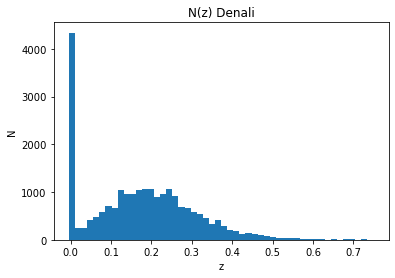

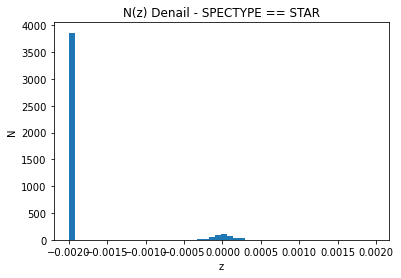

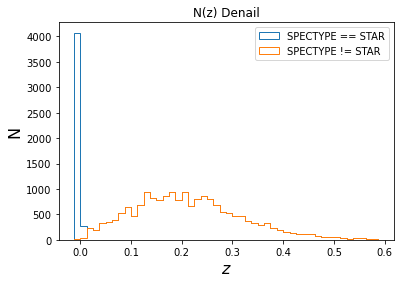

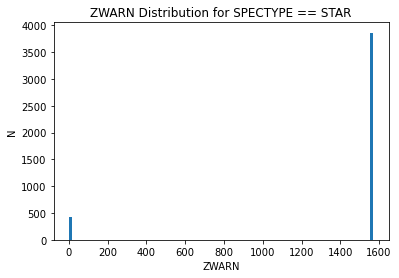

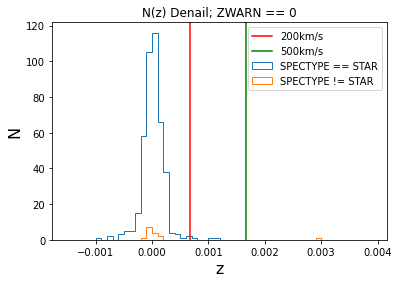

In [39]:
db1 = deep_bright_original[deep_bright_original['Z'] < 0.75] 
plt.hist(db1['Z'], bins=50)
plt.xlabel('z')
plt.ylabel('N')
plt.title('N(z) Denali')
plt.show()

db2 = db1[db1['SPECTYPE'] == 'STAR']
db3 = db1[db1['SPECTYPE'] != 'STAR']
plt.hist(db2['Z'], bins=50)
plt.xlabel('z')
plt.ylabel('N')
plt.title('N(z) Denail - SPECTYPE == STAR')
plt.show()

plt.hist(db1['Z'], bins=np.arange(-0.0125, 0.6, 0.0125), histtype='step', label='SPECTYPE == STAR')
plt.hist(db3['Z'], bins=np.arange(-0.0125, 0.6, 0.0125), histtype='step', label='SPECTYPE != STAR')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.legend()
plt.title('N(z) Denail')
plt.show()


plt.hist(db2['ZWARN'], bins=100)
plt.xlabel('ZWARN')
plt.ylabel('N')
plt.title('ZWARN Distribution for SPECTYPE == STAR')
plt.show()


db1 = deep_bright_original[deep_bright_original['Z'] < 0.75] 
db2 = db1[db1['SPECTYPE'] == 'STAR']
db3 = db1[db1['SPECTYPE'] != 'STAR']


db4 = db2[db2['ZWARN'] == 0]
db5 = db3[db3['ZWARN'] == 0]

bins_list2 = np.arange(-0.0015, 0.004, 0.0001)
plt.hist(db4['Z'], bins=bins_list2, histtype='step', label='SPECTYPE == STAR')
plt.hist(db5['Z'], bins=bins_list2, histtype='step', label='SPECTYPE != STAR')
#.xlim(0, 0.02)
plt.xlabel('z', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) Denail; ZWARN == 0')

c = 3*10**5
plt.axvline(200 / c, color='r', label='200km/s')
plt.axvline(500 / c, color='g', label='500km/s')
plt.legend()
plt.show()

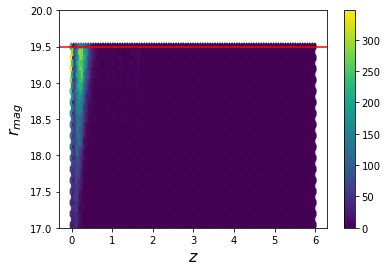

In [40]:
z_rmag_plot(deep_bright, 19.5, hexbin=True)

In [41]:
#number_counts(deep_all, nbins=50)

In [42]:
'''
nbins = np.arange(0, 6.5, 0.125) #50
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.hist(deep_faint['Z'], bins=nbins, label='faint', histtype='step')
ax.hist(deep_bright['Z'], bins=nbins, label ='bright', histtype='step')
#ax.hist(deep_faintext['Z'], bins=nbins, label ='faintext', histtype='step')
#ax.hist(deep_fibmag['Z'], bins=nbins, label = 'fibmag', histtype='step')
#ax.hist(deep_lq['Z'], bins=nbins, label ='lowq', histtype='step')
ax.set_yscale('log')
ax.set_xlabel(r'$Z$', fontsize=16)
ax.set_ylabel('N', fontsize=16)
ax.minorticks_on()
ax.legend()
plt.show()

nbins = 100
fig, ax = plt.subplots(figsize=(9,5))
data1 = deep_bright['Z']
data2 = deep_faint['Z']
data3 = deep_all['Z']
data4 = deep_faintext['Z']
data5 = deep_lowq['Z']

ax.hist([data1, data2, data3], bins=nbins, histtype='step', linewidth=2,
        alpha=0.7, label=['BGS_BRIGHT','BGS_FAINT', 'BGS_ALL'])
ax.set_yscale('log')
ax.set_xlabel(r'$Z$', fontsize=16)
ax.set_ylabel('N', fontsize=16)
ax.minorticks_on()
ax.legend()
plt.show()

'''


"\nnbins = np.arange(0, 6.5, 0.125) #50\nfig, ax = plt.subplots(1,1, figsize=(10,5))\nax.hist(deep_faint['Z'], bins=nbins, label='faint', histtype='step')\nax.hist(deep_bright['Z'], bins=nbins, label ='bright', histtype='step')\n#ax.hist(deep_faintext['Z'], bins=nbins, label ='faintext', histtype='step')\n#ax.hist(deep_fibmag['Z'], bins=nbins, label = 'fibmag', histtype='step')\n#ax.hist(deep_lq['Z'], bins=nbins, label ='lowq', histtype='step')\nax.set_yscale('log')\nax.set_xlabel(r'$Z$', fontsize=16)\nax.set_ylabel('N', fontsize=16)\nax.minorticks_on()\nax.legend()\nplt.show()\n\nnbins = 100\nfig, ax = plt.subplots(figsize=(9,5))\ndata1 = deep_bright['Z']\ndata2 = deep_faint['Z']\ndata3 = deep_all['Z']\ndata4 = deep_faintext['Z']\ndata5 = deep_lowq['Z']\n\nax.hist([data1, data2, data3], bins=nbins, histtype='step', linewidth=2,\n        alpha=0.7, label=['BGS_BRIGHT','BGS_FAINT', 'BGS_ALL'])\nax.set_yscale('log')\nax.set_xlabel(r'$Z$', fontsize=16)\nax.set_ylabel('N', fontsize=16)\nax

In [43]:
'''
abs_mag_plot(deep_all)

plt.scatter(deep_bright_original['MODEL_MAG'], deep_bright_original['MODEL_FIBRE_MAG'], s=0.25)
plt.xlabel(r'$m_r$')
plt.ylabel(r'$m_r$ [fibre]')
'''

"\nabs_mag_plot(deep_all)\n\nplt.scatter(deep_bright_original['MODEL_MAG'], deep_bright_original['MODEL_FIBRE_MAG'], s=0.25)\nplt.xlabel(r'$m_r$')\nplt.ylabel(r'$m_r$ [fibre]')\n"

In [216]:
#K_r_root = gama_kcorr_r.k(np.array([root]), np.array([gr_rest]))

In [217]:
#abs_mag_calc2(M_r, root, K_r_root)

TypeError: cannot unpack non-iterable numpy.float64 object

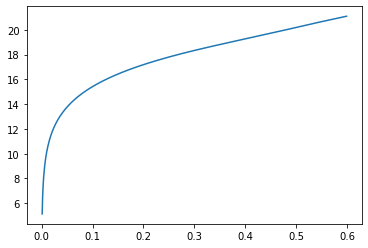

In [46]:
mag_limit = 19.5
z_range = np.arange(0, 0.6, 0.001)

for i in range(4):
    gr_rest = deep_bright_original['G-R_REST'][i]
    M_r = deep_bright_original['R_ABSK'][i]
    gr_range = np.ones(len(z_range)) * gr_rest
    K_r = gama_kcorr_r.k(z_range, gr_range)
    m_r = abs_mag_calc2(M_r, z_range, K_r)
    plt.plot(z_range, m_r)

    vol, root = vmax_brent(deep_bright_original[i], 0, 0.6, mag_limit, params=None)
    K_r_root = gama_kcorr_r.k(np.array([root]), np.array([gr_rest]))
    plt.scatter(root, abs_mag_calc2(M_r, root, K_r_root))

plt.axhline(19.5, ls='--', color='r')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$m_r$', fontsize=16)
plt.title('Brent Method Test')
plt.show()

Load Target Catalogue

In [47]:
#hpdirname = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.52.0/targets/sv1/resolve/bright'
hpdirname = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.57.0/targets/sv3/resolve/bright'

deg = 1.6

captargs = {}
for key in tqdm(dexps):
    
    rai, deci = key['TILERA'], key['TILEDEC']
    radecrad = [rai,deci,deg]
    #print(radecrad, type(str(key['TILEID'])))
    captargs[str(key['TILEID'])] = read_targets_in_cap(hpdirname, radecrad)
    print(key['TILEID'])

  6%|▌         | 1/17 [00:31<08:26, 31.63s/it]

80612


 12%|█▏        | 2/17 [00:47<06:43, 26.89s/it]

80614


 18%|█▊        | 3/17 [01:03<05:30, 23.63s/it]

80618


 24%|██▎       | 4/17 [01:18<04:33, 21.02s/it]

80626


 29%|██▉       | 5/17 [01:34<03:55, 19.65s/it]

80629


 35%|███▌      | 6/17 [01:50<03:21, 18.32s/it]

80635


 41%|████      | 7/17 [02:05<02:53, 17.31s/it]

80637


 47%|████▋     | 8/17 [02:19<02:28, 16.47s/it]

80639


 53%|█████▎    | 9/17 [02:34<02:08, 16.05s/it]

80651


 59%|█████▉    | 10/17 [02:49<01:49, 15.66s/it]

80653


 65%|██████▍   | 11/17 [03:04<01:33, 15.54s/it]

80654


 71%|███████   | 12/17 [03:19<01:17, 15.46s/it]

80655


 76%|███████▋  | 13/17 [03:35<01:02, 15.52s/it]

80660


 82%|████████▏ | 14/17 [03:50<00:46, 15.35s/it]

80661


 88%|████████▊ | 15/17 [04:07<00:31, 15.79s/it]

80662


 94%|█████████▍| 16/17 [04:22<00:15, 15.65s/it]

80664


100%|██████████| 17/17 [04:38<00:00, 16.38s/it]

80665


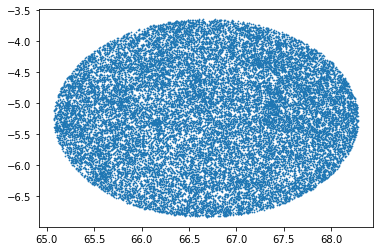

In [48]:
plt.scatter(captargs['80612']['RA'], captargs['80612']['DEC'], s=0.5)

In [49]:
'''
#plt.figure(figsize=(10,10))

for i in range(2):
    try:
        tileid = tile_array[i]
        plt.scatter(captargs[str(tileid)]['RA'], captargs[str(tileid)]['DEC'], s=0.05, label='targeted')
        plt.xlabel('RA')
        plt.ylabel('DEC')
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(str(tileid))
        #plt.show()
        tile_plotter([tileid], z=False)
        plt.label()
        print('Number of Target Objects:', len(captargs[str(tileid)]['RA']))
        print('----------')
    except:
        pass
'''

"\n#plt.figure(figsize=(10,10))\n\nfor i in range(2):\n    try:\n        tileid = tile_array[i]\n        plt.scatter(captargs[str(tileid)]['RA'], captargs[str(tileid)]['DEC'], s=0.05, label='targeted')\n        plt.xlabel('RA')\n        plt.ylabel('DEC')\n        plt.gca().invert_xaxis()\n        plt.gca().set_aspect('equal', adjustable='box')\n        plt.title(str(tileid))\n        #plt.show()\n        tile_plotter([tileid], z=False)\n        plt.label()\n        print('Number of Target Objects:', len(captargs[str(tileid)]['RA']))\n        print('----------')\n    except:\n        pass\n"

In [50]:
'''
targeted_objs = SkyCoord(captargs[str(tileid)]['RA']*u.deg, captargs[str(tileid)]['DEC']*u.deg)
target_objs = SkyCoord(deep_all['TARGET_RA']*u.deg, deep_all['TARGET_DEC']*u.deg)

#idx, d2d, d3d = targeted_objs.match_to_catalog_sky(target_objs)

#plt.hist(d2d.arcsec, histtype='step', bins = 100)
#plt.xlabel('separation [arcsec]')
#plt.tight_layout()
#plt.show()

idx, d2d, d3d = target_objs.match_to_catalog_sky(targeted_objs)

plt.hist(d2d.arcsec, histtype='step', bins = 5000)
plt.xlabel('separation [arcsec]')
#plt.xlim(0,0.25)
plt.tight_layout()
plt.xlim(0,100)
plt.show()
'''

"\ntargeted_objs = SkyCoord(captargs[str(tileid)]['RA']*u.deg, captargs[str(tileid)]['DEC']*u.deg)\ntarget_objs = SkyCoord(deep_all['TARGET_RA']*u.deg, deep_all['TARGET_DEC']*u.deg)\n\n#idx, d2d, d3d = targeted_objs.match_to_catalog_sky(target_objs)\n\n#plt.hist(d2d.arcsec, histtype='step', bins = 100)\n#plt.xlabel('separation [arcsec]')\n#plt.tight_layout()\n#plt.show()\n\nidx, d2d, d3d = target_objs.match_to_catalog_sky(targeted_objs)\n\nplt.hist(d2d.arcsec, histtype='step', bins = 5000)\nplt.xlabel('separation [arcsec]')\n#plt.xlim(0,0.25)\nplt.tight_layout()\nplt.xlim(0,100)\nplt.show()\n"

In [51]:
deep_all_80612 = deep_all[deep_all['TILEID'] == 80612]

In [52]:
data = deep_all_80612

In [53]:
data['SKYCOORD'] = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')

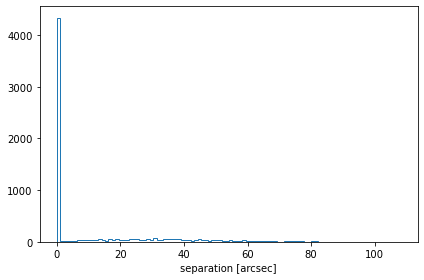

In [54]:

#target_objs = SkyCoord(captargs[str(tile_array[0])]['RA'], captargs[str(tile_array[0])]['DEC'], frame='icrs', unit='deg')

target_objs = SkyCoord(captargs[str(tile_array[0])]['RA'], captargs[str(tile_array[0])]['DEC'], frame='icrs', unit='deg')
#targeted_objs = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
targeted_objs = data['SKYCOORD']

idx, d2d, d3d = targeted_objs.match_to_catalog_sky(target_objs)
plt.hist(d2d.arcsec, histtype='step', bins = 100)
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()

In [55]:
data['idx'] = idx
data['d2d'] = d2d
data['d3d'] = d3d

max_sep = 1.0 * u.arcsec
data1 = data[data['d2d'] < max_sep]

In [136]:
target_cat = Table(captargs[str(tile_array[0])])

for i in range(1, len(tile_array)):
    obs2 = Table(captargs[str(tile_array[i])])
    
    target_cat = vstack([target_cat, obs2])

In [138]:
target_cat

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64
9010,297557,0681m057,45,SER,68.0336965309936,11649730000000.0,-5.659641120552103,13074440000000.0,717324.25 .. 946320.25,0.056753032,30.844383,85.02723,165.06297,199.04315,37.86428,17.825378,0.84535336,0.89300084,0.9386611,0.007012118,0.004354616,0.0039845426,0.06417013,0.059995677,0.062363785,0.8689735,0.96891093,0.8356078,4,4,6,3329.0503,693.048,233.923,2063.4749,405.7929,117.358864,154.46617,104.00628,-83.87674,-3600.3076,1.0790153,0.35972735,0.00072505156,1.0952905e-05,0.99042815,0.9941107,0.99874103,0.9995244,0,0,0,7.7915134,21.47849,41.6961,7.791521,21.478502,41.696117,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,2.049274,-0.06881402,-0.00486449,57828.914,449501.7,223125.56,6.0,2700.472,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,S,39627647109562413,1152921504606846976,131074,0,0.24426692976533626,516,102100,9,0,22733
9010,297557,0681m057,97,DEV,68.03576483669777,332996740000.0,-5.733371198416572,762489340000.0,31971.225 .. 45493.49,0.056781664,3.2387247,13.932751,35.339108,384.35803,62.243256,23.079956,0.8452817,0.8929499,0.9386312,0.08013148,0.030342307,0.0026690154,0.072806485,0.072076745,0.0728434,0.95256734,0.9521886,0.95289797,3,3,5,2877.4863,526.68506,218.2885,1744.4811,313.20175,108.14564,85.678085,59.759052,649.13794,-18540.078,1.4542025,0.42362508,0.00063059106,9.90113e-06,0.9904233,0.9941078,0.99874043,0.9995242,0,0,0,0.75805885,3.2611122,8.271503,0.767317,3.2759645,8.271549,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,2.660972,-0.46211562,0.2597627,2276.9536,24294.57,18184.531,4.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,S,39627647109562465,1152921504609009673

Generate weights: completeness, z-success, stellar contamination

In [175]:
def completeness(data, tile_split=False, fibre_mag=True, bin_equal=True):

    '''
    THIS IS A TEST FUNCTION
    '''
    captargs_t = target_cat
    print('before bad fibre cut:', len(data))
    data['NODATA'] = (data['ZWARN'] & 2**9) != 0
    badfibre = data['NODATA']
    data = data[~badfibre]
    print('after bad fibre cut:', len(data))
    
    if bin_equal == True:
        bin_edges = stats.mstats.mquantiles(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], np.arange(0, 1.0001, 0.1))
        bins_list = bin_edges
        
        # for mean calculation
        # bin_min = 16
        # bin_max = 19.5

    else:
        if fibre_mag == False:
            bins_list = np.arange(12, 19.51, 0.25)
            bin_min = 16
            bin_max = 19.5
            
        else:
            bins_list = np.arange(12, 27.1, 0.25)
            bin_min = 16
            bin_max = 23
        
        #bin_min = bins_list[15]
        #bin_max = bins_list[-1]
        
    x_lim_max = bins_list[-1] + 0.25

    if tile_split == False:
        target_m = []
        data_m_array = []
 

        ct = captargs_t
        ct = ct[ct['SV3_BGS_TARGET'] != 0]


        if fibre_mag == False:
            #ct = ct[ct['FLUX_R'] > 10**((22.5-19.5)/2.5)] # BGS_BRIGHT!!!!!!!
            target_objs = SkyCoord(ct['RA'], ct['DEC'], frame='icrs', unit='deg')
            print('target_objs', len(target_objs))
            #targeted_objs = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
            data['SKYCOORD'] = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
            targeted_objs = data['SKYCOORD']

            idx, d2d, d3d = targeted_objs.match_to_catalog_sky(target_objs)
            plt.hist(d2d.arcsec, histtype='step', bins = 100)
            #plt.xlabel('separation [arcsec]')
            #plt.tight_layout()
            plt.show()
            #plt.clf()

            data['idx'] = idx
            data['d2d'] = d2d
            data['d3d'] = d3d

            max_sep = 1.0 * u.arcsec
            
            print('length', len(data))
            data = (data[data['d2d'] < max_sep])
            print('length', len(data))

            data.remove_columns(['SKYCOORD', 'idx', 'd2d', 'd3d'])
            
            target_m.extend(22.5 - 2.5*np.log10(ct['FLUX_R'] / mw_xtinct(ct['EBV'], band='R')))
            
            
            
        if fibre_mag == True:

            target_objs = SkyCoord(ct['RA'], ct['DEC'], frame='icrs', unit='deg')
            print('target_objs', len(target_objs))
            #targeted_objs = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
            data['SKYCOORD'] = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
            targeted_objs = data['SKYCOORD']

            idx, d2d, d3d = targeted_objs.match_to_catalog_sky(target_objs)
            plt.hist(d2d.arcsec, histtype='step', bins = 100)
            #plt.xlabel('separation [arcsec]')
            #plt.tight_layout()
            plt.show()
            #plt.clf()

            data['idx'] = idx
            data['d2d'] = d2d
            data['d3d'] = d3d

            max_sep = 1.0 * u.arcsec
            
            print('length', len(data))
            data = (data[data['d2d'] < max_sep])
            print('length', len(data))

            data.remove_columns(['SKYCOORD', 'idx', 'd2d', 'd3d'])

            #data_m_array.append(data_m)





            target_m.extend(22.5 - 2.5*np.log10(ct['FIBERFLUX_R'] / mw_xtinct(ct['EBV'], band='R')))

            print()
                
        target_m = np.array(target_m)
    
        # for mean calculation
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        n_targets_one, bins_one, patches_one = ax.hist(target_m[~np.isnan(target_m)], bins=np.array([bin_min, bin_max]), histtype='step', label='TARGET CAT')
        if fibre_mag == False:
            n_targeted_one, bins_one, patches_one = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='TARGETED')
        if fibre_mag == True:
            n_targeted_one, bins_one, patches_one = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='TARGETED')
        
        plt.clf()
        
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        
        n_targets, bins, patches = ax.hist(target_m[~np.isnan(target_m)], bins=bins_list, histtype='step', label='TARGET CAT')
        
        if fibre_mag == False:
            n_targeted, bins, patches = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=bins_list, histtype='step', label='TARGETED')
        if fibre_mag == True:
            n_targeted, bins, patches = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='TARGETED')
        
        
        ax.set_yscale('log')
        
        if fibre_mag == True:
            ax.set_xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            ax.set_xlabel(r'$m_r$', fontsize=16)
        ax.set_ylabel('N', fontsize=16)
        ax.minorticks_on()
        plt.title('Histogram for BGS Bright Tile Objects (completeness)')
        plt.legend(loc='upper left')
        plt.xlim(12, x_lim_max)
        plt.show()

        # calculate fraction
        frac_completeness = n_targeted / n_targets
        frac_completeness = np.nan_to_num(frac_completeness)
        plt.step(bins_list, [frac_completeness[0], *frac_completeness], color='b')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(12, x_lim_max)
        #plt.yscale('log')
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('Completeness fraction')
        plt.title('Completeness Fractions')

        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        
        frac_completeness_mean = np.mean(frac_completeness)
        yerr = np.sqrt(n_targeted*frac_completeness_mean*(1-frac_completeness_mean))/n_targeted
        plt.errorbar(mid, frac_completeness, yerr=yerr, fmt='none')
        #plt.axhline(y=np.mean(frac_completeness), color='b', linestyle='--')
        plt.axhline(y=np.mean(n_targeted_one/n_targets_one), color='g', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))
        plt.legend()
        plt.show()
        
        plt.plot(mid, frac_completeness, color='b')
        plt.scatter(mid, frac_completeness, marker='x')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(12, x_lim_max)
        plt.yscale('log')
        #plt.ylim(0, 1.2)
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('Completeness fraction')
        plt.title('Completeness Fractions')
        
        popt_c = np.mean(n_targeted_one/n_targets_one)
        
        return n_targets, n_targeted, frac_completeness, data, bins_list, popt_c

before bad fibre cut: 23308
after bad fibre cut: 19444
target_objs 206735


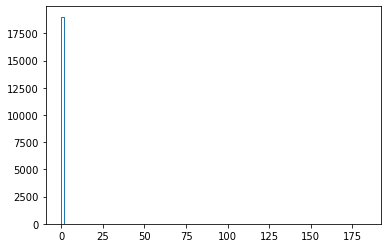

length 19444
length 19030



<Figure size 720x360 with 0 Axes>

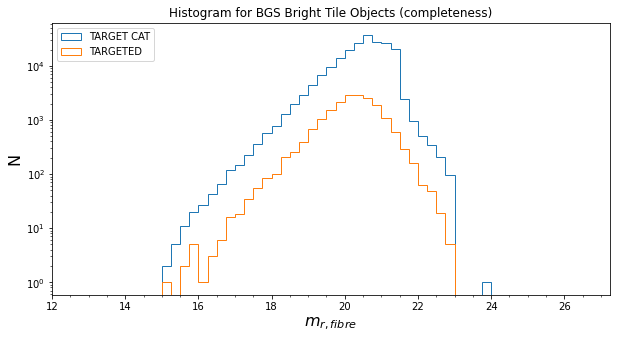

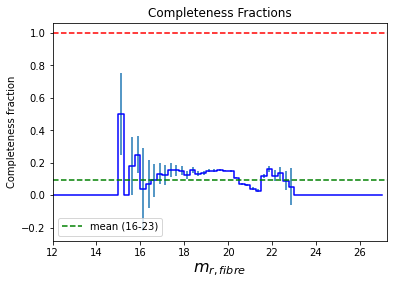

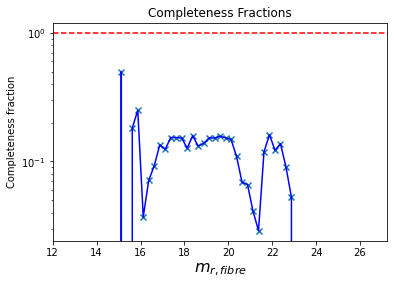

In [176]:
n_targets, n_targeted, frac_completeness, data_c, bins_c, popt_c = completeness(deep_bright_original, tile_split=False, fibre_mag=True, bin_equal=False)

In [123]:
def completeness(data, tile_split=False, fibre_mag=True, bin_equal=True):

    captargs_t = captargs
    print('before bad fibre cut:', len(data))
    data['NODATA'] = (data['ZWARN'] & 2**9) != 0
    badfibre = data['NODATA']
    data = data[~badfibre]
    print('after bad fibre cut:', len(data))
    
    if bin_equal == True:
        bin_edges = stats.mstats.mquantiles(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], np.arange(0, 1.0001, 0.1))
        bins_list = bin_edges
        bin_min = bins_list[5]
        bin_max = bins_list[-1]

    else:
        if fibre_mag == False:
            bin_min = 16.5
            bin_max = 19.5 # for mean
            bins_list = np.arange(12, 19.51, 0.25)

        else:
            bin_min = 16.5
            bin_max = 20.25 # for mean
            bins_list = np.arange(12, 27.1, 0.25)
    
    x_lim_max = bins_list[-1] + 0.25
    
    ''' 
    if tile_split == False:
        target_m = []
        for i in range(len(tile_array)):
            
            # exclude MWS objects
            captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
            
            captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_MWS_TARGET'] == 0]
            # ^^^^ testing this line
            
            
            if fibre_mag == False:
                target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
            if fibre_mag == True:
                target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
                
    target_m = np.array(target_m)
    '''
    
    if tile_split == False:
        target_m = []
        data_m_array = []
 
        for i in range(len(tile_array)):

            # exclude MWS objects
            #ct = captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]

            ct = captargs_t[str(tile_array[i])]
           # print('targets in full tile:', len(ct))

            ct = ct[ct['SV3_BGS_TARGET'] != 0]
            #print('SV3 BGS targets:', len(ct))            
            
            #ct = ct[ct['SV3_MWS_TARGET'] == 0]
            #print('targets after SV3 MWS exclusion:', len(ct))
            #print('')

            if fibre_mag == False:
                #ct = ct[ct['FLUX_R'] > 10**((22.5-19.5)/2.5)] # BGS_BRIGHT!!!!!!!
                target_m.extend(22.5 - 2.5*np.log10(ct['FLUX_R'] / mw_xtinct(ct['EBV'], band='R')))
            if fibre_mag == True:
                                
                #ct = ct[ct['FLUX_R'] > 10**((22.5-19.5)/2.5)] # BGS_BRIGHT
                #ct = ct[ct['FLUX_R'] > 10**((22.5-20.5)/2.5)]
                #ct = ct[ct['FLUX_R'] <= 10**((22.5-12.0)/2.5)]
                #ct = ct[ct['FIBERTOTFLUX_R'] > 0.6]  #10**((22.5-22.5)/2.5)]
                
                #data = data[data['FLUX_R'] > 10**((22.5-19.5)/2.5)]
               # data = data[data['FLUX_R'] > 10**((22.5-20.5)/2.5)]
                #ct = ct[ct['FLUX_R'] <= 10**((22.5-20.1)/2.5)]

                #data = data[data['FLUX_R'] > 10**((22.5-19.5)/2.5)]
                #data = data[data['FLUX_R'] > 10**((22.5-12.0)/2.5)]
                #data = data[data['FIBERTOTFLUX_R'] > 10**((22.5-20.1)/2.5)]
                
                #ct = ct[ct['FLUX_R'] > ct['FLUX_G'] * 10**(-1.0/2.5)]
                #ct = ct[ct['FLUX_R'] < ct['FLUX_G'] * 10**(4.0/2.5)]
                #ct = ct[ct['FLUX_Z'] > ct['FLUX_R'] * 10**(-1.0/2.5)]
                #ct = ct[ct['FLUX_Z'] < ct['FLUX_R'] * 10**(4.0/2.5)]
                #g = 22.5 - 2.5*np.log10(ct['FLUX_G'].clip(1e-16))
                #r = 22.5 - 2.5*np.log10(ct['FLUX_R'].clip(1e-16))
                #z = 22.5 - 2.5*np.log10(ct['FLUX_Z'].clip(1e-16))
                #w1 = 22.5 - 2.5*np.log10(ct['FLUX_W1'].clip(1e-16))
                #rfib = 22.5 - 2.5*np.log10(ct['FIBERFLUX_R'].clip(1e-16))
                
                '''
                ADD MATCHING SECTION - TARGETED TO TARGET CATALOGUE
                '''
                '''
                target_objs = SkyCoord(captargs[str(tile_array[i])]['RA'], captargs[str(tile_array[i])]['DEC'], frame='icrs', unit='deg')
                #targeted_objs = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
                data['SKYCOORD'] = SkyCoord(data['TARGET_RA'], data['TARGET_DEC'], frame='icrs', unit='deg')
                targeted_objs = data['SKYCOORD']

                idx, d2d, d3d = targeted_objs.match_to_catalog_sky(target_objs)
                plt.hist(d2d.arcsec, histtype='step', bins = 100)
                #plt.xlabel('separation [arcsec]')
                #plt.tight_layout()
                #plt.show()
                plt.clf()
        
                data['idx'] = idx
                data['d2d'] = d2d
                data['d3d'] = d3d

                max_sep = 1.0 * u.arcsec
                data_m = (data[data['d2d'] < max_sep])
                
                data_m.remove_columns(['SKYCOORD', 'idx', 'd2d', 'd3d'])
                
                data_m_array.append(data_m)'''
                
                
                
                
                
                target_m.extend(22.5 - 2.5*np.log10(ct['FIBERFLUX_R'] / mw_xtinct(ct['EBV'], band='R')))

                
        target_m = np.array(target_m)
        
        '''
        data_0 = data_m_array[0]
        for i in range(1, len(data_m_array)):
            data_0 = vstack([data_0, data_m_array[i]])
        '''
        
        
        print('target objects with apparent magnitudes:', len(target_m))
        print('targeted objects with apparent magnitudes:', len(data))
        
        # for mean calculation
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        n_targets_one, bins_one, patches_one = ax.hist(target_m[~np.isnan(target_m)], bins=np.array([bin_min, bin_max]), histtype='step', label='TARGET CAT')
        if fibre_mag == False:
            n_targeted_one, bins_one, patches_one = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='TARGETED')
        if fibre_mag == True:
            n_targeted_one, bins_one, patches_one = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='TARGETED')
        
        plt.clf()
        
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        
        n_targets, bins, patches = ax.hist(target_m[~np.isnan(target_m)], bins=bins_list, histtype='step', label='TARGET CAT')
        
        if fibre_mag == False:
            n_targeted, bins, patches = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=bins_list, histtype='step', label='TARGETED')
        if fibre_mag == True:
            n_targeted, bins, patches = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='TARGETED')
        
        
        ax.set_yscale('log')
        
        if fibre_mag == True:
            ax.set_xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            ax.set_xlabel(r'$m_r$', fontsize=16)
        ax.set_ylabel('N', fontsize=16)
        ax.minorticks_on()
        plt.title('Histogram for BGS Bright Tile Objects (completeness)')
        plt.legend(loc='upper left')
        plt.xlim(12, x_lim_max)
        plt.show()

        # calculate fraction
        frac_completeness = n_targeted / n_targets
        frac_completeness = np.nan_to_num(frac_completeness)
        plt.step(bins_list, [frac_completeness[0], *frac_completeness], color='b')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(12, x_lim_max)
        #plt.yscale('log')
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('Completeness fraction')
        plt.title('Completeness Fractions')

        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        
        frac_completeness_mean = np.mean(frac_completeness)
        yerr = np.sqrt(n_targeted*frac_completeness_mean*(1-frac_completeness_mean))/n_targeted
        plt.errorbar(mid, frac_completeness, yerr=yerr, fmt='none')
        #plt.axhline(y=np.mean(frac_completeness), color='b', linestyle='--')
        plt.axhline(y=np.mean(n_targeted_one/n_targets_one), color='g', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))
        plt.legend()
        plt.show()
        
        plt.plot(mid, frac_completeness, color='b')
        plt.scatter(mid, frac_completeness, marker='x')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(12, x_lim_max)
        plt.yscale('log')
        #plt.ylim(0, 1.2)
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('Completeness fraction')
        plt.title('Completeness Fractions')
        
        frac_completeness_mean = np.mean(frac_completeness)
        yerr = np.sqrt(n_targeted*frac_completeness_mean*(1-frac_completeness_mean))/n_targeted

        
        yerr_upper = np.zeros(len(mid))
        yerr_lower = np.zeros(len(mid))
        for i in range(len(mid)):
            if frac_completeness[i] + yerr[i] > 1:
                yerr_upper[i] = 1 - frac_completeness[i]
            else:
                yerr_upper[i] = yerr[i]

            if frac_completeness[i] - yerr[i] < 0:
                yerr_lower[i] = frac_completeness[i]
            else:
                yerr_lower[i] = yerr[i]

        plt.errorbar(mid, frac_completeness, yerr=[yerr_lower, yerr_upper], fmt='none')
        
        #plt.axhline(y=np.mean(frac_completeness), color='b', linestyle='--', label='mean (all)')
        
        bin_cut = bins_list[np.where(bins_list == bin_min)[0][0]: np.where(bins_list == bin_max)[0][0]+1]
        mid_cut = 0.5*(bin_cut[1:] + bin_cut[:-1])
        fc_cut = frac_completeness[np.where(bins_list == bin_min)[0][0]: np.where(bins_list == bin_max)[0][0]+0]
        
        print(fc_cut)
                      
        #plt.axhline(y=np.mean(fc_cut), color='g', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))
        plt.axhline(y=np.mean(n_targeted_one/n_targets_one), color='g', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))
        print('mean =', np.mean(n_targeted_one/n_targets_one))
        m, b = np.polyfit(mid_cut, fc_cut, 1)
        #plt.plot(bins_list, m*bins_list+b, label='linear regression ({}-{}, n=1)'.format(bin_min, bin_max))
        plt.legend()
        plt.show()
        
        
        return n_targets, n_targeted, frac_completeness, data, bins_list
    
    else:
        n_targeted_all = []
        n_targets_all = []
        frac_completeness_all = []
        
        for i in range(len(tile_array)):
            # exclude MWS objects
            captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
                
            if fibre_mag == False:
                target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
            if fibre_mag == True:
                target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
            
            target_m = np.array(target_m)
            
            data_ts = data[data['TILEID'] == tile_array[i]]
            print('target objects with apparent magnitudes:', len(target_m))
            print('targeted objects with apparent magnitudes:', len(data_ts))
    
            fig, ax = plt.subplots(1,1, figsize=(10,5))
            n_targets, bins, patches = ax.hist(target_m[~np.isnan(target_m)], bins=bins_list, histtype='step', label='TARGET CAT')
            
            if fibre_mag == False:
                n_targeted, bins, patches = ax.hist(data_ts['MODEL_MAG'][~np.isnan(data_ts['MODEL_MAG'])], bins=bins_list, histtype='step', label='TARGETED')
            if fibre_mag == True:
                n_targeted, bins, patches = ax.hist(data_ts['MODEL_FIBRE_MAG'][~np.isnan(data_ts['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='TARGETED')
            
            ax.set_yscale('log')
            ax.set_xlabel(r'$m_r$', fontsize=16)
            ax.set_ylabel('N', fontsize=16)
            ax.minorticks_on()
            plt.title('Histogram for BGS Bright Tile Objects (completeness)')
            plt.legend(loc='upper left')
            plt.xlim(12, 21)
            plt.show()
            
            # calculate fraction
            frac_completeness = n_targeted / n_targets
            frac_completeness = np.nan_to_num(frac_completeness)
            n_targeted_all.append(n_targeted)
            n_targets_all.append(n_targets)
            frac_completeness_all.append(frac_completeness)
            
            plt.step(bins_list, [frac_completeness[0], *frac_completeness], color='b', label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 21)
            plt.ylim(0, 1.2)
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('Completeness fraction')
            plt.legend()
            plt.title('Completeness Fractions')
    
    
            '''
            NEED TO FIX THIS MEAN
            '''
            mid = 0.5*(bins_list[1:] + bins_list[:-1])
            #yerr = np.sqrt(n_targeted*frac_completeness*(1-frac_completeness))/n_targeted # binomial: sd = [np(1-p)]^0.5
            frac_completeness_mean = np.mean(frac_completeness)
            yerr = np.sqrt(n_targeted*frac_completeness_mean*(1-frac_completeness_mean))/n_targeted
            
            plt.errorbar(mid, frac_completeness, yerr=yerr, fmt='none')
            plt.axhline(y=np.mean(frac_completeness), color='b', linestyle='--')
            plt.show()
            
        for i in range(len(frac_completeness_all)):
            plt.step(bins_list, [frac_completeness_all[i][0], *frac_completeness_all[i]], label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 21)
            #plt.ylim(0, 1.2)
            plt.yscale('log')
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('Completeness fraction')
            plt.legend(bbox_to_anchor=(1.05, 1))
            plt.title('Completeness Fractions')
        plt.show()
        
        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        #step_size = bins_list[1] - bins_list[0]
        for i in range(len(frac_completeness_all)):
            plt.plot(mid, frac_completeness_all[i], label=tile_array[i])
            #plt.plot(bins_list-(step_size/2), [frac_completeness_all[i][0], *frac_completeness_all[i]], label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 21)
            #plt.ylim(0, 1.2)
            plt.yscale('log')
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('Completeness fraction')
            plt.legend(bbox_to_anchor=(1.05, 1))
            plt.title('Completeness Fractions')
        plt.show()
        
        return n_targets_all, n_targeted_all, frac_completeness_all, data

before bad fibre cut: 23308
after bad fibre cut: 19444
target_objs 206735


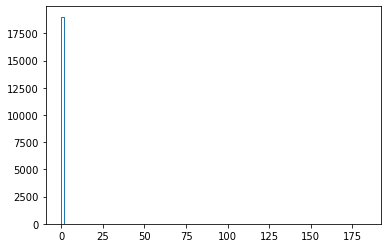

length 19444
length 19030



<Figure size 720x360 with 0 Axes>

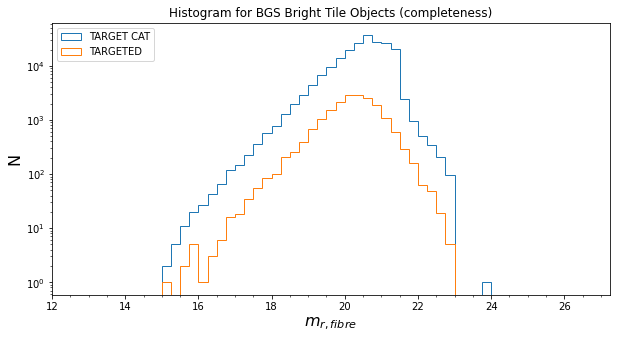

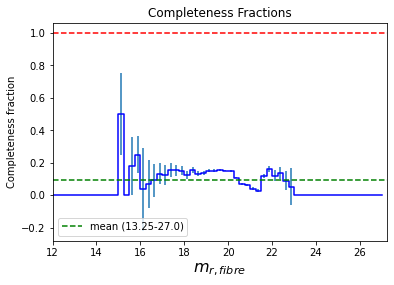

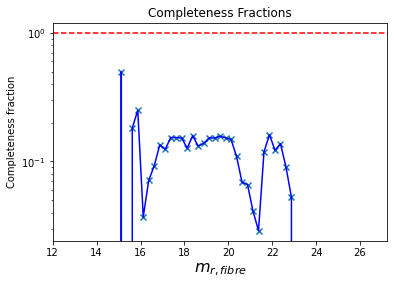

In [160]:
n_targets, n_targeted, frac_completeness, data_c, bins_c = completeness(deep_bright_original, tile_split=False, fibre_mag=True, bin_equal=False)


In [58]:
'''
for i in range(len(n_targets)):
    plt.step(bins_list, [n_targets[i][0], *n_targets[i]], label=tile_array[i])
    plt.xlim(12, 21)
    #plt.ylim(0, 1.2)
    plt.yscale('log')
    plt.xlabel(r'$m_r$')
    plt.ylabel(r'$n_{targets}$')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title('Plot of Target Objects')
plt.show()

for i in range(len(n_targeted)):
    plt.step(bins_list, [n_targeted[i][0], *n_targeted[i]], label=tile_array[i])
    plt.xlim(12, 21)
    #plt.ylim(0, 1.2)
    plt.yscale('log')
    plt.xlabel(r'$m_r$')
    plt.ylabel(r'$n_{targeted}$')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title('Plot of Targeted Objects')
plt.show()

'''

"\nfor i in range(len(n_targets)):\n    plt.step(bins_list, [n_targets[i][0], *n_targets[i]], label=tile_array[i])\n    plt.xlim(12, 21)\n    #plt.ylim(0, 1.2)\n    plt.yscale('log')\n    plt.xlabel(r'$m_r$')\n    plt.ylabel(r'$n_{targets}$')\n    plt.legend(bbox_to_anchor=(1.05, 1))\n    plt.title('Plot of Target Objects')\nplt.show()\n\nfor i in range(len(n_targeted)):\n    plt.step(bins_list, [n_targeted[i][0], *n_targeted[i]], label=tile_array[i])\n    plt.xlim(12, 21)\n    #plt.ylim(0, 1.2)\n    plt.yscale('log')\n    plt.xlabel(r'$m_r$')\n    plt.ylabel(r'$n_{targeted}$')\n    plt.legend(bbox_to_anchor=(1.05, 1))\n    plt.title('Plot of Targeted Objects')\nplt.show()\n\n"

In [59]:
'''
plt.hist(deep['ZWARN'], bins=50)
plt.xlabel('ZWARN Flag')
plt.ylabel('N')
plt.title('ZWARN Values for Deep')

plt.hist(deep_bright_original['ZWARN'], bins=50)
plt.xlabel('ZWARN Flag')
plt.ylabel('N')
plt.title('ZWARN Values for Deep Bright')

unique, counts = np.unique(deep_bright_original['ZWARN'], return_counts=True)

unique_string = []
for i in range(len(unique)):
    unique_string.append(str(unique[i]))

dictionary = dict(zip(unique_string, counts))
plt.bar(dictionary.keys(), dictionary.values())

for index,data in enumerate(dictionary.values()):
    plt.text(x=index , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=10), ha='eer')
    
plt.xlabel('ZWARN flags')
plt.ylabel('N')
plt.title('Bar Chart of ZWARN Flag Distribution (Deep Bright)')
'''

'\nplt.hist(deep[\'ZWARN\'], bins=50)\nplt.xlabel(\'ZWARN Flag\')\nplt.ylabel(\'N\')\nplt.title(\'ZWARN Values for Deep\')\n\nplt.hist(deep_bright_original[\'ZWARN\'], bins=50)\nplt.xlabel(\'ZWARN Flag\')\nplt.ylabel(\'N\')\nplt.title(\'ZWARN Values for Deep Bright\')\n\nunique, counts = np.unique(deep_bright_original[\'ZWARN\'], return_counts=True)\n\nunique_string = []\nfor i in range(len(unique)):\n    unique_string.append(str(unique[i]))\n\ndictionary = dict(zip(unique_string, counts))\nplt.bar(dictionary.keys(), dictionary.values())\n\nfor index,data in enumerate(dictionary.values()):\n    plt.text(x=index , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=10), ha=\'eer\')\n    \nplt.xlabel(\'ZWARN flags\')\nplt.ylabel(\'N\')\nplt.title(\'Bar Chart of ZWARN Flag Distribution (Deep Bright)\')\n'

In [170]:
def sigmoid_func1(x, a, b):
    y = 1 / (1+np.exp(a*(x-b)))
    return y

def sigmoid_func2(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y
    
def z_success(data, tile_split=False, bin_equal=False, deltachi2=None, spectype=None, z_min=None, z_max=None, zwarn=None, zerr=None, hist_counts=True, fibre_mag=True):
    
    zsuccess_data = data
        
    if deltachi2 != None:
        zsuccess_data = zsuccess_data[zsuccess_data['DELTACHI2'] > deltachi2]

    if spectype != None:
        zsuccess_data = zsuccess_data[zsuccess_data['SPECTYPE'] == spectype]
        
    if z_min != None:
        zsuccess_data = zsuccess_data[zsuccess_data['Z'] > z_min]
            
    if z_max != None:
        zsuccess_data = zsuccess_data[zsuccess_data['Z'] < z_max]
    
    if zwarn != None:
        zsuccess_data = zsuccess_data[zsuccess_data['ZWARN'] == 0]
        
    if zerr != None:
        zsuccess_data = zsuccess_data[zsuccess_data['ZERR'] < (0.0005 * (1. + zsuccess_data['Z']))]
        
    print('original data input:', len(data), 'objects')
    print('z-success data:', len(zsuccess_data), 'objects')
        
    if bin_equal == True:
        bin_edges = stats.mstats.mquantiles(zsuccess_data['MODEL_FIBRE_MAG'][~np.isnan(zsuccess_data['MODEL_FIBRE_MAG'])], np.arange(0, 1.0001, 0.1))
        bins_list = bin_edges
        bin_min = bins_list[5]
        bin_max = bins_list[-1]
    
    else:
        #bin_min = 18 # for mean calculation
        if fibre_mag==False:
            bins_list = np.arange(12, 20.51, 0.25)
            #bin_max = 19.5 # for mean calculation
            bin_min = bins_list[0]
            bin_max = bins_list[-1]
            
        else:
            bins_list = np.arange(12, 27.1, 0.25)
            #bin_min = bins_list[0]
            bin_min = 18
            bin_max = bins_list[-1]
            #bin_max = 20.5 # for mean calculation

    x_lim_max = bins_list[-1] + 0.25

    if tile_split == False:
        if hist_counts == True:
            number_counts(zsuccess_data, nbins=50, z=True, app_mag=False)

        # for mean calculation
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        if fibre_mag==False:
            n_all_one, bins_one, patches_one = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='ALL')
            n_zsuccess_one, bins_one, patches_one = ax.hist(zsuccess_data['MODEL_MAG'][~np.isnan(zsuccess_data['MODEL_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='Z-SUCCESS')

        if fibre_mag==True:
            n_all_one, bins_one, patches_one = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='ALL')
            n_zsuccess_one, bins_one, patches_one = ax.hist(zsuccess_data['MODEL_FIBRE_MAG'][~np.isnan(zsuccess_data['MODEL_FIBRE_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='Z-SUCCESS')
        
        plt.clf()
        
        # for regular bin calculation
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        if fibre_mag==False:
            n_all, bins, patches = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=bins_list, histtype='step', label='ALL')
            n_zsuccess, bins, patches = ax.hist(zsuccess_data['MODEL_MAG'][~np.isnan(zsuccess_data['MODEL_MAG'])], bins=bins_list, histtype='step', label='Z-SUCCESS')

        if fibre_mag==True:
            n_all, bins, patches = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='ALL')
            n_zsuccess, bins, patches = ax.hist(zsuccess_data['MODEL_FIBRE_MAG'][~np.isnan(zsuccess_data['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='Z-SUCCESS')
        
        ax.set_yscale('log')
        if fibre_mag == True:
            ax.set_xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            ax.set_xlabel(r'$m_r$', fontsize=16)
        ax.set_ylabel('N', fontsize=16)
        ax.minorticks_on()
        plt.title('Histogram for BGS Bright Tile Objects (z-success)')
        plt.legend(loc='upper left')
        plt.show()

        # calculate fraction
        frac_zsuccess = n_zsuccess / n_all
        frac_zsuccess = np.nan_to_num(frac_zsuccess)
        plt.step(bins_list, [frac_zsuccess[0], *frac_zsuccess], color='b', label='all')
        plt.axhline(y=n_zsuccess_one/n_all_one, color='b', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(12, x_lim_max)
        plt.ylim(0.6, 1.1)
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('z-success fraction')
        plt.legend()
        plt.title('z-success Fractions')
        plt.show()

        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        
        plt.plot(mid, frac_zsuccess, color='b', label='all')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(12, x_lim_max)
        plt.ylim(0, 1.05)
        #plt.yscale('log')
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('z-success fraction')
        plt.legend()
        plt.title('z-success Fractions')
        
        zsuccess_mean = np.mean(frac_zsuccess)
        yerr = np.sqrt(n_zsuccess*zsuccess_mean*(1-zsuccess_mean))/n_zsuccess
        yerr_upper = np.zeros(len(mid))
        yerr_lower = np.zeros(len(mid))
        for i in range(len(mid)):
            if frac_zsuccess[i] + yerr[i] > 1:
                yerr_upper[i] = 1 - frac_zsuccess[i]
            else:
                yerr_upper[i] = yerr[i]

            if frac_zsuccess[i] - yerr[i] < 0:
                yerr_lower[i] = frac_zsuccess[i]
            else:
                yerr_lower[i] = yerr[i]

        plt.errorbar(mid, frac_zsuccess, yerr=[yerr_lower, yerr_upper], fmt='none')
        plt.axhline(y=n_zsuccess_one/n_all_one, color='b', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))

        #plt.axhline(y=n_zsuccess_one/n_all_one, color='b', linestyle='--', label='mean (all)')

        bin_cut = bins_list[np.where(bins_list == bin_min)[0][0]: np.where(bins_list == bin_max)[0][0]+1]
        mid_cut = 0.5*(bin_cut[1:] + bin_cut[:-1])
        fz_cut = frac_zsuccess[np.where(bins_list == bin_min)[0][0]: np.where(bins_list == bin_max)[0][0]]

        #m, b = np.polyfit(bin_cut, fz_cut, 1)
        #plt.plot(bins_list, m*bins_list+b, label='linear regression (16.5-19.5, n=1)')
        plt.legend()
        plt.show()


        ''' sigmoid plot work'''
        xdata = mid_cut
        ydata = fz_cut
        xrange = np.arange(18.0, 26.5, 0.0001)

        p0 = [np.median(ydata), max(ydata)*np.median(xdata)]
        popt1, pcov = curve_fit(sigmoid_func1, xdata, ydata, p0, maxfev=50000, method='dogbox')
        plt.plot(xdata, ydata)
        plt.scatter(xdata, ydata, marker='x')
        y_sig1 = sigmoid_func1(xrange, *popt1)
        plt.plot(xrange, y_sig1, label='a=%.3f, b=%.3f' % (popt1[0], popt1[1]))
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('z-success fraction')
        plt.title('Two parameter sigmoid fit')
        plt.legend()
        plt.show()
        print(popt1)
        
        p0 = [max(ydata), np.median(xdata), 1, min(ydata)]
        popt2, pcov = curve_fit(sigmoid_func2, xdata, ydata, p0, maxfev=50000, method='dogbox')
        plt.plot(xdata, ydata)
        plt.scatter(xdata, ydata, marker='x')
        y_sig2 = sigmoid_func2(xrange, *popt2)
        plt.plot(xrange, y_sig2, label='L=%.3f, x0=%.3f, k=%.3f, b=%.3f' % (popt2[0], popt2[1], popt2[2], popt2[3]))
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('z-success fraction')
        plt.title('Four parameter sigmoid fit')
        plt.legend()
        plt.show()
        print(popt2)
        
        
        '''two-parameter model'''
        plt.plot(xrange, y_sig1, label='a=%.3f, b=%.3f' % (popt1[0], popt1[1]))
        #plt.plot(xdata, sigmoid_func2(xdata, *popt), label='L=%.3f, x0=%.3f, k=%.3f, b=%.3f' % (popt[0], popt[1], popt[2], popt[3]))
        plt.plot(mid, frac_zsuccess, color='b')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(17.75, x_lim_max)
        plt.ylim(0, 1.0)
        #plt.yscale('log')
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('z-success fraction')
        plt.legend()
        plt.title('z-success Fractions')

        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        zsuccess_mean = np.mean(frac_zsuccess)
        yerr = np.sqrt(n_zsuccess*zsuccess_mean*(1-zsuccess_mean))/n_zsuccess
        plt.errorbar(mid, frac_zsuccess, yerr=yerr, fmt='none')
        plt.show()
        
        chisq, p = stats.chisquare(f_obs=frac_zsuccess, f_exp=sigmoid_func1(mid, *popt1))
        print('chisq', chisq)
        print('p-value', p)
        
        
        '''four-parameter model'''
        plt.plot(xrange, y_sig2, label='L=%.3f, x0=%.3f, k=%.3f, b=%.3f' % (popt2[0], popt2[1], popt2[2], popt2[3]))
        #plt.plot(xdata, sigmoid_func2(xdata, *popt), label='L=%.3f, x0=%.3f, k=%.3f, b=%.3f' % (popt[0], popt[1], popt[2], popt[3]))
        plt.plot(mid, frac_zsuccess, color='b')
        plt.axhline(1, color='r', linestyle='--')    
        plt.xlim(17.75, x_lim_max)
        plt.ylim(0, 1.0)
        #plt.yscale('log')
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('z-success fraction')
        plt.legend()
        plt.title('z-success Fractions')

        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        zsuccess_mean = np.mean(frac_zsuccess)
        yerr = np.sqrt(n_zsuccess*zsuccess_mean*(1-zsuccess_mean))/n_zsuccess
        plt.errorbar(mid, frac_zsuccess, yerr=yerr, fmt='none')
        #plt.axhline(y=n_zsuccess_one/n_all_one, color='b', linestyle='--', label='mean ({}-{})'.format(bin_min, bin_max))
        plt.show()
        
        chisq, p = stats.chisquare(f_obs=frac_zsuccess, f_exp=sigmoid_func2(mid, *popt2))
        print('chisq', chisq)
        print('p-value', p)
        
        popt_z = popt1 # using two-parameter model
        
        return n_zsuccess, frac_zsuccess, zsuccess_data, bins_list, popt_z
      
    
    else:
        n_complete_all = []
        n_zsuccess_all = []
        frac_zsuccess_all = []
        
        for i in range(len(tile_array)):        
            zsuccess_data_ts = data[data['TILEID'] == tile_array[i]]
            data_ts = zsuccess_data_ts
            
            zsuccess_data_ts['NODATA'] = (zsuccess_data_ts['ZWARN'] & 2**9) != 0
            badfibre = zsuccess_data_ts['NODATA']
            zsuccess_data_ts = zsuccess_data_ts[~badfibre]

            if deltachi2 != None:
                zsuccess_data_ts = zsuccess_data_ts[zsuccess_data_ts['DELTACHI2'] > deltachi2]

            if spectype != None:
                zsuccess_data_ts = zsuccess_data_ts[zsuccess_data_ts['SPECTYPE'] == spectype]

            if z_min != None:
                zsuccess_data_ts = zsuccess_data_ts[zsuccess_data_ts['Z'] > z_min]

            if z_max != None:
                zsuccess_data_ts = zsuccess_data_ts[zsuccess_data_ts['Z'] < z_max]

            if zwarn != None:
                zsuccess_data_ts = zsuccess_data_ts[zsuccess_data_ts['ZWARN'] == 0]

            if zerr != None:
                zsuccess_data_ts = zsuccess_data_ts[zsuccess_data_ts['ZERR'] < (0.0005 * (1. + zsuccess_data_ts['Z']))]

            print('original data input:', len(data), 'objects')
            print('z-success data:', len(zsuccess_data_ts), 'objects')

            if hist_counts == True:
                number_counts(zsuccess_data_ts, nbins=50, z=True, app_mag=False)

            fig, ax = plt.subplots(1,1, figsize=(10,5))
            
            if fibre_mag == False:
                n_all, bins, patches = ax.hist(data_ts['MODEL_MAG'][~np.isnan(data_ts['MODEL_MAG'])], bins=bins_list, histtype='step', label='ALL')
                n_zsuccess, bins, patches = ax.hist(zsuccess_data_ts['MODEL_MAG'][~np.isnan(zsuccess_data_ts['MODEL_MAG'])], bins=bins_list, histtype='step', label='Z-SUCCESS')
            
            if fibre_mag == True:
                n_all, bins, patches = ax.hist(data_ts['MODEL_FIBRE_MAG'][~np.isnan(data_ts['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='ALL')
                n_zsuccess, bins, patches = ax.hist(zsuccess_data_ts['MODEL_FIBRE_MAG'][~np.isnan(zsuccess_data_ts['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='Z-SUCCESS')
            
            ax.set_yscale('log')
            ax.set_xlabel(r'$m_r$', fontsize=16)
            ax.set_ylabel('N', fontsize=16)
            ax.minorticks_on()
            plt.title('Histogram for BGS Bright Tile Objects (z-success)')
            plt.legend(loc='upper left')
            plt.show()

            # calculate fraction
            frac_zsuccess = n_zsuccess / n_all
            frac_zsuccess = np.nan_to_num(frac_zsuccess)
            
            n_complete_all.append(n_all)
            n_zsuccess_all.append(n_zsuccess)
            frac_zsuccess_all.append(frac_zsuccess)
            
            '''
            plt.step(bins_list, [frac_zsuccess[0], *frac_zsuccess], color='b', label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 20)
            plt.ylim(0.6, 1.1)
            plt.xlabel(r'$m_r$')
            plt.ylabel('z-success fraction')
            plt.legend()
            plt.title('z-success Fractions')
            plt.show() 
        
        for i in range(len(frac_zsuccess_all)):
            plt.step(bins_list, [frac_zsuccess_all[i][0], *frac_zsuccess_all[i]], label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 21)
            #plt.ylim(0, 1.2)
            plt.yscale('log')
            plt.xlabel(r'$m_r$')
            plt.ylabel('z-success fraction')
            plt.legend(bbox_to_anchor=(1.05, 1))
            plt.title('z-success Fractions')
        plt.show()   
            '''
        for i in range(len(frac_zsuccess_all)):
            plt.plot(bins_list, [frac_zsuccess_all[i][0], *frac_zsuccess_all[i]], label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 21)
            #plt.ylim(0, 1.2)
            plt.yscale('log')
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('z-success fraction')
            plt.legend(bbox_to_anchor=(1.05, 1))
            plt.title('z-success Fractions')
        plt.show()   
        
        
        '''
        FIGURE THIS OUT
        '''
        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        step_size = bins_list[1] - bins_list[0]
        for i in range(len(frac_zsuccess_all)):
            plt.step(bins_list-(step_size / 2), [frac_zsuccess_all[i][0], *frac_zsuccess_all[i]], color='b', label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 21)
            plt.ylim(0, 1.2)
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('z-success fraction')
            plt.legend(bbox_to_anchor=(1.05, 1))
            plt.title('z-success Fractions')
        plt.show()   
        
        
        return n_complete_all, n_zsuccess_all, frac_zsuccess_all

before bad fibre cut: 23308
after bad fibre cut: 19444
target_objs 206735


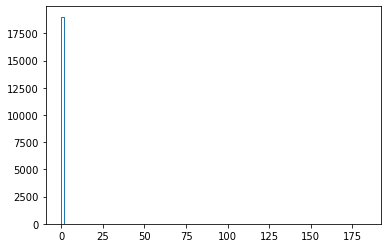

length 19444
length 19030


<Figure size 720x360 with 0 Axes>

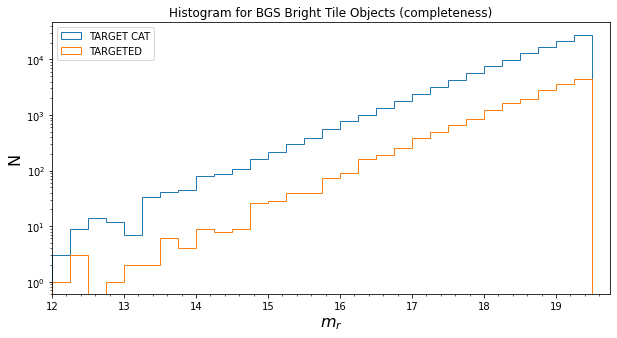

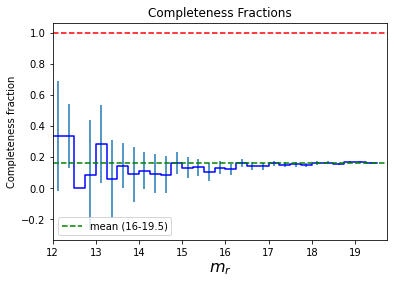

original data input: 19030 objects
z-success data: 17289 objects


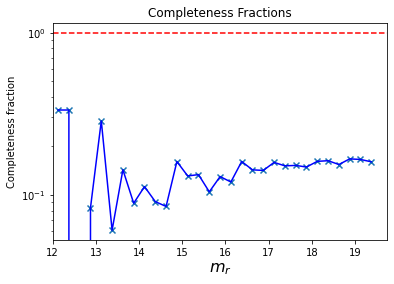

<Figure size 720x360 with 0 Axes>

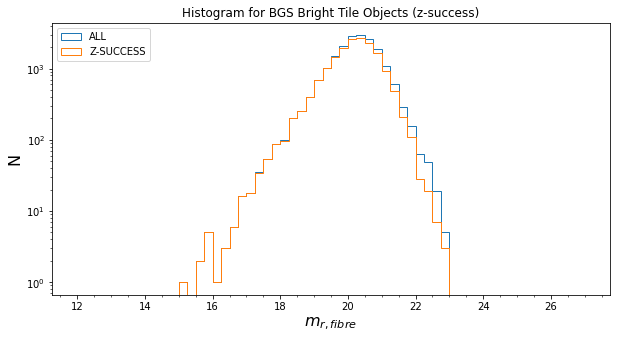

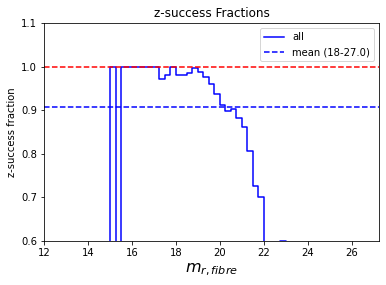

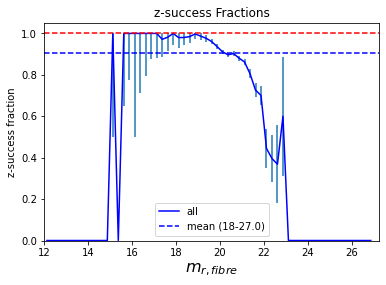

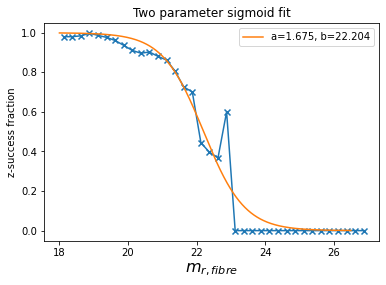

[ 1.6754526  22.20404099]


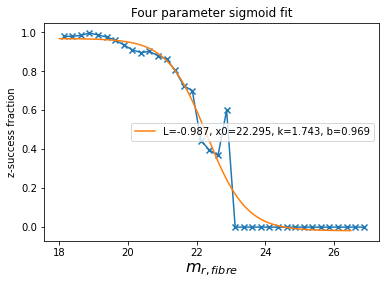

[-0.98743812 22.295197    1.74292748  0.96886753]


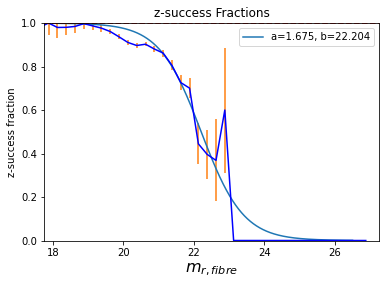

chisq 14.110193468870035
p-value 0.9999999997507631


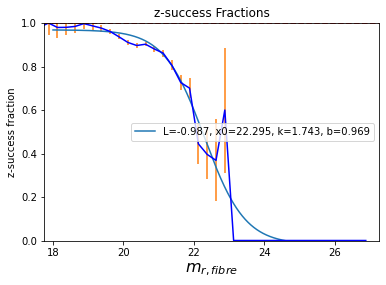

chisq 13.437596299573029
p-value 0.9999999999185516
spectype cut 213
cz cut 17289
cz cut and spectype 213


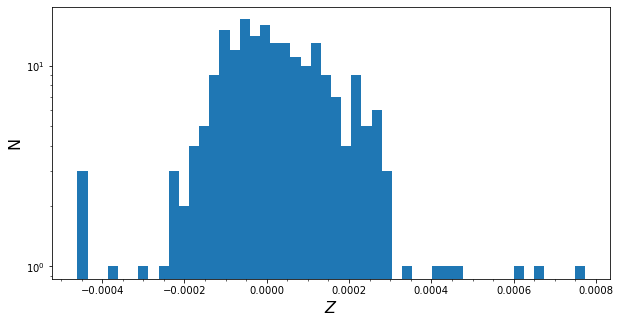

original data input: 17289 objects
stars with selection cut(s): 213 objects


<Figure size 720x360 with 0 Axes>

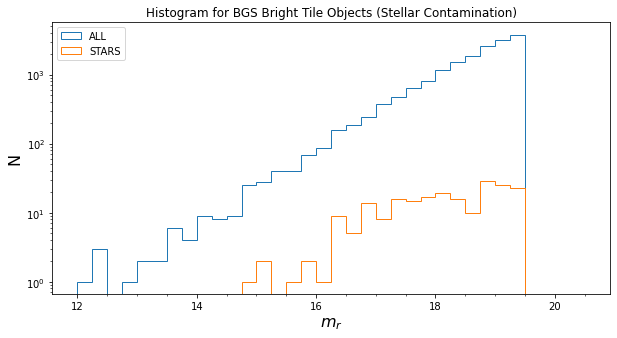

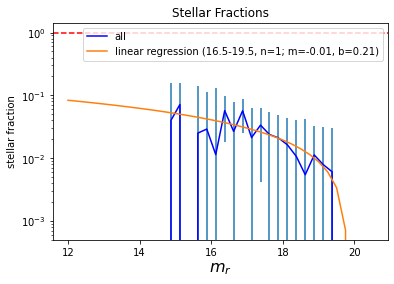

In [177]:
n_targets, n_targeted, frac_completeness, data_c, bins_c, popt_c = completeness(deep_bright_original, tile_split=False, fibre_mag=False, bin_equal=False)
n_zsuccess, frac_zsuccess, zsuccess_data, bins_z, popt_z = z_success(data_c, tile_split=False, bin_equal=False, deltachi2=40, spectype=None, z_min=min_z, z_max=max_z, zwarn=True, zerr=True, hist_counts=False, fibre_mag=True)
frac_stellar, frac_galaxy, bins_list, popt_s = stellar_func(zsuccess_data, tile_split=False, histcounts=True, fibre_mag=False, bin_equal=False)


In [180]:
popt_s

array([-0.01066482,  0.21133954])

In [169]:
def double_exp_func(x, a, b):
    y = a / (np.exp(x+b) + np.exp(-(x+b))) + 1
    return y

def double_exp_func2(x, a, b, c):
    y = 1 - abs(2*np.cos(a) / (np.exp(b*x+c) + np.exp(-(b*x+c))))
    return y

def stellar_func(data, tile_split=False, histcounts=True, fibre_mag=True, bin_equal=False):
        
    c = 3*10**5 # km/s
    data['cz'] = data['Z'] * c
    
    if bin_equal == True:
        bin_edges = stats.mstats.mquantiles(zsuccess_data['MODEL_FIBRE_MAG'][~np.isnan(zsuccess_data['MODEL_FIBRE_MAG'])], np.arange(0, 1.0001, 1/10))
        bins_list = bin_edges
        bin_min = bins_list[0]
        bin_max = bins_list[-1]
    
    else:
        bins_list = np.arange(12, 20.51, 0.25)
        bin_min = 16
        if fibre_mag==False:
            bin_max = 19.5
        else:

            bins_list = np.arange(12, 27.1, 0.25)
            #bin_max = 20.5
            bin_min = bins_list[0]
            bin_max = bins_list[-1]
            
    if tile_split == False:
        data_stars = data[data['SPECTYPE'] == 'STAR']
        data_galaxy = data[data['SPECTYPE'] == 'GALAXY']
        
        print('spectype cut', len(data_stars))
        
        data_stars = data_stars[data_stars['cz'] < 500]
        
        print('cz cut', len(data['cz']))
        print('cz cut and spectype', len(data_stars))
        
        if histcounts == True:
            number_counts(data_stars, nbins=50, z=True, app_mag=False)

        print('original data input:', len(data), 'objects')
        print('stars with selection cut(s):', len(data_stars), 'objects')
        
        # for mean calculation
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        if fibre_mag==False:
            n_all_one, bins_one, patches_one = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='ALL')
            n_stars_one, bins_one, patches_one = ax.hist(data_stars['MODEL_MAG'][~np.isnan(data_stars['MODEL_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='STARS')

        if fibre_mag==True:
            n_all_one, bins_one, patches_one = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='ALL')
            n_stars_one, bins_one, patches_one = ax.hist(data_stars['MODEL_FIBRE_MAG'][~np.isnan(data_stars['MODEL_FIBRE_MAG'])], bins=np.array([bin_min, bin_max]), histtype='step', label='STARS')
                
        plt.clf()
        
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        if fibre_mag == False:
            n_all, bins, patches = ax.hist(data['MODEL_MAG'][~np.isnan(data['MODEL_MAG'])], bins=bins_list, histtype='step', label='ALL')
            n_stars, bins, patches = ax.hist(data_stars['MODEL_MAG'][~np.isnan(data_stars['MODEL_MAG'])], bins=bins_list, histtype='step', label='STARS')

        if fibre_mag == True:
            n_all, bins, patches = ax.hist(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='ALL')
            n_stars, bins, patches = ax.hist(data_stars['MODEL_FIBRE_MAG'][~np.isnan(data_stars['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='STARS')
        
        ax.set_yscale('log')
        if fibre_mag == True:
            ax.set_xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            ax.set_xlabel(r'$m_r$', fontsize=16)
        ax.set_ylabel('N', fontsize=16)
        ax.minorticks_on()
        plt.title('Histogram for BGS Bright Tile Objects (Stellar Contamination)')
        plt.legend(loc='upper left')
        plt.show()

        frac_stellar = n_stars / n_all
        frac_stellar = np.nan_to_num(frac_stellar)

        frac_galaxy = np.subtract(n_all, n_stars) / n_all
        frac_galaxy = np.nan_to_num(frac_galaxy)

        mid = 0.5*(bins_list[1:] + bins_list[:-1])
        plt.plot(mid, frac_stellar, color='b', label='all')
        plt.axhline(1, color='r', linestyle='--')    
        #plt.xlim(12, 21)
        #plt.ylim(0, 1.2)
        plt.yscale('log')
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('stellar fraction')
        plt.title('Stellar Fractions')
        
        fracstellar_mean = np.mean(frac_stellar)
        yerr = np.sqrt(n_stars*fracstellar_mean*(1-fracstellar_mean))/n_stars
        yerr_upper = np.zeros(len(mid))
        yerr_lower = np.zeros(len(mid))
        for i in range(len(mid)):
            if frac_stellar[i] + yerr[i] > 1:
                yerr_upper[i] = 1-frac_stellar[i]
            else:
                yerr_upper[i] = yerr[i]

            if frac_stellar[i] - yerr[i] < 0:
                yerr_lower[i] = frac_stellar[i]
            else:
                yerr_lower[i] = yerr[i]

        plt.errorbar(mid, frac_stellar, yerr=[yerr_lower, yerr_upper], fmt='none')
        
        bin_cut = bins_list[np.where(bins_list == bin_min)[0][0]: np.where(bins_list == bin_max)[0][0]+1]
        mid_cut = 0.5*(bin_cut[1:] + bin_cut[:-1])
        fst_cut = frac_stellar[np.where(bins_list == bin_min)[0][0]: np.where(bins_list == bin_max)[0][0]]
        
        # mean:
        #plt.axhline(y=n_stars_one/n_all_one, color='b', linestyle='--', label='mean {}-{}'.format(bin_min, bin_max))

        
        m, b = np.polyfit(mid_cut, fst_cut, 1)
        plt.plot(bins_list, m*bins_list+b, label='linear regression (16.5-19.5, n=1; m={:.2f}, b={:.2f})'.format(m,b))
        plt.legend()
        plt.show()
        
        popt_s = np.array([m, b])
        
        '''           
        #exp fitting plot work
        xdata = mid_cut
        ydata = fst_cut
        xrange = np.arange(13.0, 26.0, 0.0001)

        p0 = [-1.75, -20]
        popt1, pcov = curve_fit(double_exp_func, xdata, ydata, p0, maxfev=50000, method='dogbox')
        plt.plot(xdata, ydata)
        plt.scatter(xdata, ydata, marker='x')
        y_sig1 = double_exp_func(xrange, *popt1)
        plt.plot(xrange, y_sig1, label='a=%.3f, b=%.3f' % (popt1[0], popt1[1]))
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('stellar fraction')
        plt.title('Double exponential function fit')
        plt.legend()
        plt.show()
        print(popt1)
        
     
        #exp fitting plot work
        if bin_equal==True:
            xdata2 = mid_cut
            ydata2 = fst_cut
        else:
            # variable!!!!
            xdata2 = mid_cut[12:-12]
            ydata2 = fst_cut[12:-12]
        xrange = np.arange(13.0, 26.0, 0.0001)

        p0 = [0, 1, -21]
        popt2, pcov = curve_fit(double_exp_func2, xdata2, ydata2, p0, maxfev=50000, method='dogbox')
        plt.plot(xdata, ydata)
        plt.scatter(xdata, ydata, marker='x')
        y_sig1 = double_exp_func2(xrange, *popt2)
        plt.plot(xrange, y_sig1, label='a=%.3f, b=%.3f, c=%.3f' % (popt2[0], popt2[1], popt2[2]))
        if fibre_mag == True:
            plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
        else:
            plt.xlabel(r'$m_r$', fontsize=16)
        plt.ylabel('stellar fraction')
        plt.title('Double exponential function fit')
        plt.legend()
        plt.show()
        print(popt2)'''
        
        
        
        return frac_stellar, frac_galaxy, bins_list, popt_s
    
    else:
        n_stars_all = []
        frac_stellar_all = []
        frac_galaxy_all = []
    
        for i in range(len(tile_array)):        
            data_ts = data[data['TILEID'] == tile_array[i]]
            data_stars = data_ts[data_ts['SPECTYPE'] == 'STAR']
            data_galaxy = data_ts[data_ts['SPECTYPE'] == 'GALAXY']
    
            '''
            add cz < 200kms-1 to this section
            '''
    
            if histcounts == True:
                number_counts(data_stars, nbins=50, z=True, app_mag=False)

            print('original data input:', len(data), 'objects')
            print('stars with selection cut(s):', len(data_stars), 'objects')

            fig, ax = plt.subplots(1,1, figsize=(10,5))
            if fibre_mag == False:
                n_all, bins, patches = ax.hist(data_ts['MODEL_MAG'][~np.isnan(data_ts['MODEL_MAG'])], bins=bins_list, histtype='step', label='ALL')
                n_stars, bins, patches = ax.hist(data_stars['MODEL_MAG'][~np.isnan(data_stars['MODEL_MAG'])], bins=bins_list, histtype='step', label='STARS')
            
            if fibre_mag == True:
                n_all, bins, patches = ax.hist(data_ts['MODEL_FIBRE_MAG'][~np.isnan(data_ts['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='ALL')
                n_stars, bins, patches = ax.hist(data_stars['MODEL_FIBRE_MAG'][~np.isnan(data_stars['MODEL_FIBRE_MAG'])], bins=bins_list, histtype='step', label='STARS')
            
            ax.set_yscale('log')
            ax.set_xlabel(r'$m_r$', fontsize=16)
            ax.set_ylabel('N', fontsize=16)
            ax.minorticks_on()
            plt.title('Histogram for BGS Bright Tile Objects (Stellar Contamination)')
            plt.legend(loc='upper left')
            plt.show()

            frac_stellar = n_stars / n_all
            frac_stellar = np.nan_to_num(frac_stellar)
            
            frac_galaxy = np.subtract(n_all, n_stars) / n_all
            frac_galaxy = np.nan_to_num(frac_galaxy)
            
            n_stars_all.append(n_stars)
            frac_stellar_all.append(frac_stellar)
            frac_galaxy_all.append(frac_galaxy)
            
            plt.step(bins_list, [frac_stellar[0], *frac_stellar], color='b', label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 20)
            plt.ylim(0, 1.2)
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('stellar fraction')
            plt.title('Stellar Fractions')
            plt.legend()
            plt.show()
          
        
            '''
            FIGURE THIS OUT
            '''
            mid = 0.5*(bins_list[1:] + bins_list[:-1])
            step_size = bins_list[1] - bins_list[0]
        for i in range(len(frac_stellar_all)):
            plt.plot(bins_list - (step_size/2), [frac_stellar_all[0][i], *frac_stellar_all[i]], label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 20)
            plt.ylim(0, 1.2)
            #plt.yscale('log')
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('stellar fraction')
            plt.title('Stellar Fractions')
            plt.legend()
        plt.show()
        
        for i in range(len(frac_stellar_all)):
            plt.plot(bins_list - (step_size/2), [frac_stellar_all[0][i], *frac_stellar_all[i]], label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 20)
            #plt.ylim(0, 1.2)
            plt.yscale('log')
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('stellar fraction')
            plt.title('Stellar Fractions')
            plt.legend()
        plt.show()

        for i in range(len(frac_stellar_all)):
            plt.step(bins_list, [frac_stellar_all[0][i], *frac_stellar_all[i]], color='b', label=tile_array[i])
            plt.axhline(1, color='r', linestyle='--')    
            plt.xlim(12, 20)
            plt.ylim(0, 1.2)
            if fibre_mag == True:
                plt.xlabel(r'$m_{r,fibre}$', fontsize=16)
            else:
                plt.xlabel(r'$m_r$', fontsize=16)
            plt.ylabel('stellar fraction')
            plt.title('Stellar Fractions')
            plt.legend()
        plt.show()

    return frac_stellar_all, frac_galaxy_all

In [181]:
mag_limit = 19.5
num_of_tiles = len(tile_array)

dia = 3 # diameter of tile, double check this
deg_sq = (dia/2)**2 *np.pi * num_of_tiles
sky_fraction = deg_sq / 41253 # total sq deg. on sky

xspace = np.linspace(-22.5, -14.99, 100000) # for plotting Schechter
xedges = np.arange(-23, -14.99, 0.5) # for plotting LF

In [182]:
# 2DF source: Norberg et al.(2002) [https://doi.org/10.1046/j.1365-8711.2002.05831.x]
twodf_Mstar = -19.66 + 5*np.log10(h)
twodf_alpha = -1.21
twodf_phistar = h**3 * 1.61*10**-2

# SDSS source: Montero-Dorta et al. (2008) [arXiv:0806.4930]
sdss_Mstar = -20.73 + 5*np.log10(h)
sdss_alpha = -1.23
sdss_phistar = h**3 * 0.9 * 10**-2

# GAMA source: McNaught-Roberts et al. (2014)
gama_Mstar = -20.89 + 5*np.log10(h)
gama_alpha = -1.25
gama_phistar = h**3 * 10**-2.01

twodf_popt = [twodf_Mstar, twodf_alpha, twodf_phistar]
sdss_popt = [sdss_Mstar, sdss_alpha, sdss_phistar]
gama_popt = [gama_Mstar, gama_alpha, gama_phistar]


Generate weights for all tiles at once.


In [183]:
bins_list = np.arange(12, 20.51, 0.25)
#bin_edges = stats.mstats.mquantiles(data['MODEL_FIBRE_MAG'][~np.isnan(data['MODEL_FIBRE_MAG'])], np.arange(0, 1.00000001, 1./34))

In [184]:
tile_split = False

before bad fibre cut: 23308
after bad fibre cut: 19444
target_objs 206735


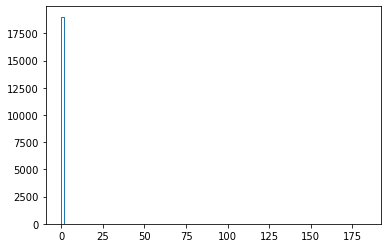

length 19444
length 19030


<Figure size 720x360 with 0 Axes>

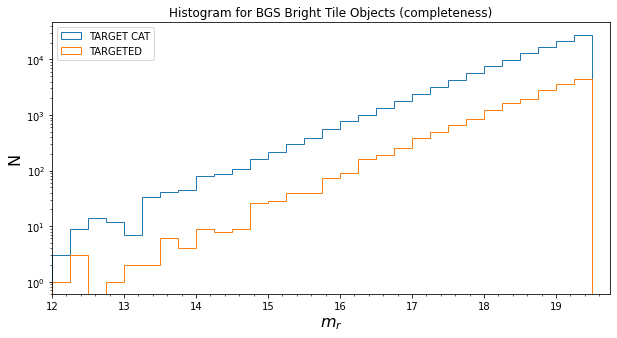

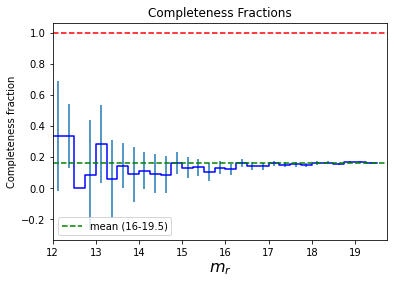

original data input: 19030 objects
z-success data: 17289 objects


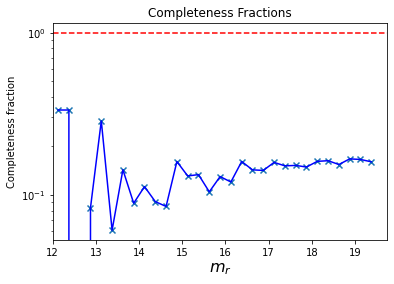

<Figure size 720x360 with 0 Axes>

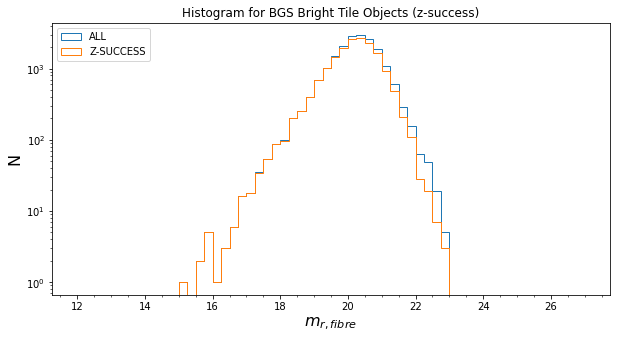

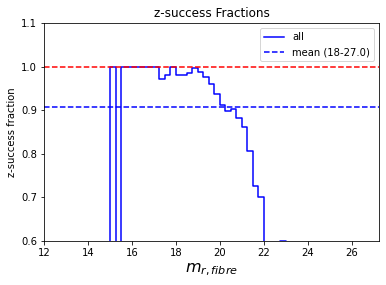

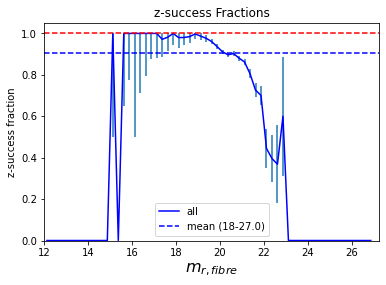

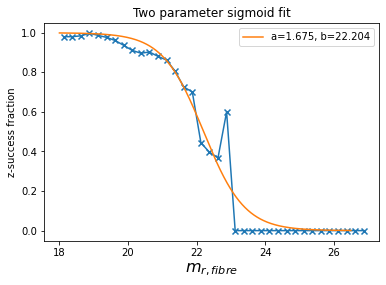

[ 1.6754526  22.20404099]


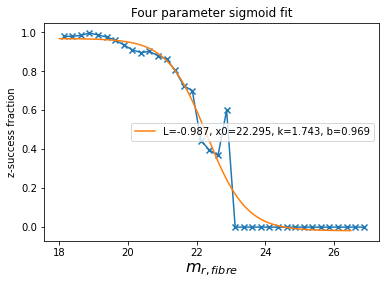

[-0.98743812 22.295197    1.74292748  0.96886753]


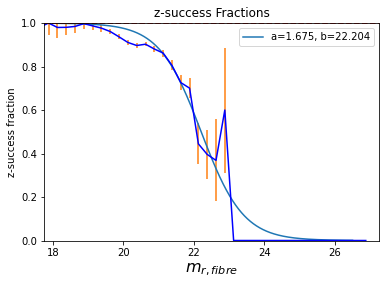

chisq 14.110193468870035
p-value 0.9999999997507631


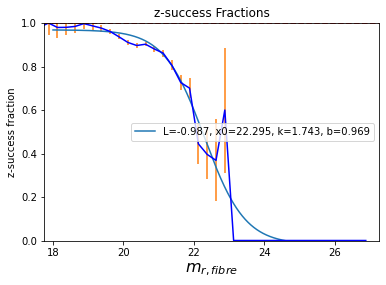

chisq 13.437596299573029
p-value 0.9999999999185516
spectype cut 213
cz cut 17289
cz cut and spectype 213
original data input: 17289 objects
stars with selection cut(s): 213 objects


<Figure size 720x360 with 0 Axes>

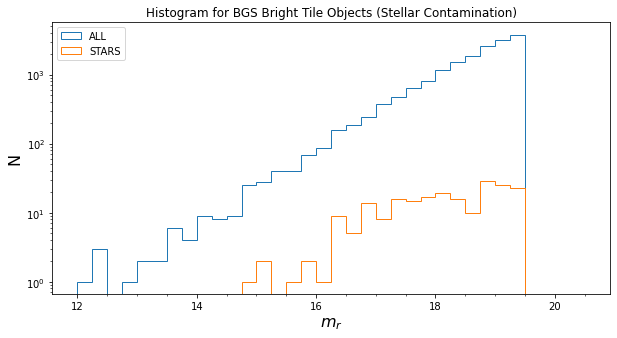

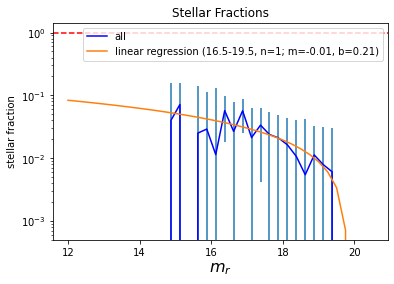

In [210]:
min_z = None
max_z = 0.6

bin_equal = False
fibre_mag_c = False
fibre_mag_z = True
fibre_mag_s = False

function_c = True
function_z = False
function_s = False

label = ''
if function_c == True:
    label += 'constant completeness'
else:
    label += 'bin-dep completeness'
    
if function_z == True:
    label += ', z-success function'
else:
    label += ', bin-dep z-success'
    
if function_s == True:
    label += ', stellar function'
else:
    label += ', bin-dep stellar'
    
n_targets, n_targeted, frac_completeness, data_c, bins_c, popt_c = completeness(deep_bright_original, tile_split=False, fibre_mag=fibre_mag_c, bin_equal=bin_equal)
n_zsuccess, frac_zsuccess, zsuccess_data, bins_z, popt_z = z_success(data_c, tile_split=False, bin_equal=bin_equal, deltachi2=40, spectype=None, z_min=min_z, z_max=max_z, zwarn=True, zerr=True, hist_counts=False, fibre_mag=fibre_mag_z)
frac_stellar, frac_galaxy, bins_s, popt_s = stellar_func(zsuccess_data, tile_split=False, histcounts=False, bin_equal=bin_equal, fibre_mag=fibre_mag_s)

In [211]:
deep_bright_original['WEIGHT'] = 0.0

# COMPLETENESS

if fibre_mag_c == False:      
    for i in tqdm(range(len(bins_c)-1)):
        for j in range(len(deep_bright_original)):
            if (deep_bright_original['MODEL_MAG'][j] > bins_c[i]) and (deep_bright_original['MODEL_MAG'][j] < bins_c[i+1]):
                if function_c == False:
                    deep_bright_original['WEIGHT'][j] = (1/frac_completeness[i])
                else:
                    deep_bright_original['WEIGHT'][j] = 1/popt_c

else:
    for i in tqdm(range(len(bins_c)-1)):
        for j in range(len(deep_bright_original)):
            if (deep_bright_original['MODEL_FIBRE_MAG'][j] > bins_c[i]) and (deep_bright_original['MODEL_FIBRE_MAG'][j] < bins_c[i+1]):
                if function_c == False:
                    deep_bright_original['WEIGHT'][j] = (1/frac_completeness[i])
                else:
                    deep_bright_original['WEIGHT'][j] = 1/popt_c
                        
                        
# REDSHIFT SUCCESS          
                
if fibre_mag_z == False:
    if function_z == False:
        for i in tqdm(range(len(bins_z)-1)):
            for j in range(len(deep_bright_original)):
                if (deep_bright_original['MODEL_MAG'][j] > bins_z[i]) and (deep_bright_original['MODEL_MAG'][j] < bins_z[i+1]):
                    deep_bright_original['WEIGHT'][j] *= (1/frac_zsuccess[i])
                
    else:
        for i in range(len(deep_bright_original)):
            deep_bright_original['WEIGHT'][i] *= sigmoid_func1(deep_bright_original['MODEL_MAG'][i], a=popt_z[0], b=popt_z[1]) 
        
else:
    if function_z == False:
        for i in tqdm(range(len(bins_z)-1)):
            for j in range(len(deep_bright_original)):
                if (deep_bright_original['MODEL_FIBRE_MAG'][j] > bins_z[i]) and (deep_bright_original['MODEL_FIBRE_MAG'][j] < bins_z[i+1]):
                    deep_bright_original['WEIGHT'][j] *= (1/frac_zsuccess[i])
                
    else:
        for i in range(len(deep_bright_original)):
            deep_bright_original['WEIGHT'][i] *= sigmoid_func1(deep_bright_original['MODEL_FIBRE_MAG'][i], a=popt_z[0], b=popt_z[1]) 
    
    

# STELLAR CONTAMINATION
    
if fibre_mag_s == False:
    if function_s == False:
        for i in tqdm(range(len(bins_s)-1)):
            for j in range(len(deep_bright_original)):
                if (deep_bright_original['MODEL_MAG'][j] > bins_s[i]) and (deep_bright_original['MODEL_MAG'][j] < bins_s[i+1]):
                    deep_bright_original['WEIGHT'][j] *= (1/frac_galaxy[i])
    
    else:
        for i in range(len(deep_bright_original)):
            deep_bright_original['WEIGHT'][i] *= popt_s[0]*deep_bright_original['MODEL_MAG'][i] + popt_s[1]
                
else:
    if function_s == False:
        for i in tqdm(range(len(bins_s)-1)):
            for j in range(len(deep_bright_original)):
                if (deep_bright_original['MODEL_FIBRE_MAG'][j] > bins_s[i]) and (deep_bright_original['MODEL_FIBRE_MAG'][j] < bins_s[i+1]):
                    deep_bright_original['WEIGHT'][j] *= (1/frac_galaxy[i])

    else:
        for i in range(len(deep_bright_original)):
            deep_bright_original['WEIGHT'][i] *= popt_s[0]*deep_bright_original['MODEL_FIBRE_MAG'][i] + popt_s[1]
                
from numpy import inf
#weights[weights == inf] = 0
counter = 0
for i in range(len(deep_bright_original)):
    if deep_bright_original['WEIGHT'][i] == np.inf:
        deep_bright_original['WEIGHT'][i] = 0
        counter += 1
print(counter)

100%|██████████| 34/34 [00:36<00:00,  1.06s/it]

169


In [269]:
'''
plt.step(bins_list, [weights[0], *weights], color='b')
plt.minorticks_on()
plt.xlabel(r'$m_r$')
plt.ylabel('w')
plt.xlim(12, 20.5)
plt.title('Overall Weight for each Apparent Magnitude Bin')
'''

"\nplt.step(bins_list, [weights[0], *weights], color='b')\nplt.minorticks_on()\nplt.xlabel(r'$m_r$')\nplt.ylabel('w')\nplt.xlim(12, 20.5)\nplt.title('Overall Weight for each Apparent Magnitude Bin')\n"

In [270]:
#ascii.write(deep_bright_original, 'deep_bright_original(basic).csv', format='csv', fast_writer=False)

In [ ]:
'''
for i in range(3):
    print(deep_bright_original['MODEL_MAG'][i], deep_bright_original['WEIGHT'][i])
    
plt.scatter(deep_bright_original['R_ABSK'], deep_bright_original['WEIGHT'], s=0.5)
plt.xlabel(r'$M_r$', fontsize=16)
plt.ylabel(r'w', fontsize=16)
plt.title('Weights vs. Absolute Magnitude')
plt.xlim(-23, -16)
'''

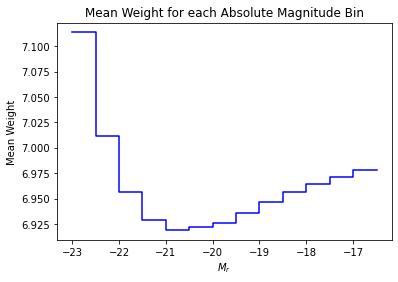

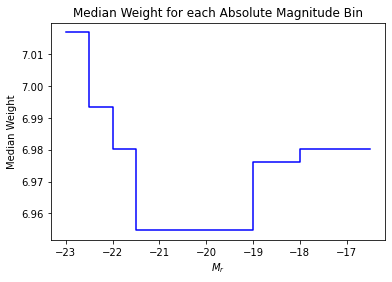

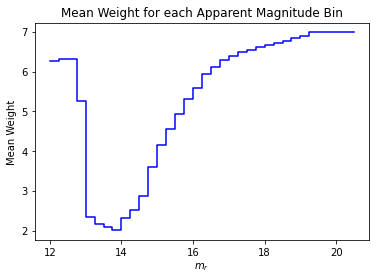

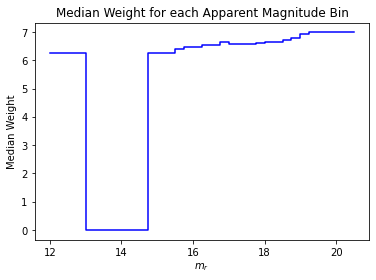

In [212]:
abs_mag_bins = np.arange(-23, -16, 0.5)
app_mag_bins = bins_list
trace_list = []
mean_weight = []
median_weight = []
trace_list2 = []
mean_weight2 = []
median_weight2 = []

for i in range(len(abs_mag_bins)-1):
    for j in range(len(deep_bright_original)):
        if (deep_bright_original['R_ABSK'][j] > abs_mag_bins[i]) and (deep_bright_original['R_ABSK'][j] < abs_mag_bins[i+1]):
            trace_list.append(deep_bright_original['WEIGHT'][j])
            
    trace_list_array = np.array(trace_list)
    mean = np.mean(trace_list_array)
    median = np.median(trace_list_array)
    mean_weight.append(mean)
    median_weight.append(median)
    
plt.step(abs_mag_bins, [mean_weight[0], *mean_weight], color='b')
plt.xlabel(r'$M_r$')
plt.ylabel('Mean Weight')
plt.title('Mean Weight for each Absolute Magnitude Bin')
plt.show()

plt.step(abs_mag_bins, [median_weight[0], *median_weight], color='b')
plt.xlabel(r'$M_r$')
plt.ylabel('Median Weight')
plt.title('Median Weight for each Absolute Magnitude Bin')
plt.show()


for i in range(len(app_mag_bins)-1):
    for j in range(len(deep_bright_original)):
        if (deep_bright_original['MODEL_MAG'][j] > app_mag_bins[i]) and (deep_bright_original['MODEL_MAG'][j] < app_mag_bins[i+1]):
            trace_list2.append(deep_bright_original['WEIGHT'][j])
            
    trace_list_array2 = np.array(trace_list2)
    mean2 = np.mean(trace_list_array2)
    median2 = np.median(trace_list_array2)
    mean_weight2.append(mean2)
    median_weight2.append(median2)
    
plt.step(app_mag_bins, [mean_weight2[0], *mean_weight2], color='b')
plt.xlabel(r'$m_r$')
plt.ylabel('Mean Weight')
plt.title('Mean Weight for each Apparent Magnitude Bin')
plt.show()

plt.step(app_mag_bins, [median_weight2[0], *median_weight2], color='b')
plt.xlabel(r'$m_r$')
plt.ylabel('Median Weight')
plt.title('Median Weight for each Apparent Magnitude Bin')
plt.show()

In [213]:
print([np.array(mean_weight)])
print('')
print([np.array(mean_weight2)])
print('')

[array([7.11349794, 7.01168043, 6.95698925, 6.92944815, 6.91907345,
       6.9219561 , 6.92592167, 6.9360205 , 6.94645066, 6.95663011,
       6.96487147, 6.97137388, 6.97858795])]

[array([6.26328683, 6.3093404 , 6.3093404 , 5.25010807, 2.33081589,
       2.16683279, 2.09643863, 2.0126079 , 2.30719843, 2.51035251,
       2.86670579, 3.60516954, 4.14562614, 4.5634711 , 4.92805849,
       5.31514257, 5.58291783, 5.9362657 , 6.10910356, 6.30081808,
       6.3937453 , 6.48386499, 6.54953714, 6.62388455, 6.68056799,
       6.72334703, 6.77356648, 6.83875287, 6.90683759, 6.98415672,
       6.98415672, 6.98415672, 6.98415672, 6.98415672])]



In [214]:
'''
MOST RECENT WEIGHTS
'''
'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = False, fibre_mag_s = False, function_c = False, function_z = False, function_s = False
'''
M_w1 = np.array([7.01246268, 7.00643539, 6.99754267, 6.9976509 , 7.00153698,
       7.00588273, 7.00796227, 7.00882815, 7.01002879, 7.01024752,
       7.01041247, 7.01112098, 7.0105406 ])

m_w1 = np.array([3.        , 3.        , 3.        , 6.        , 4.28947368,
       9.25      , 8.41176471, 9.32      , 9.2090209 , 9.46704331,
       9.71212121, 9.01011561, 8.8728022 , 8.62174499, 8.84556556,
       8.74326594, 8.75712622, 8.2041515 , 7.98873798, 7.89612607,
       7.54846632, 7.40795727, 7.30454571, 7.2810631 , 7.09399508,
       6.98318368, 6.99121483, 6.90652017, 6.91862846, 7.02564849,
       7.02564849, 7.02564849, 7.02564849, 7.02564849])




'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = True, fibre_mag_s = False, function_c = False, function_z = False, function_s = False

'''
M_w2 = np.array([7.13039871, 7.03971844, 6.98658057, 6.95882728, 6.94523249,
       6.94708576, 6.94921448, 6.9587242 , 6.96794898, 6.97813093,
       6.98617376, 6.9930251 , 7.00009131])

m_w2 = np.array([3.        , 3.02205882, 3.02205882, 4.01470588, 1.64381922,
       3.03851766, 2.7300503 , 2.91084597, 3.31488972, 3.77788418,
       4.54797094, 4.88062337, 5.45531003, 5.86584603, 6.63056054,
       6.97720981, 7.35316806, 7.20281227, 7.26069658, 7.38636535,
       7.20825549, 7.18984198, 7.16399847, 7.21365036, 7.09929406,
       7.00619998, 7.05095436, 6.97078898, 6.94530478, 7.01122399,
       7.01122399, 7.01122399, 7.01122399, 7.01122399])

'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = True, fibre_mag_s = False, function_c = True, function_z = False, function_s = False
'''

M_w3 = np.array([7.11349794, 7.01168043, 6.95698925, 6.92944815, 6.91907345,
       6.9219561 , 6.92592167, 6.9360205 , 6.94645066, 6.95663011,
       6.96487147, 6.97137388, 6.97858795])

m_w3 = np.array([6.26328683, 6.3093404 , 6.3093404 , 5.25010807, 2.33081589,
       2.16683279, 2.09643863, 2.0126079 , 2.30719843, 2.51035251,
       2.86670579, 3.60516954, 4.14562614, 4.5634711 , 4.92805849,
       5.31514257, 5.58291783, 5.9362657 , 6.10910356, 6.30081808,
       6.3937453 , 6.48386499, 6.54953714, 6.62388455, 6.68056799,
       6.72334703, 6.77356648, 6.83875287, 6.90683759, 6.98415672,
       6.98415672, 6.98415672, 6.98415672, 6.98415672])


'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = True, fibre_mag_s = False, function_c = True, function_z = True, function_s = False
'''
M_w4 = np.array([5.82974272, 5.88670535, 5.9741944 , 6.01605545, 6.02791531,
       6.0286028 , 6.0237495 , 6.01615505, 6.0071575 , 6.00039381,
       5.99347009, 5.98861218, 5.98448283])

m_w4 = np.array([6.26315826, 6.26271545, 6.26271545, 6.26287156, 6.26238335,
       6.26267694, 6.26283515, 6.26281795, 6.26092808, 6.26086236,
       6.26046756, 6.31799327, 6.38976632, 6.35691808, 6.36649213,
       6.3730246 , 6.35334093, 6.41396604, 6.39950469, 6.43327255,
       6.39720661, 6.38586572, 6.35552151, 6.31116148, 6.26848385,
       6.2163537 , 6.1564082 , 6.0995193 , 6.02753088, 5.94556759,
       5.94556759, 5.94556759, 5.94556759, 5.94556759])

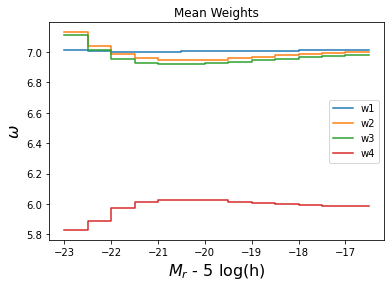

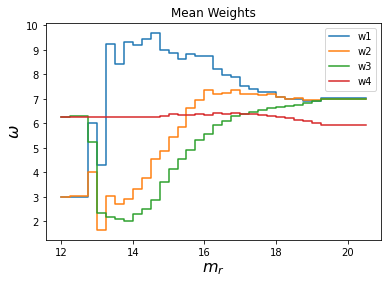

In [215]:
plt.step(abs_mag_bins, [M_w1[0], *M_w1], label='w1')
plt.step(abs_mag_bins, [M_w2[0], *M_w2], label='w2')
plt.step(abs_mag_bins, [M_w3[0], *M_w3], label='w3')
plt.step(abs_mag_bins, [M_w4[0], *M_w4], label='w4')
plt.legend()
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.title('Mean Weights')
plt.show()

plt.step(app_mag_bins, [m_w1[0], *m_w1], label='w1')
plt.step(app_mag_bins, [m_w2[0], *m_w2], label='w2')
plt.step(app_mag_bins, [m_w3[0], *m_w3], label='w3')
plt.step(app_mag_bins, [m_w4[0], *m_w4], label='w4')
plt.legend()
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.title('Mean Weights')
plt.show()

In [273]:
'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = False, fibre_mag_s = False
function_c = False, function_z = False
'''
M_w1 = np.array([6.96695334, 6.96124219, 6.95306322, 6.95347904, 6.95738646,
       6.96169422, 6.96366429, 6.96451325, 6.96568752, 6.96592014,
       6.96607705, 6.9667651 , 6.96617731])

m_w1 = np.array([3.        , 3.        , 3.        , 6.        , 4.28947368,
       9.25      , 8.41176471, 9.32      , 9.2090209 , 9.46704331,
       9.71212121, 9.01011561, 8.8728022 , 8.62174499, 8.84556556,
       8.71470276, 8.71240733, 8.1593138 , 7.93558095, 7.84013567,
       7.49327367, 7.35153032, 7.25381574, 7.23622031, 7.05196913,
       6.94054289, 6.94875874, 6.86628382, 6.87854927, 6.9813544 ,
       6.9813544 , 6.9813544 , 6.9813544 , 6.9813544 ])


'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = False, fibre_mag_s = False
function_c = True, function_z = False
'''
M_w2 = np.array([7.54344185, 7.53643724, 7.52062606, 7.52194584, 7.53637108,
       7.54814249, 7.55593677, 7.55880667, 7.56072479, 7.56037107,
       7.56018731, 7.56150222, 7.56088778])

m_w2 = np.array([ 6.67378537,  6.67378537,  6.67378537,  8.89838049, 27.924523  ,
       27.42508676, 23.83806343, 24.75232841, 22.1982289 , 20.80294939,
       19.46169629, 17.02415353, 15.42664366, 13.91746372, 12.62890503,
       11.50195615, 10.56509185,  9.71669257,  9.11802104,  8.68070238,
        8.23195404,  7.93782587,  7.72467001,  7.58983958,  7.46514592,
        7.4168846 ,  7.38165288,  7.40314508,  7.50123183,  7.61296107,
        7.61296107,  7.61296107,  7.61296107,  7.61296107])



'''
bin_equal = False, fibre_mag_c = False, fibre_mag_z = True, fibre_mag_s = False
function_c = True, function_z = True
'''
M_w3 = np.array([6.09990146, 6.17883997, 6.27181418, 6.31710003, 6.33560895,
        6.34186493, 6.33931618, 6.33217852, 6.32117925, 6.31347293,
        6.30572716, 6.30150997, 6.29718723])
m_w3 = np.array([ 6.67254843,  6.67031137,  6.67031137,  8.89545078, 27.90653592,
        27.4123698 , 23.8287659 , 24.74251124, 22.179493  , 20.78406339,
        19.44204916, 16.92833632, 15.33791558, 13.8287614 , 12.5480795 ,
        11.32451996, 10.33446041,  9.45936973,  8.84955111,  8.4026877 ,
         7.9436869 ,  7.62643057,  7.36145139,  7.1490088 ,  6.96820317,
         6.81310563,  6.67643572,  6.55444627,  6.43407078,  6.31254657,
         6.31254657,  6.31254657,  6.31254657,  6.31254657])



'''
bin_equal = True, fibre_mag_c = False, fibre_mag_z = True, fibre_mag_s = False
function_c = True, function_z = True
'''

M_w4 = np.array([6.11628769, 6.17833889, 6.27331134, 6.3208882 , 6.33413951,
       6.33498461, 6.32913395, 6.32119026, 6.31125071, 6.30396312,
       6.29673377, 6.29118709, 6.28694727])

m_w4 = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 2.41801618, 3.83612021, 4.6072984 , 4.92918416,
       5.13083889, 5.52734487, 5.75237277, 5.93807028, 6.10030058,
       6.25128639, 6.36309437, 6.46077419, 6.51865045, 6.55515018,
       6.58255645, 6.59531475, 6.59484063, 6.57261835, 6.55313897,
       6.52059685, 6.47767543, 6.42094479, 6.34339685, 6.24365676,
       6.24365676, 6.24365676, 6.24365676, 6.24365676])

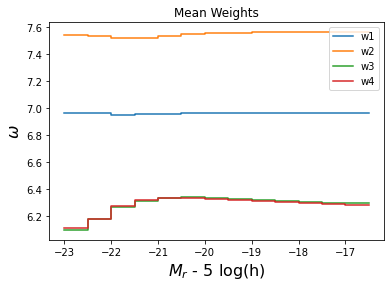

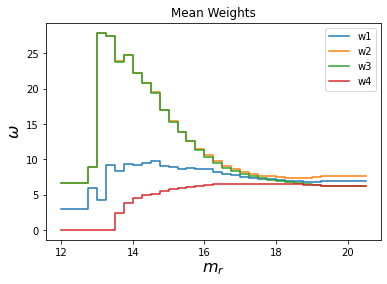

In [277]:
plt.step(abs_mag_bins, [M_w1[0], *M_w1], label='w1')
plt.step(abs_mag_bins, [M_w2[0], *M_w2], label='w2')
plt.step(abs_mag_bins, [M_w3[0], *M_w3], label='w3')
plt.step(abs_mag_bins, [M_w4[0], *M_w4], label='w4')
plt.legend()
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.title('Mean Weights')
plt.show()

plt.step(app_mag_bins, [m_w1[0], *m_w1], label='w1')
plt.step(app_mag_bins, [m_w2[0], *m_w2], label='w2')
plt.step(app_mag_bins, [m_w3[0], *m_w3], label='w3')
plt.step(app_mag_bins, [m_w4[0], *m_w4], label='w4')
plt.legend()
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.title('Mean Weights')
plt.show()

In [255]:
'''
Dated 8th July
'''

# params None; bin_equal = False; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = True; all bin dependent
w1 = np.array([6.43637038, 6.51085294, 6.66915325, 6.75513455, 6.78397011,
        6.78383397, 6.76414321, 6.73958878, 6.71587944, 6.69644241,
        6.67507974, 6.66288956, 6.64998411])

# params None; bin_equal = False; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = True; constant completeness
w2 = np.array([6.81616741, 6.8885832 , 7.05011821, 7.12778545, 7.15472738,
       7.15121207, 7.13023682, 7.10467142, 7.0770305 , 7.05506381,
       7.03210403, 7.01786302, 7.00357348])

# params None; bin_equal = False; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = True; constant completeness, sigmoid function
w3 = np.array([5.68305545, 5.84569336, 6.04934309, 6.14045061, 6.17087122,
       6.16815084, 6.14430869, 6.11581183, 6.08346582, 6.05998748,
       6.0370548 , 6.02166755, 6.00816334])

# params None; bin_equal = True; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = True; constant completeness, sigmoid function
w4 = np.array([6.05686716, 6.16315339, 6.26696381, 6.31649987, 6.33223595,
       6.33408323, 6.32617406, 6.31736082, 6.30531207, 6.29715409,
       6.28901297, 6.28321817, 6.27863354])

# params None; bin_equal = False; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = False; constant completeness, sigmoid function
w5 = np.array([6.6032993 , 6.69124382, 6.80226541, 6.85282783, 6.86038525,
       6.85585602, 6.84634434, 6.8363243 , 6.82315191, 6.81513278,
       6.8072555 , 6.80137036, 6.796955])

# params None; bin_equal = True; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = False; constant completeness, sigmoid function
w6 = np.array([6.6032993 , 6.69112811, 6.80221397, 6.85279975, 6.85891853,
       6.85473111, 6.8444716 , 6.83463129, 6.82155118, 6.81358204,
       6.80573371, 6.79986666, 6.79546545])

# params g-r=0.553; bin_equal = False; fibre_mag_c = True; fibre_mag_z = True; fibre_mag_s = True; all bin dependent
w7 = np.array([6.3238219 , 6.59922679, 6.72506887, 6.78125425, 6.79946532,
       6.78614228, 6.76303953, 6.73475623, 6.71775787, 6.69613575,
       6.68170812, 6.66572633, 6.65371436])

Text(0.5, 1.0, 'Mean Weights')

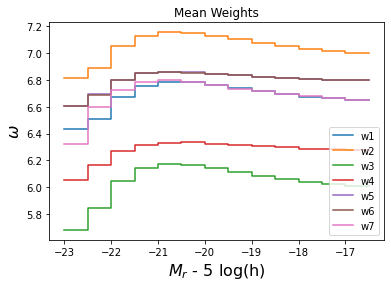

In [256]:
plt.step(abs_mag_bins, [w1[0], *w1], label='w1')
plt.step(abs_mag_bins, [w2[0], *w2], label='w2')
plt.step(abs_mag_bins, [w3[0], *w3], label='w3')
plt.step(abs_mag_bins, [w4[0], *w4], label='w4')
plt.step(abs_mag_bins, [w5[0], *w5], label='w5')
plt.step(abs_mag_bins, [w6[0], *w6], label='w6')
plt.step(abs_mag_bins, [w7[0], *w7], label='w7')
plt.legend()
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.title('Mean Weights')

Text(0.5, 1.0, 'Mean Weights')

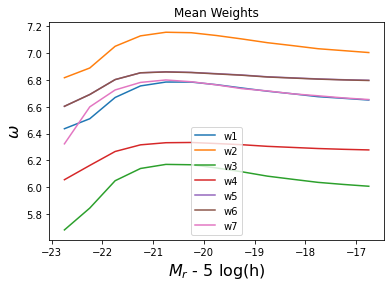

In [257]:
midbins = (abs_mag_bins[1:] + abs_mag_bins[:-1]) / 2
plt.plot(midbins, w1, label='w1')
plt.plot(midbins, w2, label='w2')
plt.plot(midbins, w3, label='w3')
plt.plot(midbins, w4, label='w4')
plt.plot(midbins, w5, label='w5')
plt.plot(midbins, w6, label='w6')
plt.plot(midbins, w7, label='w7')
plt.legend()
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.title('Mean Weights')

In [275]:
'''
INSERT MAIN LF HERE
'''

'\nINSERT MAIN LF HERE\n'

0

[-3.80654166 -3.28487345 -2.85225831 -2.51024451 -2.27237637 -2.10047168
 -1.97555693 -1.90393596 -1.87897418 -1.85427641 -1.81867545 -1.7409731
 -1.61789464 -1.52208434 -1.54519876 -1.26395673]


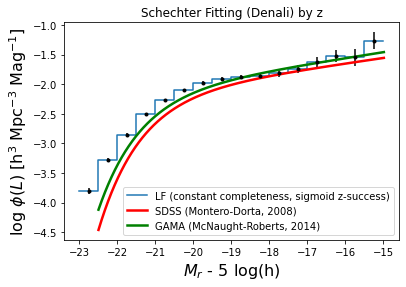

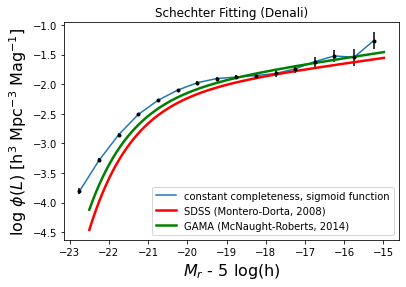

In [66]:
log_densities = []
data_t_array = []

data_t = deep_bright_original

data_t = data_t[data_t['SPECTYPE'] != 'STAR']
data_t = data_t[data_t['Z'] > 0]
data_t = data_t[data_t['Z'] < 0.6]
data_t = data_t[data_t['DELTACHI2'] > 40]
data_t = data_t[data_t['ZWARN'] == 0]
data_t = data_t[data_t['ZERR'] < 0.0005 * (1+data_t['Z'])]

min_z = min(data_t['Z'])
max_z = max(data_t['Z'])

data_t['V'] = 0.0
data_t['VMAX'] = 0.0 

pass_array = []
roots = []
for i in range(len(data_t)):
    try:
        data_t['V'][i] = vmax_brent(data_t[i], min_z, data_t['Z'][i], mag_limit, params=None)
        data_t['VMAX'][i] = vmax_brent(data_t[i], min_z, max_z, mag_limit, params=None)
    except:
        pass_array.append(i)

len(data_t[data_t['V'] > data_t['VMAX']]) # sanity check 

# temp fix - plot brent method to fix
data_t = data_t[data_t['VMAX'] != 0]
#######

data_t['LF_VALUE_INTERP_K'] = data_t['WEIGHT'] / data_t['VMAX']

data_t[data_t['VMAX'] == np.inf]

LF_values2 = []
densities2 = []

for i in range(1, len(xedges)):
    lower_m = xedges[i-1]
    upper_m = xedges[i]
    sources = data_t[(data_t['R_ABSK']>=lower_m) & (data_t['R_ABSK']<upper_m)]

    LF_value = np.sum(sources['LF_VALUE_INTERP_K']/sky_fraction)
    density = LF_value / (upper_m - lower_m) 
    LF_values2.append(LF_value)
    densities2.append(density)

log_LF_values2 = np.log10(LF_values2)    
log_densities2 = np.log10(densities2)

centres = (xedges[1:]+xedges[:-1])/2

#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities1, p0=[-21, -1, 10**-2])
#plt.step(xedges, [log_densities2[0], *log_densities2], label='K with colour; bin-dependent completeness')

#plt.step(xedges, [log_densities2[0], *log_densities2], label='{}<z<{}'.format(min_z, max_z))

log_densities.append(log_densities2) 
print(log_densities2)

data_t_array.append(data_t)

frac_w = []

for i in range(len(xedges)-1):
    weight_sq_sum = 0.0
    sum_weight_sq = 0.0
    
    for j in range(len(data_t)):
        if (data_t['R_ABSK'][j] > xedges[i]) and (data_t['R_ABSK'][j] < xedges[i+1]):
            weight_sq_sum += data_t['WEIGHT'][j]**2
            sum_weight_sq += data_t['WEIGHT'][j]
            
    sum_weight_sq = sum_weight_sq**2
    frac_w.append(weight_sq_sum / sum_weight_sq)
    
plt.step(xedges, [log_densities[0][0], *log_densities[0]], label='LF (constant completeness, sigmoid z-success)')
    
#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])

plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')
#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
plt.title(r'Schechter Fitting (Denali) by z')
plt.legend()
plt.show()

plt.plot(centres, log_densities[0], label=label)
plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')
#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
plt.title(r'Schechter Fitting (Denali)')
plt.legend()
plt.show()

In [67]:
print(log_densities)

[array([-3.80654166, -3.28487345, -2.85225831, -2.51024451, -2.27237637,
       -2.10047168, -1.97555693, -1.90393596, -1.87897418, -1.85427641,
       -1.81867545, -1.7409731 , -1.61789464, -1.52208434, -1.54519876,
       -1.26395673])]


In [ ]:
# complex K (z_ref = 0), bin_dependent weights, all fibre magnitudes, h = 1, equal bin width

# simple K [-6.299, 14.76, -7.473, 1.847, -0.006801] (z_ref = 0), bin_dependent weights, all fibre magnitudes, h = 1, equal bin width


# simple K [-6.299, 14.76, -7.473, 1.847, -0.006801] (z_ref = 0), bin_dependent weights, all fibre magnitudes, h = 1, equal bin object size

# complex K (z_ref = 0), bin_dependent weights, all fibre magnitudes, h = 1, equal bin object size

# complex K (z_ref = 0), constant m_r completeness, bin_dependent m_r fibre z-success, bin_dependent m_r fibre stellar, h=1, equal bin object size

# complex K (z_ref = 0), constant m_r completeness, bin_dependent m_r fibre z-success, bin_dependent m_r fibre stellar, h=1, equal bin object size


In [ ]:
plt.step(xedges, [LD1[0][0], *LD1[0]], label='LF (1)')

plt.step(xedges, [LD3[0][0], *LD3[0]], label='LF (3)')
#plt.errorbar(centres, LD3[0], yerr=yerr3[0], fmt='.k')

plt.step(xedges, [LD4[0][0], *LD4[0]], label='LF (4)')
#plt.errorbar(centres, LD4[0], yerr=yerr4[0], fmt='.k')

plt.step(xedges, [LD5[0][0], *LD5[0]], label='LF (5)')
#plt.errorbar(centres, LD5[0], yerr=yerr5[0], fmt='.k')

#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])

#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
#plt.plot(xspace, log_schechter(xspace, *twodf_popt), color='blue', linewidth=2.5, label=r'2DF (Norberg, 2002)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'Schechter Fitting (Denali) by z')
plt.legend()
plt.show()

In [ ]:
plt.step(xedges, [LD5[0][0], *LD5[0]], label='h=1')
plt.errorbar(centres, LD5[0], yerr=yerr5[0], fmt='.k')

plt.step(xedges, [LD6[0][0], *LD6[0]], label='h=0.75')
plt.errorbar(centres, LD6[0], yerr=yerr6[0], fmt='.k')

#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])

#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
#plt.plot(xspace, log_schechter(xspace, *twodf_popt), color='blue', linewidth=2.5, label=r'2DF (Norberg, 2002)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'Schechter Fitting (Denali) by z')
plt.legend()
plt.show()

In [ ]:
'''
Abs. Mag V/VMAX distribution
'''

In [ ]:
Mr_array = np.arange(-23, -16, 1)
pass_array = []

for i in range(len(Mr_array)-1):
    data_z = deep_bright_original
    data_z = data_z[data_z['Z'] > 0]
    data_z = data_z[data_z['Z'] < 0.6]
    data_z = data_z[data_z['DELTACHI2'] > 40]
    data_z = data_z[data_z['SPECTYPE'] != 'STAR']
    data_z = data_z[data_z['ZWARN'] == 0]
    data_z = data_z[data_z['ZERR'] < 0.0005 * (1+data_z['Z'])]

    data_z = data_z[data_z['R_ABSK'] > Mr_array[i]]
    data_z = data_z[data_z['R_ABSK'] < Mr_array[i+1]]

    min_z = min(data_z['Z'])
    max_z = max(data_z['Z'])

    data_z['V'] = 0.0
    data_z['V_MAX'] = 0.0

    for j in tqdm(range(len(data_z))):
        try:
            data_z['V'][j] = vmax_brent(data_z[j], min_z, data_z['Z'][j], mag_limit, params=None)
            data_z['V_MAX'][j] = vmax_brent(data_z[j], min_z, max_z, mag_limit, params=None)
        except:
            pass_array.append(j)

    data_z['V/V_MAX'] = data_z['V'] / data_z['V_MAX']

    data_new = data_z[data_z['V/V_MAX'] != np.inf]

    n, bins, _ = plt.hist(data_new['V/V_MAX'], bins=20, color='orange')
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
    plt.axhline(np.mean(n), ls='--', color='b')
    plt.xlabel('V/Vmax',fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.title('V/Vmax distribution for {:.1f}<Mr<{:.1f}'.format(Mr_array[i], Mr_array[i+1]))
    plt.show()
    
    print(len(data_new))
    print(len(data_z))

In [241]:
deep_bright_original

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MASKBITS,EBV,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET,SERSIC,MORPHTYPE,EXPID,FIBERSTATUS,B_DEPTH,R_DEPTH,Z_DEPTH,TILEID,G-R_OBS,G-R_REST,K_R,K_G,MW_CORRECTION_R,MODEL_MAG,MODEL_FIBRE_MAG,R_ABSK,NODATA,WEIGHT
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,str1,int64,int64,int64,int64,float32,str4,int64,int64,float32,float32,float32,int64,float32,float64,float64,float64,float32,float32,float32,float64,bool,float64
39627623046842657,8785.096047680825,348.3793061491269 .. 2.717359419065661,0.3405430078872086,6.554233915826715e-05,0,7928,GALAXY,,10,446.49216147884727,0,1,66.46968973338203,-6.732241342911616,6.448931,29.011358,62.9603,1.9522387,8.782401,19.05952,0,0.05547338,S,1152921504715898985,131074,0,0,4.9821424,SER,205935,0,1122.9,1089.4,1129.2,80612,1.5808073,0.9221845551200936,0.24575370437442606,0.9043764774785146,0.8952824,18.72348,20.020866,-22.022332954317665,False,6.433854291343049
39627623046842892,8603.76461711526,208.8060985041633 .. 1.3849738314338291,0.19188663080379792,1.2170850883677523e-05,0,7927,GALAXY,,10,1309.6186922490597,0,1,66.47954520601914,-6.774167579389469,10.7555685,23.96162,45.99522,2.3139787,5.1551604,9.895522,0,0.053695407,S,1152921504606846976,131074,0,0,0.86468863,SER,205935,0,1122.9,1089.4,1129.2,80612,0.816634,0.6373012225184046,-0.041307401264485566,0.13802537556479666,0.8984621,18.93496,20.603144,-20.10521423523265,False,6.141404915993058
39627623046843327,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,66.49751470951506,-6.630566217017194,50.501484,168.6726,346.1951,8.951034,29.896036,61.360653,0,0.055154163,S,1152921504606846976,131074,0,0,4.849322,SER,--,--,--,--,--,80612,1.2565002,1.4245076842709858,-0.2434132960394235,-0.4114207361697844,0.89585245,16.81298,18.691557,nan,True,7.151805104013625
39627623046843433,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,66.50213506235956,-6.7988938491038065,5.9860477,28.115627,64.68832,1.2276855,5.766267,13.267003,2064,0.052255772,S,1152921504640401441,655370,0,0,6.0,SER,--,--,--,--,--,80612,1.6312015,1.7992089457913716,-0.2434132960394235,-0.4114207361697844,0.901045,18.764496,20.484629,nan,True,6.226714615425402
39627623046844067,8870.17392373085,27.28956600747472 .. 22.759585969927546,0.19035166501944636,1.2770390118412231e-05,0,7928,GALAXY,,10,1465.8768458366394,0,1,66.53093900795233,-6.805234860977716,10.103793,23.977419,47.179077,2.858442,6.7833996,13.347331,0,0.05101147,S,1152921504673955905,131074,0,0,1.2151574,SER,205935,0,1122.9,1089.4,1129.2,80612,0.88832307,0.6988711726107688,-0.02860538039678069,0.16084651561122498,0.9032835,18.940054,20.310942,-20.09341164070721,False,6.333309153363713
39627623046845957,9442.51004961878,1204.1357393710266 .. 33.67863049726231,0.2900748586508609,4.543830506162929e-05,0,7927,GALAXY,,10,2164.8314360566437,0,1,66.61552328003438,-6.6918627116171825,28.722355,107.008575,211.28465,5.0461054,18.79987,37.11968,0,0.04961309,S,1152921504606846976,131074,0,0,6.0,SER,205935,0,1122.9,1089.4,1129.2,80612,1.3814559,0.8662182986529275,0.13268503522979838,0.647922634861783,0.90580577,17.319042,19.207201,-22.91041124949415,False,6.802191971684277
39627623051034940,9023.540277145803,41.48915879598757 .. 31.304983975115015,0.23532044250011472,7.118255891322645e-05,0,7928,GALAXY,,10,327.67130390927196,0,1,66.6323811354347,-6.753539817482426,9.293149,35.151016,76.989075,2.8093534,10.626283,23.274082,0,0.047361404,S,1152921504606846976,131074,0,0,6.0,SER,205935,0,1122.9,1089.4,1129.2,80612,1.4003344,0.9949730786499458,0.09127877860976555,0.4966400581751517,0.9098819,18.532618,

In [240]:
gr_array = stats.mstats.mquantiles(deep_bright_original['G-R_REST'][~np.isnan(deep_bright_original['G-R_REST'])], np.arange(0, 1.0001, 0.2))
pass_array = []

for i in range(len(gr_array)-1):
    data_z = deep_bright_original
    data_z = data_z[data_z['Z'] > 0]
    data_z = data_z[data_z['Z'] < 0.6]
    data_z = data_z[data_z['DELTACHI2'] > 40]
    data_z = data_z[data_z['SPECTYPE'] != 'STAR']
    data_z = data_z[data_z['ZWARN'] == 0]
    data_z = data_z[data_z['ZERR'] < 0.0005 * (1+data_z['Z'])]

    data_z = data_z[data_z['R_ABSK'] > gr_array[i]]
    data_z = data_z[data_z['R_ABSK'] < gr_array[i+1]]

    min_z = min(data_z['Z'])
    max_z = max(data_z['Z'])

    data_z['V'] = 0.0
    data_z['V_MAX'] = 0.0

    for j in tqdm(range(len(data_z))):
        try:
            data_z['V'][j] = vmax_brent(data_z[j], min_z, data_z['Z'][j], mag_limit, params=None)
            data_z['V_MAX'][j] = vmax_brent(data_z[j], min_z, max_z, mag_limit, params=None)
        except:
            pass_array.append(j)

    data_z['V/V_MAX'] = data_z['V'] / data_z['V_MAX']

    data_new = data_z[data_z['V/V_MAX'] != np.inf]

    n, bins, _ = plt.hist(data_new['V/V_MAX'], bins=20, color='orange')
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
    plt.axhline(np.mean(n), ls='--', color='b')
    plt.xlabel('V/Vmax',fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.title('V/Vmax distribution for {:.1f}<g-r<{:.1f}'.format(gr_array[i], gr_array[i+1]))
    plt.show()
    
    print(len(data_new))
    print(len(data_z))

ValueError: min() arg is an empty sequence

In [ ]:
'''
Redshift V/V_MAX DISTRIBUTION
'''

100%|██████████| 2561/2561 [00:39<00:00, 65.08it/s]


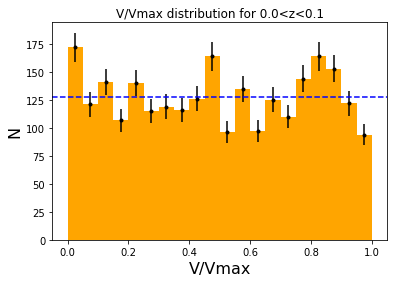

100%|██████████| 6043/6043 [01:22<00:00, 72.89it/s]


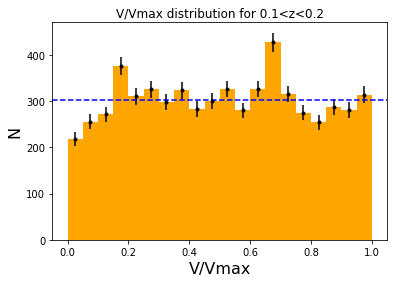

100%|██████████| 5415/5415 [01:09<00:00, 78.41it/s]


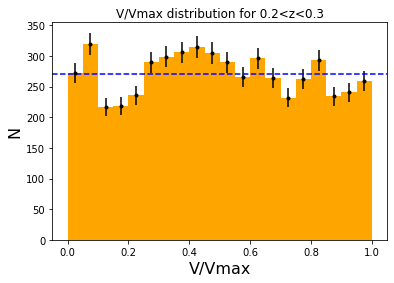

100%|██████████| 2446/2446 [00:30<00:00, 81.13it/s]


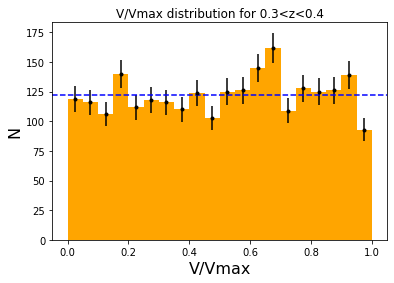

100%|██████████| 634/634 [00:07<00:00, 81.22it/s]


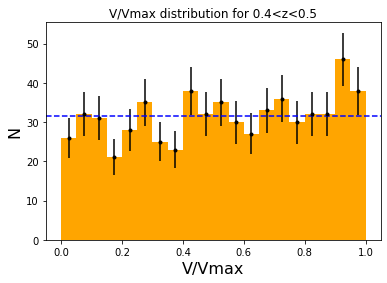

100%|██████████| 80/80 [00:00<00:00, 83.82it/s]


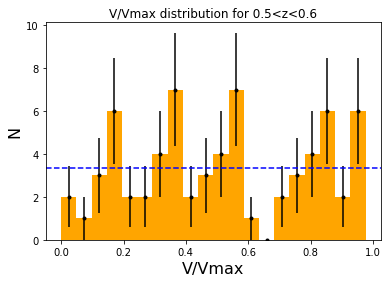

In [243]:
z_array = np.arange(0, 0.7, 0.1)
#z_array = stats.mstats.mquantiles(deep_bright_original['Z'][~np.isnan(deep_bright_original['Z'])], np.arange(0, 1.0001, 0.2))
pass_array = []

for i in range(len(z_array)-1):
    data_z = deep_bright_original
    data_z = data_z[data_z['Z'] > z_array[i]]
    data_z = data_z[data_z['Z'] < z_array[i+1]]
    data_z = data_z[data_z['DELTACHI2'] > 40]
    data_z = data_z[data_z['SPECTYPE'] != 'STAR']
    data_z = data_z[data_z['ZWARN'] == 0]
    data_z = data_z[data_z['ZERR'] < 0.0005 * (1+data_z['Z'])]

    min_z = min(data_z['Z'])
    max_z = max(data_z['Z'])

    data_z['V'] = 0.0
    data_z['V_MAX'] = 0.0

    for j in tqdm(range(len(data_z))):
        try:
            data_z['V'][j] = vmax_brent(data_z[j], min_z, data_z['Z'][j], mag_limit, params=None)
            data_z['V_MAX'][j] = vmax_brent(data_z[j], min_z, max_z, mag_limit, params=None)
        except:
            pass_array.append(j)

    data_z['V/V_MAX'] = data_z['V'] / data_z['V_MAX']

    data_new = data_z[data_z['V/V_MAX'] != np.inf]

    n, bins, _ = plt.hist(data_new['V/V_MAX'], bins=20, color='orange')
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
    plt.axhline(np.mean(n), ls='--', color='b')
    plt.xlabel('V/Vmax',fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.title('V/Vmax distribution for {:.1f}<z<{:.1f}'.format(z_array[i], z_array[i+1]))
    plt.show()

100%|██████████| 3892/3892 [00:55<00:00, 70.23it/s]


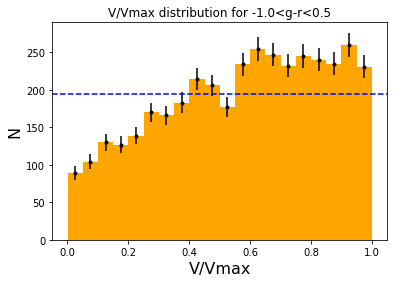

100%|██████████| 3979/3979 [00:54<00:00, 73.46it/s]


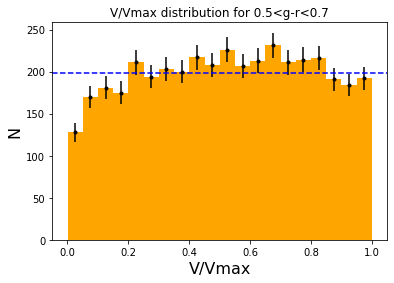

100%|██████████| 3941/3941 [00:51<00:00, 76.97it/s]


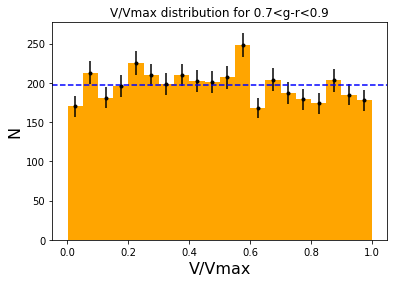

100%|██████████| 4003/4003 [00:49<00:00, 81.62it/s]


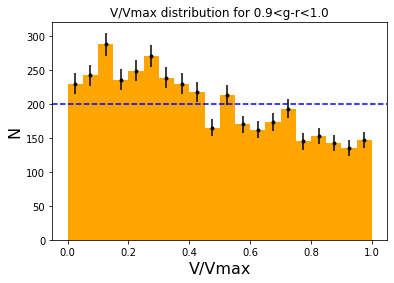

100%|██████████| 1364/1364 [00:17<00:00, 79.71it/s]


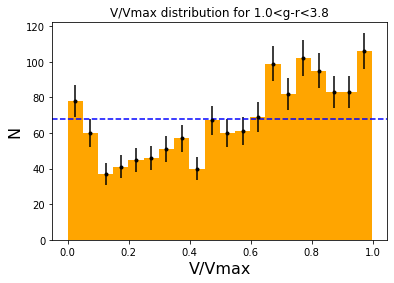

In [247]:
log_densities = []
data_gr_array = []
min_z = 0
max_z = 0.6

data = deep_bright_original
data = data[data['Z'] > 0]
data = data[data['Z'] < 0.6]
data = data[data['DELTACHI2'] > 40]
data = data[data['SPECTYPE'] != 'STAR']
data = data[data['ZWARN'] == 0]
data = data[data['ZERR'] < 0.0005 * (1+data['Z'])]

for i in range(len(gr_array)-1):

    min_gr = gr_array[i]
    max_gr = gr_array[i+1]

    data_gr = data[(data['G-R_REST'] >= min_gr) & (data['G-R_REST'] < max_gr)]

    data_gr['V'] = 0.0
    data_gr['V_MAX'] = 0.0

    for j in tqdm(range(len(data_gr))):
        try:
            data_gr['V'][j] = vmax_brent(data_gr[j], min_z, data_gr['Z'][j], mag_limit, params=None)
            data_gr['V_MAX'][j] = vmax_brent(data_gr[j], min_z, max_z, mag_limit, params=None)
        except:
            pass_array.append(j)

    data_gr['V/V_MAX'] = data_gr['V'] / data_gr['V_MAX']

    data_new = data_gr[data_gr['V/V_MAX'] != np.inf]

    n, bins, _ = plt.hist(data_new['V/V_MAX'], bins=20, color='orange')
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
    plt.axhline(np.mean(n), ls='--', color='b')
    plt.xlabel('V/Vmax',fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.title('V/Vmax distribution for {:.1f}<g-r<{:.1f}'.format(gr_array[i], gr_array[i+1]))
    plt.show()

In [224]:
log_densities = []
data_z_array= []
pass_array = []

for i in range(len(z_array)-1):

    data_z = deep_bright_original

    min_z = z_array[i]
    max_z = z_array[i+1]

    data_z = data_z[data_z['Z'] >= min_z]
    data_z = data_z[data_z['Z'] < max_z]

    data_z['VOLUME'] = 0.0

    print(len(data_z))
    data_z = data_z[data_z['SPECTYPE'] != 'STAR']
    data_z = data_z[data_z['Z'] > 0]
    data_z = data_z[data_z['Z'] < 0.6]
    data_z = data_z[data_z['DELTACHI2'] > 40]
    data_z = data_z[data_z['ZWARN'] == 0]
    data_z = data_z[data_z['ZERR'] < 0.0005 * (1+data_z['Z'])]

    print(len(data_z))

    
    pass_array = []

    roots = []
    for i in range(len(data_z)):
        try:
            data_z['VOLUME'][i] = vmax_brent(data_z[i], min_z, max_z, mag_limit, params=None)
        except:
            pass_array.append(i)

    data_z['LF_VALUE_INTERP_K'] = data_z['WEIGHT'] / data_z['VOLUME']

    LF_values2 = []
    densities2 = []

    for i in range(1, len(xedges)):
        lower_m = xedges[i-1]
        upper_m = xedges[i]
        sources = data_z[(data_z['R_ABSK']>=lower_m) & (data_z['R_ABSK']<upper_m)]

        LF_value = np.sum(sources['LF_VALUE_INTERP_K']/sky_fraction)
        density = LF_value / (upper_m - lower_m) 
        LF_values2.append(LF_value)
        densities2.append(density)

    log_LF_values2 = np.log10(LF_values2)    
    log_densities2 = np.log10(densities2)

    centres = (xedges[1:]+xedges[:-1])/2

    #popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities1, p0=[-21, -1, 10**-2])
    #plt.step(xedges, [log_densities2[0], *log_densities2], label='K with colour; bin-dependent completeness')

    #plt.step(xedges, [log_densities2[0], *log_densities2], label='{}<z<{}'.format(min_z, max_z))
    
    log_densities.append(log_densities2) 
    #print(log_densities2)
    
    data_z_array.append(data_z)

2904
2561
[       -inf -3.74842895 -3.23733735 -2.68069604 -2.38008081 -2.0948785
 -1.95966729 -1.86442436 -1.8493919  -1.80765379 -1.81571493 -1.74928464
 -1.61792304 -1.52070756 -1.54265404 -1.26177396]
6287
6043
[-4.20949115 -3.31925581 -2.94990182 -2.55918082 -2.27511173 -2.10488633
 -1.98099512 -1.91897134 -1.90760525 -1.98101071        -inf        -inf
        -inf        -inf        -inf        -inf]
5832
5415
[-3.95642338 -3.36176587 -2.81247079 -2.4810906  -2.27313744 -2.11733746
 -2.1510381         -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf]
2675
2446
[-3.85313469 -3.2680246  -2.84245772 -2.55608969 -2.71485493        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf]
814
634
[        inf         inf -3.31063914 -4.51216721        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -in

0.0<z<0.1: len 2561
0.1<z<0.2: len 6043
0.2<z<0.30000000000000004: len 5415
0.30000000000000004<z<0.4: len 2446
0.4<z<0.5: len 634
0.5<z<0.6000000000000001: len 80


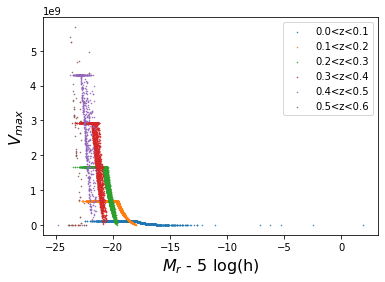

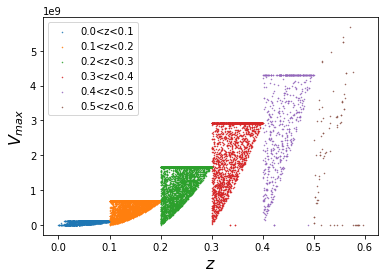

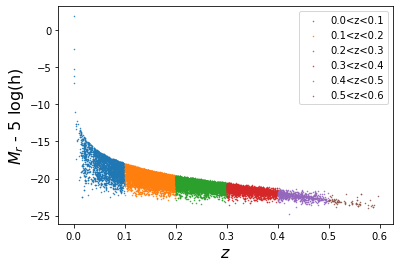

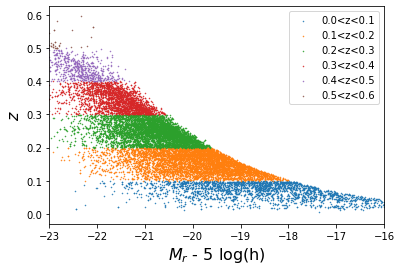

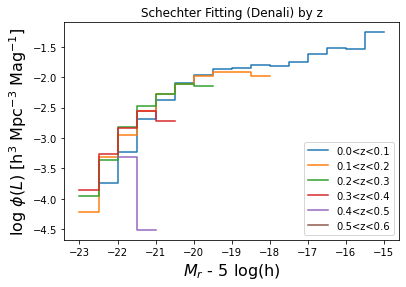

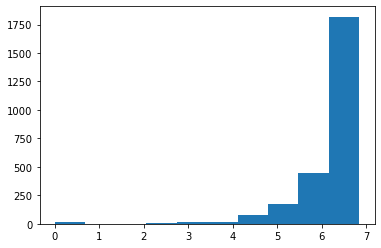

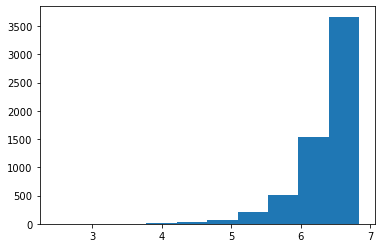

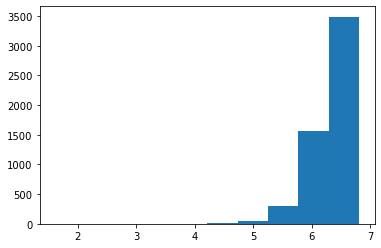

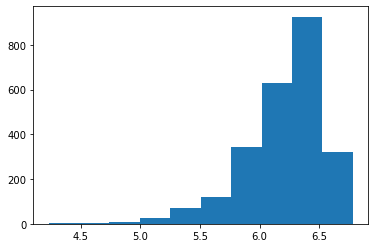

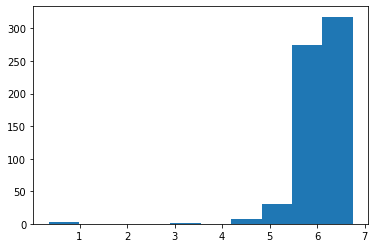

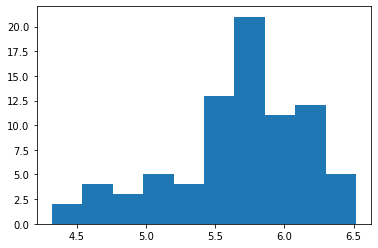

In [225]:
for i in range(len(data_z_array)):
    print('{}<z<{}: len {}'.format(z_array[i], z_array[i+1], len(data_z_array[i])))
    plt.scatter(data_z_array[i]['R_ABSK'], data_z_array[i]['VOLUME'], s=0.25, label='{:.1f}<z<{:.1f}'.format(z_array[i], z_array[i+1]))
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'$V_{max}$', fontsize=16)
plt.legend()
plt.show()

for i in range(len(data_z_array)):
    plt.scatter(data_z_array[i]['Z'], data_z_array[i]['VOLUME'], s=0.25, label='{:.1f}<z<{:.1f}'.format(z_array[i], z_array[i+1]))
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$V_{max}$', fontsize=16)
plt.legend()
plt.show()

for i in range(len(data_z_array)):
    plt.scatter(data_z_array[i]['Z'], data_z_array[i]['R_ABSK'], s=0.25, label='{:.1f}<z<{:.1f}'.format(z_array[i], z_array[i+1]))
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.legend()
plt.show()

for i in range(len(data_z_array)):
    plt.scatter(data_z_array[i]['R_ABSK'], data_z_array[i]['Z'], s=0.25, label='{:.1f}<z<{:.1f}'.format(z_array[i], z_array[i+1]))
plt.ylabel(r'$z$', fontsize=16)
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.xlim(-23, -16)
plt.legend()
plt.show()


for i in range(len(log_densities)):
    plt.step(xedges, [log_densities[i][0], *log_densities[i]], label='{:.1f}<z<{:.1f}'.format(z_array[i], z_array[i+1]))

plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'Schechter Fitting (Denali) by z')
plt.legend()
plt.show()

'''
for i in range(len(log_densities)):
    plt.hist(data_z_array[i]['WEIGHT'])
    plt.show()
'''

In [227]:
data_t['D_L'] = cosmo.luminosity_distance(data_t['Z'])
data_t['N_NEIGHBOUR'] = 0

catalog = SkyCoord(data_t['TARGET_RA']*u.deg, data_t['TARGET_DEC']*u.deg, data_t['D_L'])

for i in tqdm(range(len(data))):
    c = SkyCoord(data_t['TARGET_RA'][i]*u.deg, data_t['TARGET_DEC'][i]*u.deg, distance=data_t['D_L'][i]*u.Mpc, frame="icrs")
    idx, d2d, d3d = c.match_to_catalog_3d(catalog,  nthneighbor=2)

    j = 1
    while (d3d < (8/h)*u.Mpc):
        j+=1
        idx, d2d, d3d = c.match_to_catalog_3d(catalog,  nthneighbor=j)

    data_t['N_NEIGHBOUR'][i] = j-1 

100%|██████████| 17158/17158 [07:40<00:00, 37.27it/s]


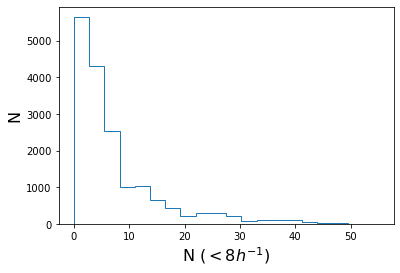

In [228]:
plt.hist(data_t['N_NEIGHBOUR'], bins=20, histtype='step')
plt.xlabel(r'N ($< 8h^{-1}$)', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.show()

In [229]:
density_array = np.arange(0, 11, 2)

for i in range(len(density_array)-1):
    data_d = data_t[(data_t['N_NEIGHBOUR'] >= density_array[i]) & (data_t['N_NEIGHBOUR'] < density_array[i+1])]
    print(len(data_d))

2733
4408
2799
1776
1224


In [230]:
for i in range(0, 25, 1):
    print(i, len(data_t[data_t['N_NEIGHBOUR'] == i]))

0 2733
1 0
2 2911
3 1497
4 1789
5 1010
6 1128
7 648
8 758
9 466
10 533
11 372
12 399
13 264
14 249
15 180
16 237
17 165
18 148
19 117
20 140
21 92
22 108
23 111
24 76


2733
4408
2799
1776
1224
4218


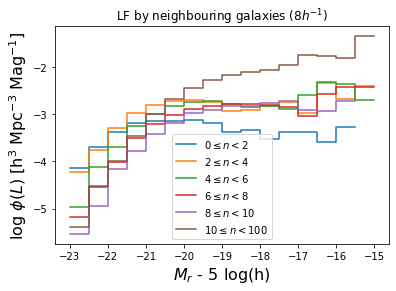

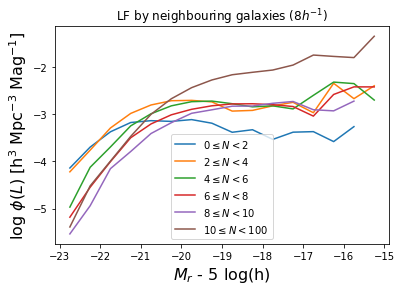

In [231]:
density_array = np.arange(0, 11, 2)
density_array = np.append(density_array, 100)

log_densities = []

for i in range(len(density_array)-1):

    data_d = data_t[(data_t['N_NEIGHBOUR'] >= density_array[i]) & (data_t['N_NEIGHBOUR'] < density_array[i+1])]
    print(len(data_d))
    LF_values2 = []
    densities2 = []

    for i in range(1, len(xedges)):
        lower_m = xedges[i-1]
        upper_m = xedges[i]
        sources = data_d[(data_d['R_ABSK']>=lower_m) & (data_d['R_ABSK']<upper_m)]

        LF_value = np.sum(sources['LF_VALUE_INTERP_K']/sky_fraction)
        density = LF_value / (upper_m - lower_m) 
        LF_values2.append(LF_value)
        densities2.append(density)

    log_LF_values2 = np.log10(LF_values2)    
    log_densities2 = np.log10(densities2)

    centres = (xedges[1:]+xedges[:-1])/2

    #popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities1, p0=[-21, -1, 10**-2])
    #plt.step(xedges, [log_densities2[0], *log_densities2], label='K with colour; bin-dependent completeness')

    #plt.step(xedges, [log_densities2[0], *log_densities2], label='{}<z<{}'.format(min_z, max_z))

    log_densities.append(log_densities2) 
    #print(log_densities2)

    data_array.append(data_d)

    '''    frac_w = []

        for i in range(len(xedges)-1):
            weight_sq_sum = 0.0
            sum_weight_sq = 0.0

            for j in range(len(data_d)):
                if (data_d['R_ABSK'][j] > xedges[i]) and (data_d['R_ABSK'][j] < xedges[i+1]):
                    weight_sq_sum += data_d['WEIGHT'][j]**2
                    sum_weight_sq += data_d['WEIGHT'][j]

            sum_weight_sq = sum_weight_sq**2
            frac_w.append(weight_sq_sum / sum_weight_sq)
    '''

for i in range(len(log_densities)):
    plt.step(xedges, [log_densities[i][0], *log_densities[i]], label=r'${} \leq n < {}$'.format(density_array[i], density_array[i+1]))
    
#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])

#plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')

#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
#plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
#plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'LF by neighbouring galaxies (8$h^{-1}$)')
plt.legend()
plt.show()


for i in range(len(log_densities)):
    plt.plot(centres, log_densities[i], label=r'${} \leq N < {}$'.format(density_array[i], density_array[i+1]))
    
#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])
#plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')
#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
#plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
#plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'LF by neighbouring galaxies (8$h^{-1}$)')
plt.legend()
plt.show()

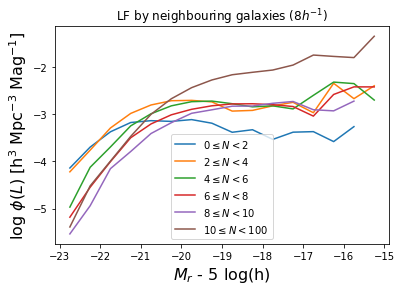

In [232]:
for i in range(len(log_densities)):
    plt.plot(centres, log_densities[i], label=r'${} \leq N < {}$'.format(density_array[i], density_array[i+1]))
    
#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])


#plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')


#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
#plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
#plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'LF by neighbouring galaxies (8$h^{-1}$)')
plt.legend()
plt.show()

Morphology LFs (basic on Sersic, work in progress)

Try using MORPHTYPE???

In [171]:
deep_bright_original[deep_bright_original['MORPHTYPE'] == 'DEV']

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MASKBITS,EBV,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET,SERSIC,MORPHTYPE,EXPID,FIBERSTATUS,B_DEPTH,R_DEPTH,Z_DEPTH,TILEID,G-R_OBS,G-R_REST,K_R,K_G,MW_CORRECTION_R,MODEL_MAG,MODEL_FIBRE_MAG,R_ABSK
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,str1,int64,int64,int64,int64,float32,str4,int64,int64,float32,float32,float32,int64,float32,float64,float64,float64,float32,float32,float32,float64
39627623051038321,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,66.7737467639935,-6.767002275837553,4.4394655,20.542341,47.187843,1.0743504,4.9712453,11.419455,0,0.048376177,S,1152921504715898985,131074,0,0,4.0,DEV,--,--,--,--,--,80612,1.6190017,1.7870091863080342,-0.2434132960394235,-0.4114207361697844,0.9080426,19.11364,20.654102,nan
39627623055230607,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,66.92759632751131,-6.7415119008948485,7.5508637,14.991982,21.407015,0.80745417,1.6031727,2.2891665,0,0.052983657,S,1152921504606846976,131074,0,0,4.0,DEV,--,--,--,--,--,80612,0.6918325,0.801918293649538,-0.2316045613657469,-0.34169037220050413,0.8997382,19.445642,21.872839,nan
39627629057278756,8764.332971887663,251.44597736455196 .. 7.620999281463702,0.2620177700445281,9.913174275931999e-05,0,7926,GALAXY,,10,50.91519206389785,0,1,66.65726922543507,-6.518315095964181,6.24794,23.743454,50.305534,0.91068715,3.460798,7.332433,0,0.062460355,S,1152921504606846976,131074,0,0,4.0,DEV,205935,0,1122.9,1089.4,1129.2,80612,1.3895327,0.9204143815567782,0.11368118516913822,0.5827994888922061,0.8828956,18.925913,21.016832,-21.03148314068347
39627629057280099,8502.10618505627,88.01960803336979 .. 7.14887996815851,0.34250376254131915,4.952870003161155e-05,0,7927,GALAXY,,10,606.8875521346927,0,1,66.7229418190863,-6.5790959925777655,6.789453,24.747744,59.704414,1.4908248,5.4340973,13.109867,0,0.05624018,S,1152921504732676217,131074,0,0,4.0,DEV,205935,0,1122.9,1089.4,1129.2,80612,1.3506372,0.7712305382320592,0.157994924532098,0.7374015837945391,0.8939146,18.894402,20.540422,-21.778185028918987
39627629057282061,8509.110698658973,314.134110396224 .. 8.395596390541222,0.2731435548472871,6.87645498455774e-05,0,7929,GALAXY,,10,320.4743211083114,0,1,66.81803280796117,-6.556462795591071,4.4113865,15.678386,30.00187,2.0090144,7.140182,13.663321,0,0.0585399,S,1152921504606846976,131074,0,0,4.0,DEV,205935,0,1122.9,1089.4,1129.2,80612,1.3206688,0.855097647921352,0.1046251775327651,0.5701963461778805,0.8898247,19.385008,20.238987,-20.66652609499391
39627635063521353,8931.401013553143,132.54749778027153 .. 29.638930340029106,0.12318621900352503,6.250959513998719e-06,0,7928,GALAXY,,10,1769.54482036829,0,1,66.62188433278659,-6.31290877766785,11.578769,23.781895,44.704643,2.829224,5.811007,10.923393,2048,0.056066964,S,1152921504606846976,131074,0,0,4.0,DEV,205935,0,1122.9,1089.4,1129.2,80612,0.7255364,0.6853598808124893,-0.0830960621869054,-0.04291953695920298,0.89422333,18.938,20.467987,-19.005615241990217
39627635063527770,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,66.86669924666994,-6.31389903987995,3.926221,16.55703,36.17628,1.5539443,6.5530453,14.318076,0,0.060425196,S,1152921504606846976,131074,0,0,4.0,DEV,--,--,--,--,--,80612,1.5051298,1.67313725427831,-0.2434132960394235,-0.4114207361697844,0.8864858,19.321724,20.328072,nan
39627635067717180,8428.194121517241,313.00270026677447 .. 5.644840621132775,0.30092154736418125,5.183509373864728e-05,0,7928,GALAXY,,10,595.7300252439454,0,1,66.93643152279238,-6.32513778314139,6.7613482,28.072353,63.24705,1.90

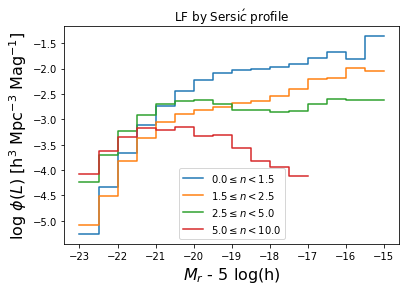

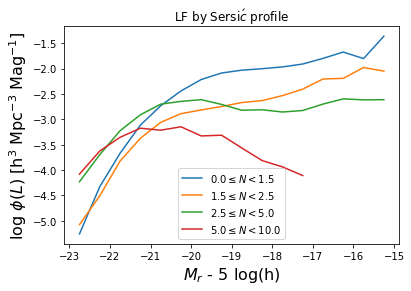

In [235]:
#sersic_array = np.arange(0.25, 5, 0.5)
#sersic_array = np.append(sersic_array, 10)
sersic_array = np.array([0, 1.5, 2.5, 5, 10])

log_densities = []

for i in range(len(sersic_array)-1):

    data_d = data_t[(data_t['SERSIC'] >= sersic_array[i]) & (data_t['SERSIC'] < sersic_array[i+1])]
    LF_values2 = []
    densities2 = []

    for i in range(1, len(xedges)):
        lower_m = xedges[i-1]
        upper_m = xedges[i]
        sources = data_d[(data_d['R_ABSK']>=lower_m) & (data_d['R_ABSK']<upper_m)]

        LF_value = np.sum(sources['LF_VALUE_INTERP_K']/sky_fraction)
        density = LF_value / (upper_m - lower_m) 
        LF_values2.append(LF_value)
        densities2.append(density)

    log_LF_values2 = np.log10(LF_values2)    
    log_densities2 = np.log10(densities2)

    centres = (xedges[1:]+xedges[:-1])/2

    #popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities1, p0=[-21, -1, 10**-2])
    #plt.step(xedges, [log_densities2[0], *log_densities2], label='K with colour; bin-dependent completeness')

    #plt.step(xedges, [log_densities2[0], *log_densities2], label='{}<z<{}'.format(min_z, max_z))

    log_densities.append(log_densities2) 
    #print(log_densities2)

    data_array.append(data_d)

    '''    frac_w = []

        for i in range(len(xedges)-1):
            weight_sq_sum = 0.0
            sum_weight_sq = 0.0

            for j in range(len(data_d)):
                if (data_d['R_ABSK'][j] > xedges[i]) and (data_d['R_ABSK'][j] < xedges[i+1]):
                    weight_sq_sum += data_d['WEIGHT'][j]**2
                    sum_weight_sq += data_d['WEIGHT'][j]

            sum_weight_sq = sum_weight_sq**2
            frac_w.append(weight_sq_sum / sum_weight_sq)
    '''

for i in range(len(log_densities)):
    plt.step(xedges, [log_densities[i][0], *log_densities[i]], label=r'${} \leq n < {}$'.format(sersic_array[i], sersic_array[i+1]))
    
#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])

#plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')

#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
#plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
#plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'LF by Sersi$\acute{c}$ profile')
plt.legend()
plt.show()


for i in range(len(log_densities)):
    plt.plot(centres, log_densities[i], label=r'${} \leq N < {}$'.format(sersic_array[i], sersic_array[i+1]))
    
#popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities, p0=[-21, -1, 10**-2])
#plt.errorbar(centres, log_densities[0], yerr=np.reciprocal(np.sqrt(np.reciprocal(frac_w))), fmt='.k')
#plt.plot(xspace, log_schechter(xspace, *popt), color='cyan', linewidth=2.5)
#plt.plot(xspace, log_schechter(xspace, *sdss_popt), color='red', linewidth=2.5, label=r'SDSS (Montero-Dorta, 2008)')
#plt.plot(xspace, log_schechter(xspace, *gama_popt), color='green', linewidth=2.5, label=r'GAMA (McNaught-Roberts, 2014)')
plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'LF by Sersi$\acute{c}$ profile')
plt.legend()
plt.show()

In [ ]:
'''
SOMETHING IS NOW WRONG HERE
'''

In [248]:
gr_array = stats.mstats.mquantiles(deep_bright_original['G-R_REST'][~np.isnan(deep_bright_original['G-R_REST'])], np.arange(0, 1.0001, 0.2))

log_densities = []
data_gr_array = []
min_z = 0
max_z = 0.6

for i in range(len(gr_array)-1):

    min_gr = gr_array[i]
    max_gr = gr_array[i+1]

    data_gr = data_t[(data_t['G-R_REST'] >= min_gr) & (data_t['G-R_REST'] < max_gr)]
    #data_gr = data_t[data_t['G-R_REST'] < max_gr]

    LF_values2 = []
    densities2 = []

    for i in range(1, len(xedges)):
        lower_m = xedges[i-1]
        upper_m = xedges[i]
        sources = data_gr[(data_gr['R_ABSK']>=lower_m) & (data_gr['R_ABSK']<upper_m)]

        LF_value = np.sum(sources['LF_VALUE_INTERP_K']/sky_fraction)
        density = LF_value / (upper_m - lower_m) 
        LF_values2.append(LF_value)
        densities2.append(density)

    log_LF_values2 = np.log10(LF_values2)    
    log_densities2 = np.log10(densities2)

    #log_densities2[log_densities2 == -inf] = 0 
    #log_LF_values2[log_LF_values2 == -inf] = 0

    centres = (xedges[1:]+xedges[:-1])/2

    #popt, pcov = curve_fit(log_schechter, xdata=centres, ydata=log_densities1, p0=[-21, -1, 10**-2])
    #plt.step(xedges, [log_densities2[0], *log_densities2], label='K with colour; bin-dependent completeness')

    #plt.step(xedges, [log_densities2[0], *log_densities2], label='{}<z<{}'.format(min_z, max_z))
    
    log_densities.append(log_densities2) 
    print(log_densities2)
    
    data_gr_array.append(data_gr)

[       -inf -4.91871191 -4.12624454 -3.54873551 -3.13849637 -2.86626706
 -2.6015586  -2.36101939 -2.24532027 -2.20461577 -2.04997826 -1.97956671
 -1.79350954 -1.67346289 -1.63723134 -1.45337097]
[-5.19338457 -4.26186564 -3.68448176 -3.20119796 -2.91917888 -2.67907982
 -2.52111948 -2.52462295 -2.52236761 -2.45232029 -2.47703422 -2.35800192
 -2.36737501 -2.21927936 -2.36013    -1.89572714]
[-4.68739323 -3.9654787  -3.47681598 -3.08596277 -2.84498672 -2.68690722
 -2.58002349 -2.54941771 -2.5299011  -2.52375854 -2.71682782 -2.5915026
 -2.42897892 -2.57851539 -2.90463328 -2.1668945 ]
[-4.40195105 -3.77860264 -3.2692586  -2.95260906 -2.78246247 -2.68559131
 -2.66932425 -2.68382816 -2.88565707 -2.99314256 -3.028472   -3.6456118
        -inf -3.57568684        -inf        -inf]
[-4.0464315  -3.75377067 -3.59890528 -3.61633431 -3.50599375 -3.4959311
 -3.59961959 -3.72660789 -3.53667507 -3.68675084 -3.90471478 -3.80293848
        -inf        -inf        -inf        -inf]


In [249]:
LFgr1 = log_densities

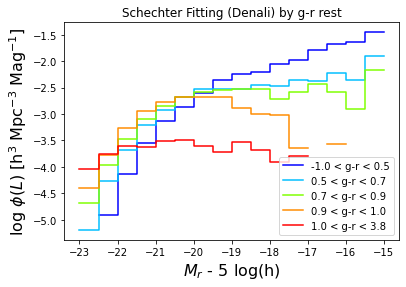

In [250]:
colour_array = ['#0000FF', '#00BFFF',  '#7FFF00', '#FF8C00', '#FF0000']

for i in range(len(log_densities)):
    plt.step(xedges, [LFgr1[i][0], *LFgr1[i]], label=r'{:.1f} < g-r < {:.1f}'.format(gr_array[i], gr_array[i+1]), color=colour_array[i])

plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'Schechter Fitting (Denali) by g-r rest')
plt.legend()
plt.show()

In [251]:
LFgr1_mid = []
centres_array = []
centres = (xedges[1:] + xedges[:-1]) / 2

for i in range(len(LFgr1)):
    mid = (LFgr1[i][1:] + LFgr1[i][:-1]) / 2
    LFgr1_mid.append(mid)
    centres_array.append(centres)

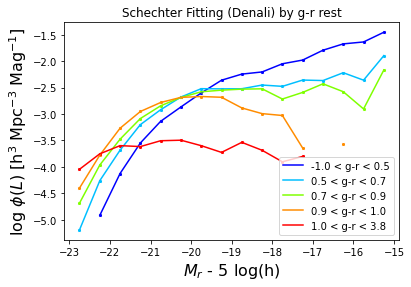

In [252]:
colour_array = ['#0000FF', '#00BFFF',  '#7FFF00', '#FF8C00', '#FF0000']

for i in range(len(LFgr1_mid)):
    plt.plot(centres_array[i], LFgr1[i], label=r'{:.1f} < g-r < {:.1f}'.format(gr_array[i], gr_array[i+1]), color=colour_array[i])
    plt.scatter(centres_array[i], LFgr1[i], color=colour_array[i], marker='x', s=5)

plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=16)
#plt.xlim(-23, -16)
plt.title(r'LF by g-r rest')
plt.legend()
plt.show()

In [ ]:
def target_density(data):
    captargs_t = captargs
    
    #data['NODATA'] = (data['ZWARN'] & 2**9) != 0
    #badfibre = data['NODATA']
    #data = data[~badfibre]
    
    if tile_split == False:
        target_m = []
        for i in range(len(tile_array)):
            # exclude MWS objects
            captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
            #target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
            target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
            
        target_m = np.array(target_m)

        print('target objects with apparent magnitudes:', len(target_m))
        print('targeted objects with apparent magnitudes:', len(data))

In [ ]:
tile_split=False
data= deep_bright_original

In [ ]:

# for BGS BRIGHT
captargs_t = captargs

#data['NODATA'] = (data['ZWARN'] & 2**9) != 0
#badfibre = data['NODATA']
#data = data[~badfibre]

if tile_split == False:
    target_m = []
    for i in range(len(tile_array)):
        # exclude MWS objects
        captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
        #target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
        target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))

    target_m = np.array(target_m)

    #print('target objects with apparent magnitudes:', len(target_m))
    #print('targeted objects with apparent magnitudes:', len(data))
    
    total_targeted_number = len(data)
    total_tile_number = len(captargs_t)
    total_targeted_number_density = total_targeted_number / (total_tile_number * np.pi * 1.6**2)
    
    target_density_ratio_list = []
    for i in range(len(tile_array)):
        # exclude MWS objects
        captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
        #target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
        target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
        target_m = np.array(target_m)

        data_ts = data[data['TILEID'] == tile_array[i]]
        #print('target objects with apparent magnitudes:', len(target_m))
        #print('targeted objects with apparent magnitudes:', len(data_ts))
        
        tile_targeted_number = len(data_ts)
        tile_targeted_number_density = tile_targeted_number / (np.pi * 1.6**2)
        target_density_ratio = total_targeted_number_density / tile_targeted_number_density
        target_density_ratio_list.append(target_density_ratio)
        
        print(tile_array[i], target_density_ratio)

In [ ]:
plt.scatter(tile_array, target_density_ratio_list)
plt.plot(tile_array, target_density_ratio_list)
plt.xlabel('Tile ID')
plt.ylabel('Target Density Fraction')
plt.axhline(y=np.mean(target_density_ratio_list), color='c', linestyle='-')
print('s.d =', np.std(target_density_ratio_list))
print('s.e =', np.std(target_density_ratio_list)/np.sqrt(len(target_density_ratio_list)))
std_error = np.std(target_density_ratio_list)/np.sqrt(len(target_density_ratio_list))
plt.axhline(y=np.mean(target_density_ratio_list)-std_error, color='c', linestyle='--')
plt.axhline(y=np.mean(target_density_ratio_list)+std_error, color='c', linestyle='--')



In [ ]:

# for BGS BRIGHT
captargs_t = captargs

#data['NODATA'] = (data['ZWARN'] & 2**9) != 0
#badfibre = data['NODATA']
#data = data[~badfibre]

if tile_split == False:
    target_m = []
    for i in range(len(tile_array)):
        # exclude MWS objects
        captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
        #target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
        target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))

    target_m = np.array(target_m)

    #print('target objects with apparent magnitudes:', len(target_m))
    #print('targeted objects with apparent magnitudes:', len(data))
    
    total_targeted_number = len(data)
    total_tile_number = len(captargs_t)
    total_targeted_number_density = total_targeted_number / (total_tile_number * np.pi * 1.6**2)
    
    target_density_ratio_list = []
    for i in range(len(tile_array)):
        # exclude MWS objects
        captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
        #target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
        target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
        target_m = np.array(target_m)

        data_ts = data[data['TILEID'] == tile_array[i]]
        #print('target objects with apparent magnitudes:', len(target_m))
        #print('targeted objects with apparent magnitudes:', len(data_ts))
        
        tile_targeted_number = len(data_ts)
        tile_targeted_number_density = tile_targeted_number / (np.pi * 1.6**2)
        target_density_ratio = tile_targeted_number_density / total_targeted_number_density
        target_density_ratio_list.append(target_density_ratio)
        
        print(tile_array[i], target_density_ratio)

In [ ]:
plt.scatter(tile_array, target_density_ratio_list)
plt.plot(tile_array, target_density_ratio_list)
plt.xlabel('Tile ID')
plt.ylabel('Target Density Fraction')
plt.axhline(y=np.mean(target_density_ratio_list), color='c', linestyle='-')
print('s.d =', np.std(target_density_ratio_list))
print('s.e =', np.std(target_density_ratio_list)/np.sqrt(len(target_density_ratio_list)))
std_error = np.std(target_density_ratio_list)/np.sqrt(len(target_density_ratio_list))
plt.axhline(y=np.mean(target_density_ratio_list)-std_error, color='c', linestyle='--')
plt.axhline(y=np.mean(target_density_ratio_list)+std_error, color='c', linestyle='--')

In [ ]:
tile_targeted_number_density

In [ ]:
# for BGS BRIGHT
captargs_t = captargs

#data['NODATA'] = (data['ZWARN'] & 2**9) != 0
#badfibre = data['NODATA']
#data = data[~badfibre]

if tile_split == False:
    target_m = []
    for i in range(len(tile_array)):
        # exclude MWS objects
        captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
        #target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))
        target_m.extend(22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R')))

    target_m = np.array(target_m)

    #print('target objects with apparent magnitudes:', len(target_m))
    #print('targeted objects with apparent magnitudes:', len(data))
    
    total_targeted_number = len(data)
    total_tile_number = len(captargs_t)
    total_targeted_number_density = 800 # for BGS bright
    
    target_density_ratio_list = []
    for i in range(len(tile_array)):
        # exclude MWS objects
        captargs_t[str(tile_array[i])] = captargs_t[str(tile_array[i])][captargs_t[str(tile_array[i])]['SV1_BGS_TARGET'] != 0]
        #target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
        target_m = 22.5 - 2.5*np.log10(captargs[str(tile_array[i])]['FIBERFLUX_R'] / mw_xtinct(captargs[str(tile_array[i])]['EBV'], band='R'))
        target_m = np.array(target_m)

        data_ts = data[data['TILEID'] == tile_array[i]]
        #print('target objects with apparent magnitudes:', len(target_m))
        #print('targeted objects with apparent magnitudes:', len(data_ts))
        
        tile_targeted_number = len(data_ts)
        tile_targeted_number_density = tile_targeted_number / (np.pi * 1.6**2)
        target_density_ratio = total_targeted_number_density / tile_targeted_number_density
        target_density_ratio_list.append(target_density_ratio)
        
        print(tile_array[i], target_density_ratio)

In [ ]:
plt.scatter(tile_array, target_density_ratio_list)
plt.plot(tile_array, target_density_ratio_list)
plt.xlabel('Tile ID')
plt.ylabel('Target Density Fraction')

In [ ]:
frac_zsuccess, zsuccess_data = z_success(data_complete, tile_split=True, deltachi2=40, spectype=None, z_min=0, z_max=0.6, zwarn=True, zerr=True, hist_counts=False)

In [ ]:
for i in range(len(bins_list)-1):
    for j in range(len(data_t)):
        if (data_t['MODEL_MAG'][j] > bins_list[i]) and (data_t['MODEL_MAG'][j] < bins_list[i+1]):
            data_t['WEIGHT1'][j] = weights[i]

for i in range(bins_list) 
data_tm = deep_bright_original['MODEL_MAG']            

weight_sq_sum = np.sum(deep_bright_original['WEIGHT'])**2
sum_weight_sq = np.sum(deep_bright_original['WEIGHT']**2)

In [ ]:

'''
SOURCE: Table 1. and Eqn 1. in McNaught-Roberts et al. (2014)
        Values for (g-r)_0 = 0.553
        params=[-6.299, 14.76, -7.473, 1.847, -0.006801]
'''

In [ ]:
params=[-31.36, 38.63, -14.79, 1.427, 0.001301] # 0.158
params=[-17.77, 25.50, -10.79, 1.366, 0.006235] # 0.298
params=[-12.94, 21.44, -9.826, 1.683, -0.001972] # 0.419
params=[-6.299, 14.76, -7.473, 1.847, -0.006801] # 0.553
params=[9.017, -1.390,-0.9145, 1.376,-0.0044724] # 0.708
params=[14.78, -6.592, 0.9443, 1.357, -0.005131] # 0.796
params=[15.09, -5.730, -0.2097, 1.859, -0.01250] # 0.960

In [ ]:
frac_zsuccess, zsuccess_data = z_success_test(data_complete, tile_split=True, deltachi2=40, z_min=None, z_max=0.75, zwarn=True, zerr=True, hist_counts=False)

In [ ]:
db_cut = deep_bright_original[deep_bright_original['SPECTYPE'] != 'STAR']
db_cut = db_cut[db_cut['ZWARN'] == 0]
db_cut = db_cut[db_cut['Z'] < 0.75]

In [ ]:
plt.hist(db_cut['Z'], bins=50)

In [ ]:
gr_array_cut = stats.mstats.mquantiles(db_cut['G-R_REST'][~np.isnan(db_cut['G-R_REST'])], np.arange(0, 1.0001, 0.05))


In [ ]:
db_bluest_15 = db_cut[db_cut['G-R_REST'] < gr_array_cut[3]]
db_reddest_15 = db_cut[db_cut['G-R_REST'] > gr_array_cut[-4]]

In [ ]:
gr_array_cut[-11]

In [ ]:
plt.scatter(db_bluest_15['Z'], db_bluest_15['G-R_REST'], s=0.5, label='bluest 15%')
plt.scatter(db_reddest_15['Z'], db_reddest_15['G-R_REST'], s=0.5, label='reddest 15%')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$(g-r)_{rest}$', fontsize=16)
plt.legend()
plt.show()

plt.hist(db_bluest_15['Z'], bins=50, histtype='step', label='bluest 15%')
plt.hist(db_reddest_15['Z'], bins=50, histtype='step', label='reddest 15%')
plt.legend()
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) plots for galaxies in 17 Denali Tiles (BGS Bright)')
plt.show()
'''
2710 objects in each histogram
Selection cuts are:
SPECTYPE == STAR
z < 0.75
ZWARN == 0
'''

In [ ]:
db_bluest_50 = db_cut[db_cut['G-R_REST'] < gr_array_cut[10]]
db_reddest_50 = db_cut[db_cut['G-R_REST'] > gr_array_cut[-11]]

plt.hist(db_bluest_50['Z'], bins=50, histtype='step', label='bluest 50%')
plt.hist(db_reddest_50['Z'], bins=50, histtype='step', label='reddest 50%')
plt.legend()
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) plots for galaxies in 17 Denali Tiles (BGS Bright)')

In [ ]:
print(len(db_bluest_50))
print(len(db_reddest_50))

In [ ]:
plt.scatter(db_bluest_50['Z'], db_bluest_50['G-R_REST'], s=0.5, label='bluest 50%')
plt.scatter(db_reddest_50['Z'], db_reddest_50['G-R_REST'], s=0.5, label='reddest 50%')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$(g-r)_{rest}$', fontsize=16)
plt.legend()

In [ ]:
db_test = db_cut[db_cut['G-R_REST'] > gr_array_cut[-4]]

In [ ]:
plt.scatter(deep_bright_original['MODEL_MAG'], deep_bright_original['MODEL_FIBRE_MAG'], s=0.5)
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.title('Magnitude vs. Fibre Magnitude (Denali)')

In [ ]:
db1 = deep_bright_original[deep_bright_original['Z'] < 0.75] 
db1 = db1[db1['SPECTYPE'] != 'STAR']

plt.scatter(db1['MODEL_MAG'], db1['MODEL_FIBRE_MAG'], s=0.5)
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.title('Magnitude vs. Fibre Magnitude with SPECTYPE != STAR')

In [ ]:
db1 = deep_bright_original[deep_bright_original['Z'] < 0.75] 
db1 = db1[db1['ZWARN'] == 0] 
db1['cz'] = db1['Z'] * (3*10**5)

cp1 = [13,14]
cp2 = [17.5, 18.3]

plt.scatter(db1['MODEL_MAG'], db1['MODEL_FIBRE_MAG'], s=0.5)
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)

plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.title('Magnitude vs. Fibre Magnitude with ZWARN == 0')
plt.show()

In [ ]:
print('original star count by Redrock:', len(db1[db1['SPECTYPE'] == 'STAR'])) 

m = (cp2[1] - cp1[1]) / (cp2[0] - cp1[0])
c = cp1[1] - m*cp1[0]


In [ ]:
print(m, c)

In [ ]:
print(*cp1, *cp2)

In [ ]:

db1_star = db1[db1['MODEL_FIBRE_MAG'] < cp2[1]]
db1_star = db1_star[db1_star['MODEL_FIBRE_MAG'] - m*db1_star['MODEL_MAG'] < c]
plt.scatter(db1_star['MODEL_MAG'], db1_star['MODEL_FIBRE_MAG'], s=0.5)
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.title('Stars by Magnitude vs. Fibre Magnitude cut')


In [ ]:
db1_gal = setdiff(db1, db1_star, keys=['TARGETID'])

In [ ]:
print(len(db1), len(db1_star), len(db1_gal))

In [ ]:
plt.scatter(db1_gal['MODEL_MAG'], db1_gal['MODEL_FIBRE_MAG'], s=0.5)
plt.show()

In [ ]:
plt.scatter(db1_gal['MODEL_MAG'], db1_gal['MODEL_FIBRE_MAG'], s=0.5)
plt.scatter(db1_star['MODEL_MAG'], db1_star['MODEL_FIBRE_MAG'], s=0.5)
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.title('Stars by Magnitude vs. Fibre Magnitude cut')

In [ ]:
print('Star count by cut:', len(db1_star)) 

In [ ]:
plt.scatter(db1_gal['MODEL_MAG'], db1_gal['MODEL_FIBRE_MAG'], s=0.5)
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')

In [ ]:
db1_gal_specg = db1_gal[db1_gal['SPECTYPE'] != 'STAR']
db1_gal_specs = db1_gal[db1_gal['SPECTYPE'] == 'STAR']

db1_star_specg = db1_star[db1_star['SPECTYPE'] != 'STAR']
db1_star_specs = db1_star[db1_star['SPECTYPE'] == 'STAR']

print('db1_total:', len(db1))
print('db1_gal:', len(db1_gal))
print('of which SPECTYPE != STAR:', len(db1_gal_specg))
print('of which SPECTYPE == STAR:', len(db1_gal_specs))
print('')
print('db1_star:', len(db1_star))
print('of which SPECTYPE != STAR:', len(db1_star_specg))
print('of which SPECTYPE == STAR:', len(db1_star_specs))


plt.scatter(db1_gal_specg['MODEL_MAG'], db1_gal_specg['MODEL_FIBRE_MAG'], s=0.5, label='SPECTYPE != STAR')
plt.scatter(db1_gal_specs['MODEL_MAG'], db1_gal_specs['MODEL_FIBRE_MAG'], s=0.5, label='SPECTYPE == STAR')
plt.scatter(db1_star_specg['MODEL_MAG'], db1_star_specg['MODEL_FIBRE_MAG'], s=0.5, label='SPECTYPE != STAR')
plt.scatter(db1_star_specs['MODEL_MAG'], db1_star_specs['MODEL_FIBRE_MAG'], s=0.5, label='SPECTYPE == STAR')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)

lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
lgnd.legendHandles[2]._sizes = [20]
lgnd.legendHandles[3]._sizes = [20]

plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.title('Magnitude vs. Fibre Magnitude cut')
plt.show()


plt.scatter(db1_gal_specg['MODEL_MAG'], db1_gal_specg['MODEL_FIBRE_MAG'], s=0.5, label='SPECTYPE != STAR')
plt.scatter(db1_gal_specs['MODEL_MAG'], db1_gal_specs['MODEL_FIBRE_MAG'], s=0.5, label='SPECTYPE == STAR')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.title('Galaxy cut by Magnitude vs. Fibre Magnitude cut')
plt.show()




plt.scatter(db1_star_specg['MODEL_MAG'], db1_star_specg['MODEL_FIBRE_MAG'], s=0.5, color='g', label='SPECTYPE != STAR')
plt.scatter(db1_star_specs['MODEL_MAG'], db1_star_specs['MODEL_FIBRE_MAG'], s=0.5, color='r', label='SPECTYPE == STAR')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.title('Star cut by Magnitude vs. Fibre Magnitude cut')
plt.show()

In [ ]:
sc = plt.scatter(db1_gal_specs['MODEL_MAG'], db1_gal_specs['MODEL_FIBRE_MAG'], s=0.5, c=db1_gal_specs['Z'], label='SPECTYPE == STAR')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.colorbar(sc)

In [ ]:
sc = plt.scatter(db1_gal_specg['MODEL_MAG'], db1_gal_specg['MODEL_FIBRE_MAG'], s=0.5, c=db1_gal_specg['Z'], label='SPECTYPE != STAR')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.colorbar(sc)
plt.title('z-distribution for galaxy cut, spectype != STAR')
plt.show()

plt.hist(db1_gal_specg['Z'], bins=20, histtype='step')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) for galaxy cut, spectype != STAR')
plt.show()

In [ ]:
sc = plt.scatter(db1_gal_specs['MODEL_MAG'], db1_gal_specs['MODEL_FIBRE_MAG'], s=0.5, c=db1_gal_specs['Z'], label='SPECTYPE == STAR')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.colorbar(sc)
plt.title('z-distribution for galaxy cut, spectype == STAR')
plt.show()

plt.hist(db1_gal_specs['Z'], bins=20, histtype='step')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) for galaxy cut, spectype == STAR')
plt.show()

In [ ]:
sc = plt.scatter(db1_star_specg['MODEL_MAG'], db1_star_specg['MODEL_FIBRE_MAG'], s=0.5, c=db1_star_specg['Z'], label='SPECTYPE != STAR')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.colorbar(sc)
plt.title('z-distribution for star cut, spectype != STAR')
plt.show()

plt.hist(db1_star_specg['Z'], bins=20, histtype='step')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) for star cut, spectype != STAR')
plt.show()

In [ ]:
sc = plt.scatter(db1_star_specs['MODEL_MAG'], db1_star_specs['MODEL_FIBRE_MAG'], s=0.5, c=db1_star_specs['Z'], label='SPECTYPE == STAR')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.colorbar(sc)
plt.title('z-distribution for star cut, spectype == STAR')
plt.show()

plt.hist(db1_star_specs['Z'], bins=20, histtype='step')
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(z) for star cut, spectype == STAR')
plt.show()

In [ ]:
sc = plt.scatter(db1['MODEL_MAG'], db1['MODEL_FIBRE_MAG'], s=0.5, c=db1['Z'], label='SPECTYPE == STAR')
plt.colorbar(sc)

In [ ]:
from scipy.stats import gaussian_kde

x = db1['MODEL_MAG']
y = db1['MODEL_FIBRE_MAG']

#cp1 = [13,14.5]
#cp2 = [18.25, 18.75]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=1.5, edgecolor='')
plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')

plt.annotate('({},{})'.format(cp1[0], cp1[1]), (cp1[0], cp1[1]), xytext=(cp1[0]-1.5, cp1[1]))
plt.annotate('({},{})'.format(cp2[0], cp2[1]), (cp2[0], cp2[1]), xytext=(cp2[0]-0.1, cp2[1]-1))

plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
plt.title('Density contour plot')
plt.show()

In [ ]:
plt.hist(db1['cz'], bins=50)

In [ ]:
db1_gal_specg = db1_gal[db1_gal['SPECTYPE'] != 'STAR']
db1_gal_specs = db1_gal[db1_gal['SPECTYPE'] == 'STAR']

db1_star_specg = db1_star[db1_star['SPECTYPE'] != 'STAR']
db1_star_specs = db1_star[db1_star['SPECTYPE'] == 'STAR']

cz_val = 1500
db1_gal_specg_z = db1_gal_specg[db1_gal_specg['cz'] < cz_val]
db1_gal_specs_z = db1_gal_specs[db1_gal_specs['cz'] < cz_val]


plt.scatter(db1_star_specg['MODEL_MAG'], db1_star_specg['MODEL_FIBRE_MAG'], s=0.5, color='g', label='SPECTYPE != STAR')
plt.scatter(db1_star_specs['MODEL_MAG'], db1_star_specs['MODEL_FIBRE_MAG'], s=0.5, color='r', label='SPECTYPE == STAR')
plt.scatter(db1_gal_specg_z['MODEL_MAG'], db1_gal_specg_z['MODEL_FIBRE_MAG'], s=0.5, color='cyan', label='SPECTYPE != STAR, cz < {} km/s'.format(cz_val))
plt.scatter(db1_gal_specs_z['MODEL_MAG'], db1_gal_specs_z['MODEL_FIBRE_MAG'], s=0.5, color='black', label='SPECTYPE == STAR, cz < {} km/s'.format(cz_val))



plt.plot([cp2[0], cp2[1]+1], [cp2[1], cp2[1]], '--', color='black')
plt.plot([cp1[0], cp2[0]], [cp1[1], cp2[1]], '--', color='black')
plt.xlabel(r'$m_r$', fontsize=16)
plt.ylabel(r'$m_{r, fibre}$', fontsize=16)
lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
lgnd.legendHandles[2]._sizes = [20]
lgnd.legendHandles[3]._sizes = [20]
plt.title('Star cut and cz < {} km/s cut'.format(cz_val))
plt.show()

print('SPECTYPE != STAR:',len(db1_star_specg))
print('SPECTYPE == STAR:',len(db1_star_specs))
print('SPECTYPE != STAR, cz cut:',len(db1_gal_specg_z))
print('SPECTYPE == STAR, cz cut:',len(db1_gal_specs_z))


In [ ]:
m,b = np.polyfit(db1_star['MODEL_MAG'], db1_star['MODEL_FIBRE_MAG'], 1)
print(m, b)

In [ ]:
for i in range(len(db1_gal_specg_z)):
    print(db1_gal_specg_z['TARGETID'][i], db1_gal_specg_z['TARGET_RA'][i], db1_gal_specg_z['TARGET_DEC'][i])

In [ ]:
for i in range(len(db1_gal_specg_z)):
    print(db1_gal_specg_z[i]['TILEID'])